# import modules

In [16]:
import sys

sys.path.insert(0, "../")

from modules.Classes_ver2 import *
from modules.default_params_ver1 import *
from modules.functions_ver2 import *
from multiprocessing import Pool, cpu_count

print("Number of cores: ", cpu_count())

Number of cores:  8


# assign params

In [4]:
lens_params, RP_params, NP_params = set_to_params(lens_params_1, RP_params_1, NP_params_1)

# mismatch optimized over $\tilde{\theta}$, $\tilde{\Omega}$, and $\gamma_P$

In [3]:
from multiprocessing import Pool


def compute_mismatch(r, c, tpl_params, src_params, opt_match):
    n_pts = 20
    omega_tilde_arr = np.linspace(0, 3, n_pts)
    theta_tilde_arr = np.linspace(0, 8, n_pts)
    X, Y = np.meshgrid(omega_tilde_arr, theta_tilde_arr)
    tpl_params["omega_tilde"] = X[r, c]
    tpl_params["theta_tilde"] = Y[r, c]

    optimized_mismatch_results_dict = optimize_mismatch_gammaP(
        tpl_params, src_params, use_opt_match=opt_match
    )

    return (
        optimized_mismatch_results_dict["ep_min"],
        optimized_mismatch_results_dict["ep_min_gammaP"],
    )


def mismatch_contour_parallel(tpl_params, src_params, opt_match=True):
    n_pts = 20
    omega_tilde_arr = np.linspace(0, 3, n_pts)
    theta_tilde_arr = np.linspace(0, 8, n_pts)
    X, Y = np.meshgrid(omega_tilde_arr, theta_tilde_arr)
    Z = np.zeros_like(X)
    g_min_matrix = np.zeros_like(X)

    # Create a pool of worker processes
    with Pool(cpu_count()) as pool:  # Use maximum number of cores
        results = []
        for r in range(n_pts):
            for c in range(n_pts):
                results.append(
                    pool.apply_async(
                        compute_mismatch, args=(r, c, tpl_params, src_params, opt_match)
                    )
                )

        for r in range(n_pts):
            for c in range(n_pts):
                idx = r * n_pts + c
                Z[r, c], g_min_matrix[r, c] = results[idx].get()

    min_idx = np.unravel_index(np.argmin(Z, axis=None), Z.shape)
    max_idx = np.unravel_index(np.argmax(Z, axis=None), Z.shape)

    results_dict = {
        "ep_0_0": Z[0, 0],
        "ep_min": Z[min_idx],
        "ep_min_omega_tilde": X[min_idx],
        "ep_min_theta_tilde": Y[min_idx],
        "ep_min_gammaP": g_min_matrix[min_idx],
        "ep_max": Z[max_idx],
        "ep_max_omega_tilde": X[max_idx],
        "ep_max_theta_tilde": Y[max_idx],
        "ep_max_gammaP": g_min_matrix[max_idx],
        "ep_max_min_ratio": Z[max_idx] / Z[min_idx],
    }

    return results_dict

# as a function of $\Delta t_d$ while fixing $I$

In [17]:
lens_params, RP_params, NP_params = set_to_params(
    lens_params_1, RP_params_1, NP_params_1
)

I = LensingGeo(lens_params).I()
MLz_arr = np.linspace(400, 4600, 30)
Delta_td_arr = np.zeros_like(MLz_arr)

mismatch_Deltatd_dict = {}

for i, MLz in enumerate(MLz_arr):
    lens_params["MLz"] = MLz * solar_mass
    Delta_td = LensingGeo(lens_params).td()
    Delta_td_arr[i] = Delta_td
    # mismatch_Deltatd_dict[Delta_td] = mismatch_contour_parallel(RP_params, lens_params)

In [5]:
# now = datetime.now()
# filename = "mismatch_Deltatd_dict_" + now.strftime("%Y-%m-%d_%H-%M-%S") + ".pkl"
# filepath = os.path.join("data", filename)
# with open(filepath, "wb") as f:
#     pickle.dump(mismatch_Deltatd_dict, f)
#     print("Results saved as", filepath)

Results saved as data/mismatch_Deltatd_dict_2024-04-16_17-48-12.pkl


In [18]:
filepath = "../data/mismatch_Deltatd_dict_2024-04-16_17-48-12.pkl"
with open(filepath, "rb") as f:
    mismatch_Deltatd_dict = pickle.load(f)

mismatch_Deltatd_dict

{0.003951231688892276: {'ep_0_0': 0.0004046274597211408,
  'ep_min': 0.00014795117200416819,
  'ep_min_omega_tilde': 0.3157894736842105,
  'ep_min_theta_tilde': 5.894736842105263,
  'ep_min_gammaP': 0.6346651825433925,
  'ep_max': 0.16618348223586987,
  'ep_max_omega_tilde': 3.0,
  'ep_max_theta_tilde': 8.0,
  'ep_max_gammaP': 2.221328138901874,
  'ep_max_min_ratio': 1123.2319418949114},
 0.0053818500590084445: {'ep_0_0': 0.005022767198758826,
  'ep_min': 0.0012585973738398204,
  'ep_min_omega_tilde': 0.47368421052631576,
  'ep_min_theta_tilde': 7.578947368421052,
  'ep_min_gammaP': 0.25386607301735703,
  'ep_max': 0.17127336300763119,
  'ep_max_omega_tilde': 3.0,
  'ep_max_theta_tilde': 8.0,
  'ep_max_gammaP': 2.3482611754105527,
  'ep_max_min_ratio': 136.08272714338975},
 0.006812468429124613: {'ep_0_0': 0.03313238816761299,
  'ep_min': 0.006618025041765452,
  'ep_min_omega_tilde': 0.0,
  'ep_min_theta_tilde': 5.052631578947368,
  'ep_min_gammaP': 5.458120569873176,
  'ep_max': 0.192

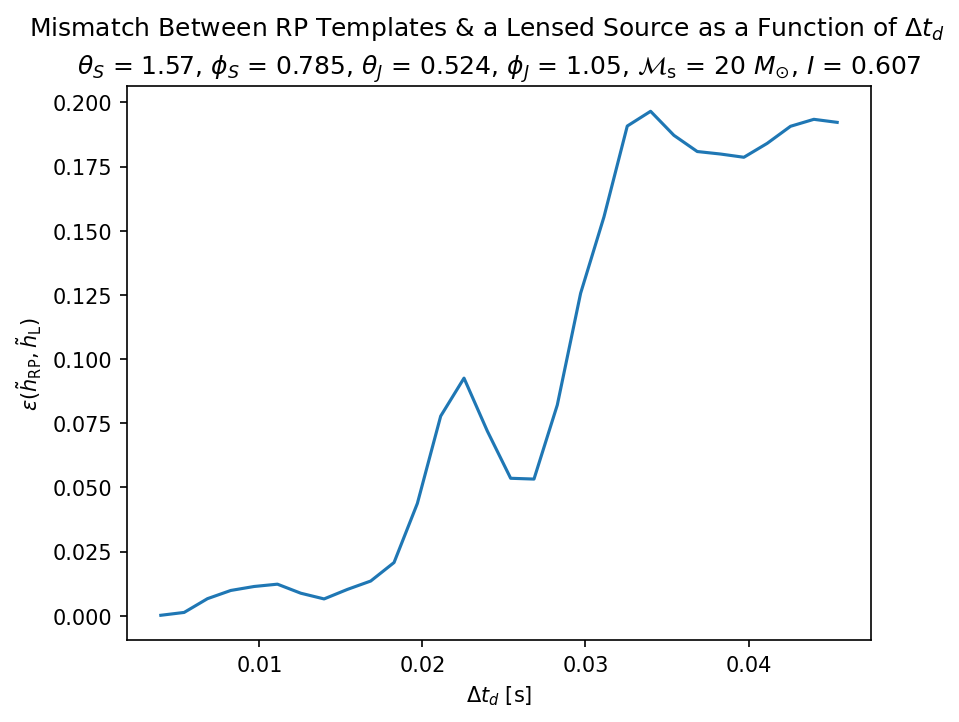

In [14]:
Deltatd_ep_min_arr = np.array(
    [mismatch_Deltatd_dict[Delta_td]["ep_min"] for Delta_td in Delta_td_arr]
)

plt.plot(
    Delta_td_arr, Deltatd_ep_min_arr, label=r"$\epsilon(\~h_{\rm RP}, \~h_{\rm L})$"
)
plt.xlabel(r"$\Delta t_d$ [s]")
plt.ylabel(r"$\epsilon(\~h_{\rm RP}, \~h_{\rm L})$")

plt.title(
    r"$\theta_S$ = {:.3g}, $\phi_S$ = {:.3g}, $\theta_J$ = {:.3g}, $\phi_J$ = {:.3g}, {} = {:.3g} {}, $I$ = {:.3g}".format(
        lens_params["theta_S"],
        lens_params["phi_S"],
        lens_params["theta_J"],
        lens_params["phi_J"],
        r"$\mathcal{M}_{\text{s}}$",
        lens_params["mcz"] / solar_mass,
        r"$M_{\odot}$",
        I,
    )
)

plt.suptitle(
    r"Mismatch Between RP Templates & a Lensed Source as a Function of $\Delta t_d$"
)

plt.show()

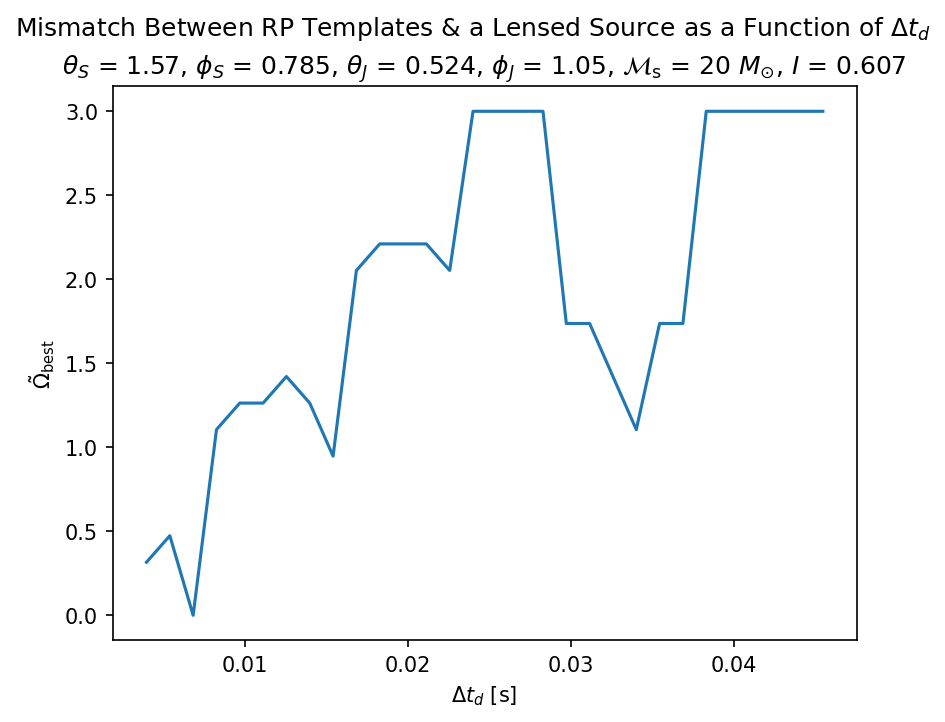

In [8]:
Deltatd_ep_min_omega_tilde_arr = np.array(
    [mismatch_Deltatd_dict[Delta_td]["ep_min_omega_tilde"] for Delta_td in Delta_td_arr]
)

plt.plot(Delta_td_arr, Deltatd_ep_min_omega_tilde_arr, label=r"$\~{\Omega}_{\rm best}$")
plt.xlabel(r"$\Delta t_d$ [s]")
plt.ylabel(r"$\~{\Omega}_{\rm best}$")

plt.title(
    r"$\theta_S$ = {:.3g}, $\phi_S$ = {:.3g}, $\theta_J$ = {:.3g}, $\phi_J$ = {:.3g}, {} = {:.3g} {}, $I$ = {:.3g}".format(
        lens_params["theta_S"],
        lens_params["phi_S"],
        lens_params["theta_J"],
        lens_params["phi_J"],
        r"$\mathcal{M}_{\text{s}}$",
        lens_params["mcz"] / solar_mass,
        r"$M_{\odot}$",
        I,
    )
)

plt.suptitle(
    r"Mismatch Between RP Templates & a Lensed Source as a Function of $\Delta t_d$"
)

plt.show()

# as a function of $I$ while fixing $\Delta t_d$

In [34]:
lens_params, RP_params, NP_params = set_to_params(
    lens_params_1, RP_params_1, NP_params_1
)

# create y_range and MLz_range based on the same time delay
y_arr = np.linspace(0.5, 3, 50)[::-1]
time_delay = 0.1
MLz_arr = get_MLz_from_td(time_delay, y_arr)
I_arr = np.zeros_like(MLz_arr)

mismatch_I_dict = {}

for i, y, MLz in zip(range(len(y_arr)), y_arr, MLz_arr):
    lens_params["y"] = y
    lens_params["MLz"] = MLz * solar_mass
    I = LensingGeo(lens_params).I()
    I_arr[i] = I
    mismatch_I_dict[I] = mismatch_contour_parallel(RP_params, lens_params)

now = datetime.now()
filename = "mismatch_I_dict_" + now.strftime("%Y-%m-%d_%H-%M-%S") + ".pkl"
filepath = os.path.join("data", filename)
with open(filepath, "wb") as f:
    pickle.dump(mismatch_I_dict, f)
    print("Results saved as", filepath)

Results saved as data/mismatch_I_dict_2024-03-18_16-03-10.pkl


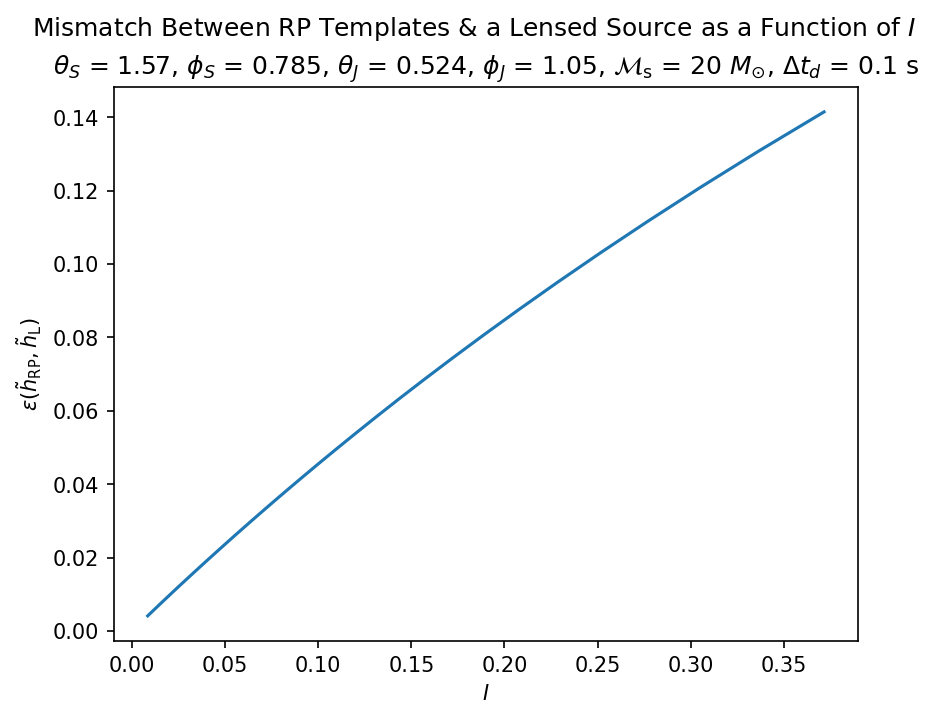

In [35]:
I_ep_min_arr = np.array([mismatch_I_dict[I]["ep_min"] for I in I_arr])

plt.plot(I_arr, I_ep_min_arr, label=r"$\epsilon(\~h_{\rm RP}, \~h_{\rm L})$")
plt.xlabel(r"$I$")
plt.ylabel(r"$\epsilon(\~h_{\rm RP}, \~h_{\rm L})$")

plt.title(
    r"$\theta_S$ = {:.3g}, $\phi_S$ = {:.3g}, $\theta_J$ = {:.3g}, $\phi_J$ = {:.3g}, {} = {:.3g} {}, $\Delta t_d$ = {:.3g} s".format(
        lens_params["theta_S"],
        lens_params["phi_S"],
        lens_params["theta_J"],
        lens_params["phi_J"],
        r"$\mathcal{M}_{\text{s}}$",
        lens_params["mcz"] / solar_mass,
        r"$M_{\odot}$",
        time_delay,
    )
)

plt.suptitle(r"Mismatch Between RP Templates & a Lensed Source as a Function of $I$")

plt.show()

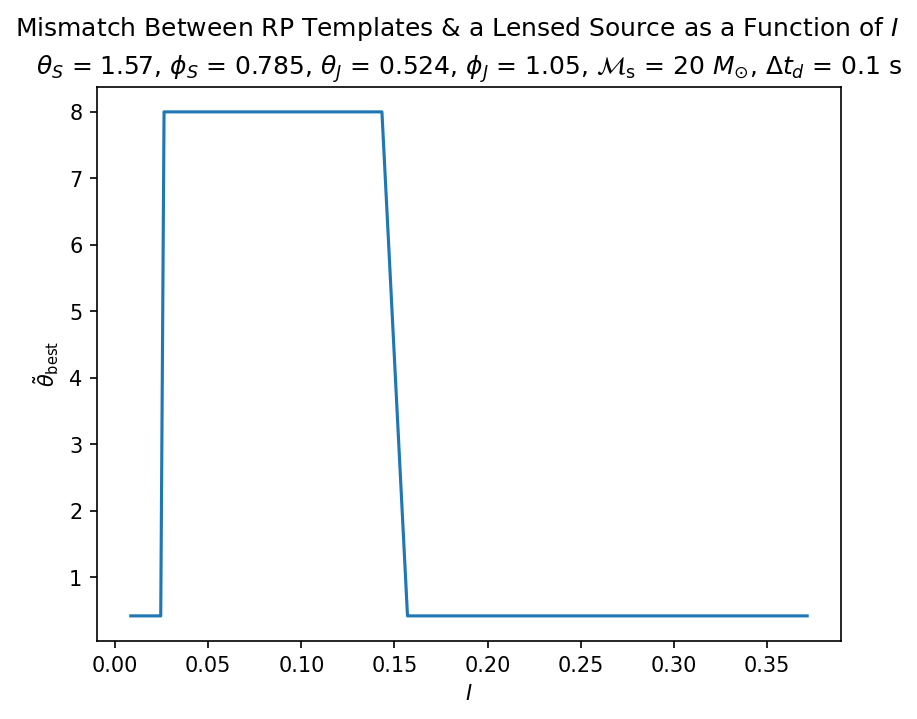

In [36]:
I_ep_min_theta_tilde_arr = np.array(
    [mismatch_I_dict[I]["ep_min_theta_tilde"] for I in I_arr]
)

plt.plot(I_arr, I_ep_min_theta_tilde_arr, label=r"$\~{\theta}_{\rm best}$")
plt.xlabel(r"$I$")
plt.ylabel(r"$\~{\theta}_{\rm best}$")

plt.title(
    r"$\theta_S$ = {:.3g}, $\phi_S$ = {:.3g}, $\theta_J$ = {:.3g}, $\phi_J$ = {:.3g}, {} = {:.3g} {}, $\Delta t_d$ = {:.3g} s".format(
        lens_params["theta_S"],
        lens_params["phi_S"],
        lens_params["theta_J"],
        lens_params["phi_J"],
        r"$\mathcal{M}_{\text{s}}$",
        lens_params["mcz"] / solar_mass,
        r"$M_{\odot}$",
        time_delay,
    )
)

plt.suptitle(r"Mismatch Between RP Templates & a Lensed Source as a Function of $I$")

plt.show()

# waveform comparison

idx = -2.2698e-09, phi = -3.98978e-08, both should be ~0 if get_updated_mismatch_results is True


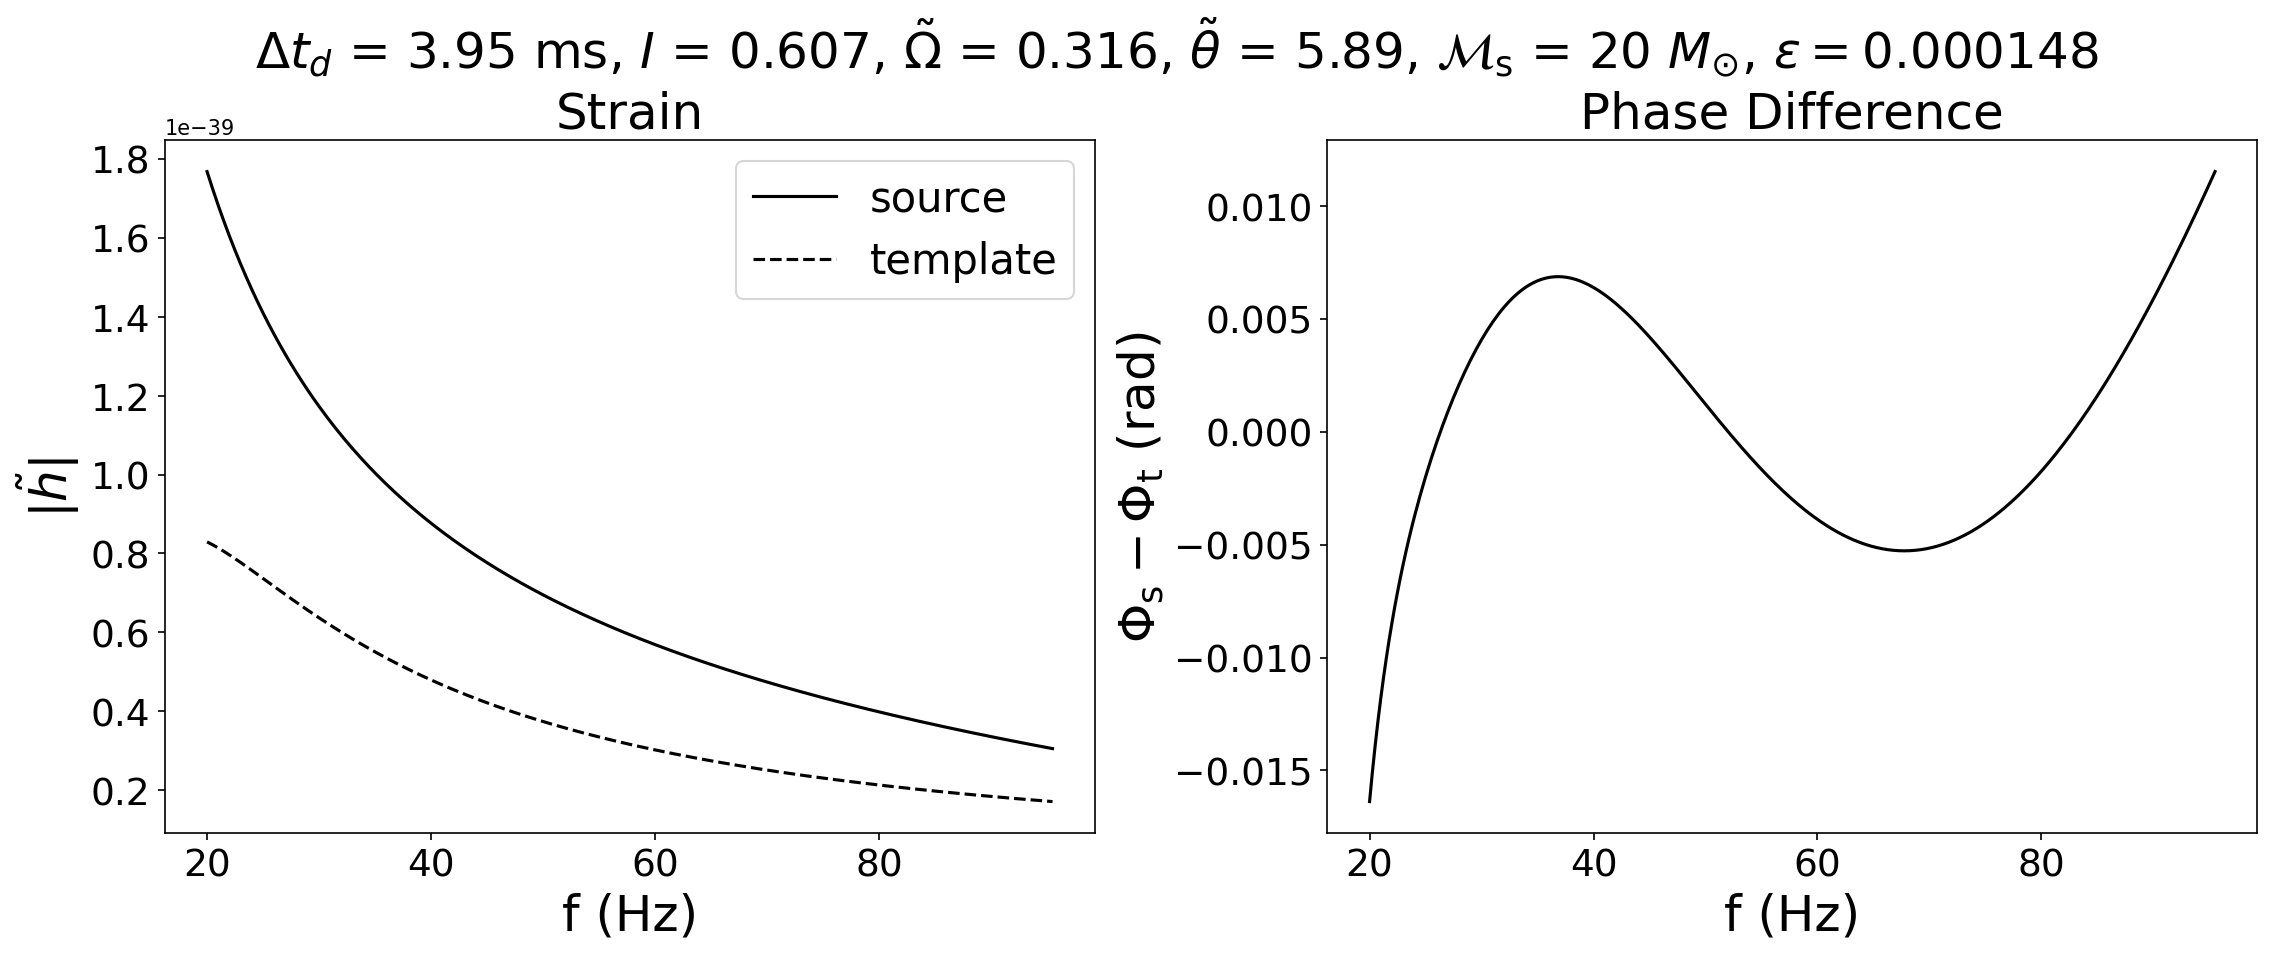

idx = 1.94404e-09, phi = 2.05009e-08, both should be ~0 if get_updated_mismatch_results is True


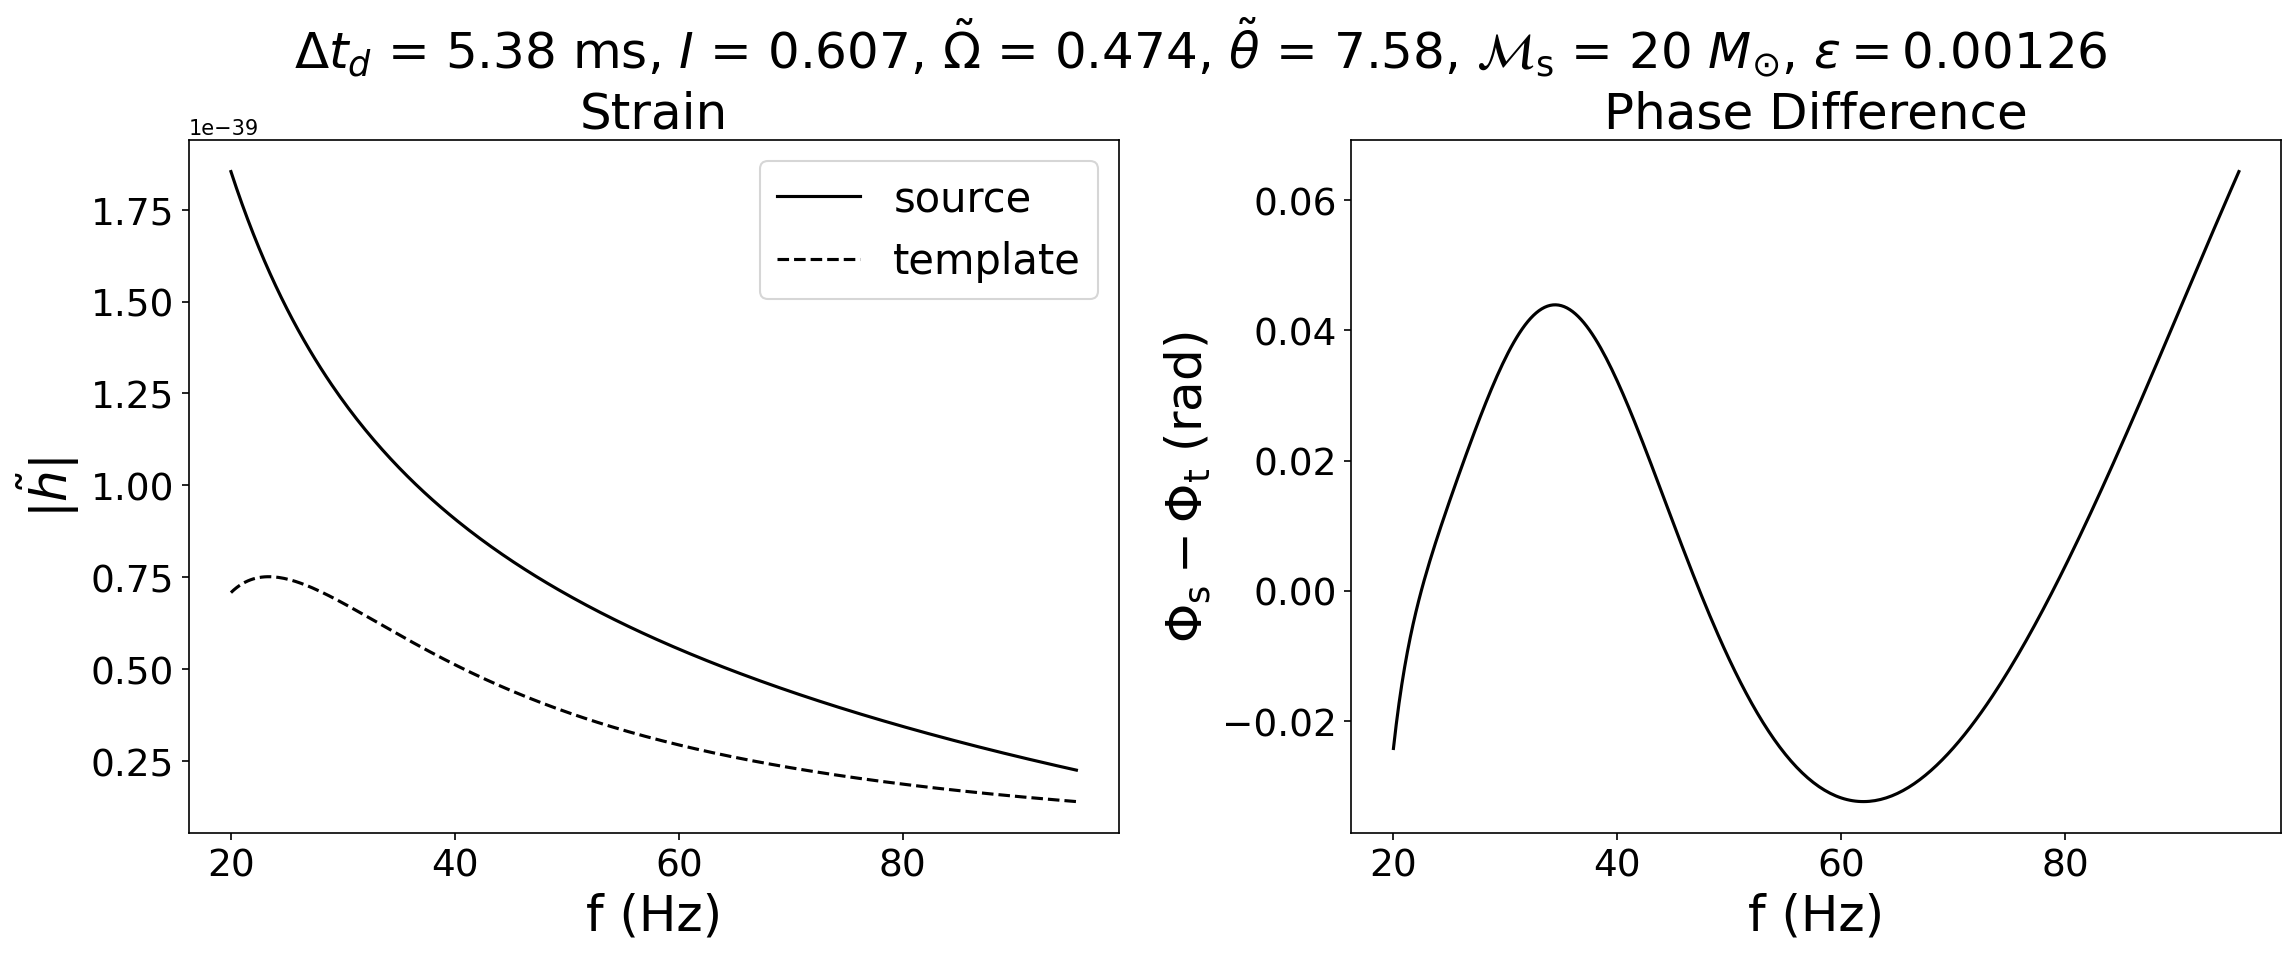

idx = -3.77877e-09, phi = 1.15953e-08, both should be ~0 if get_updated_mismatch_results is True


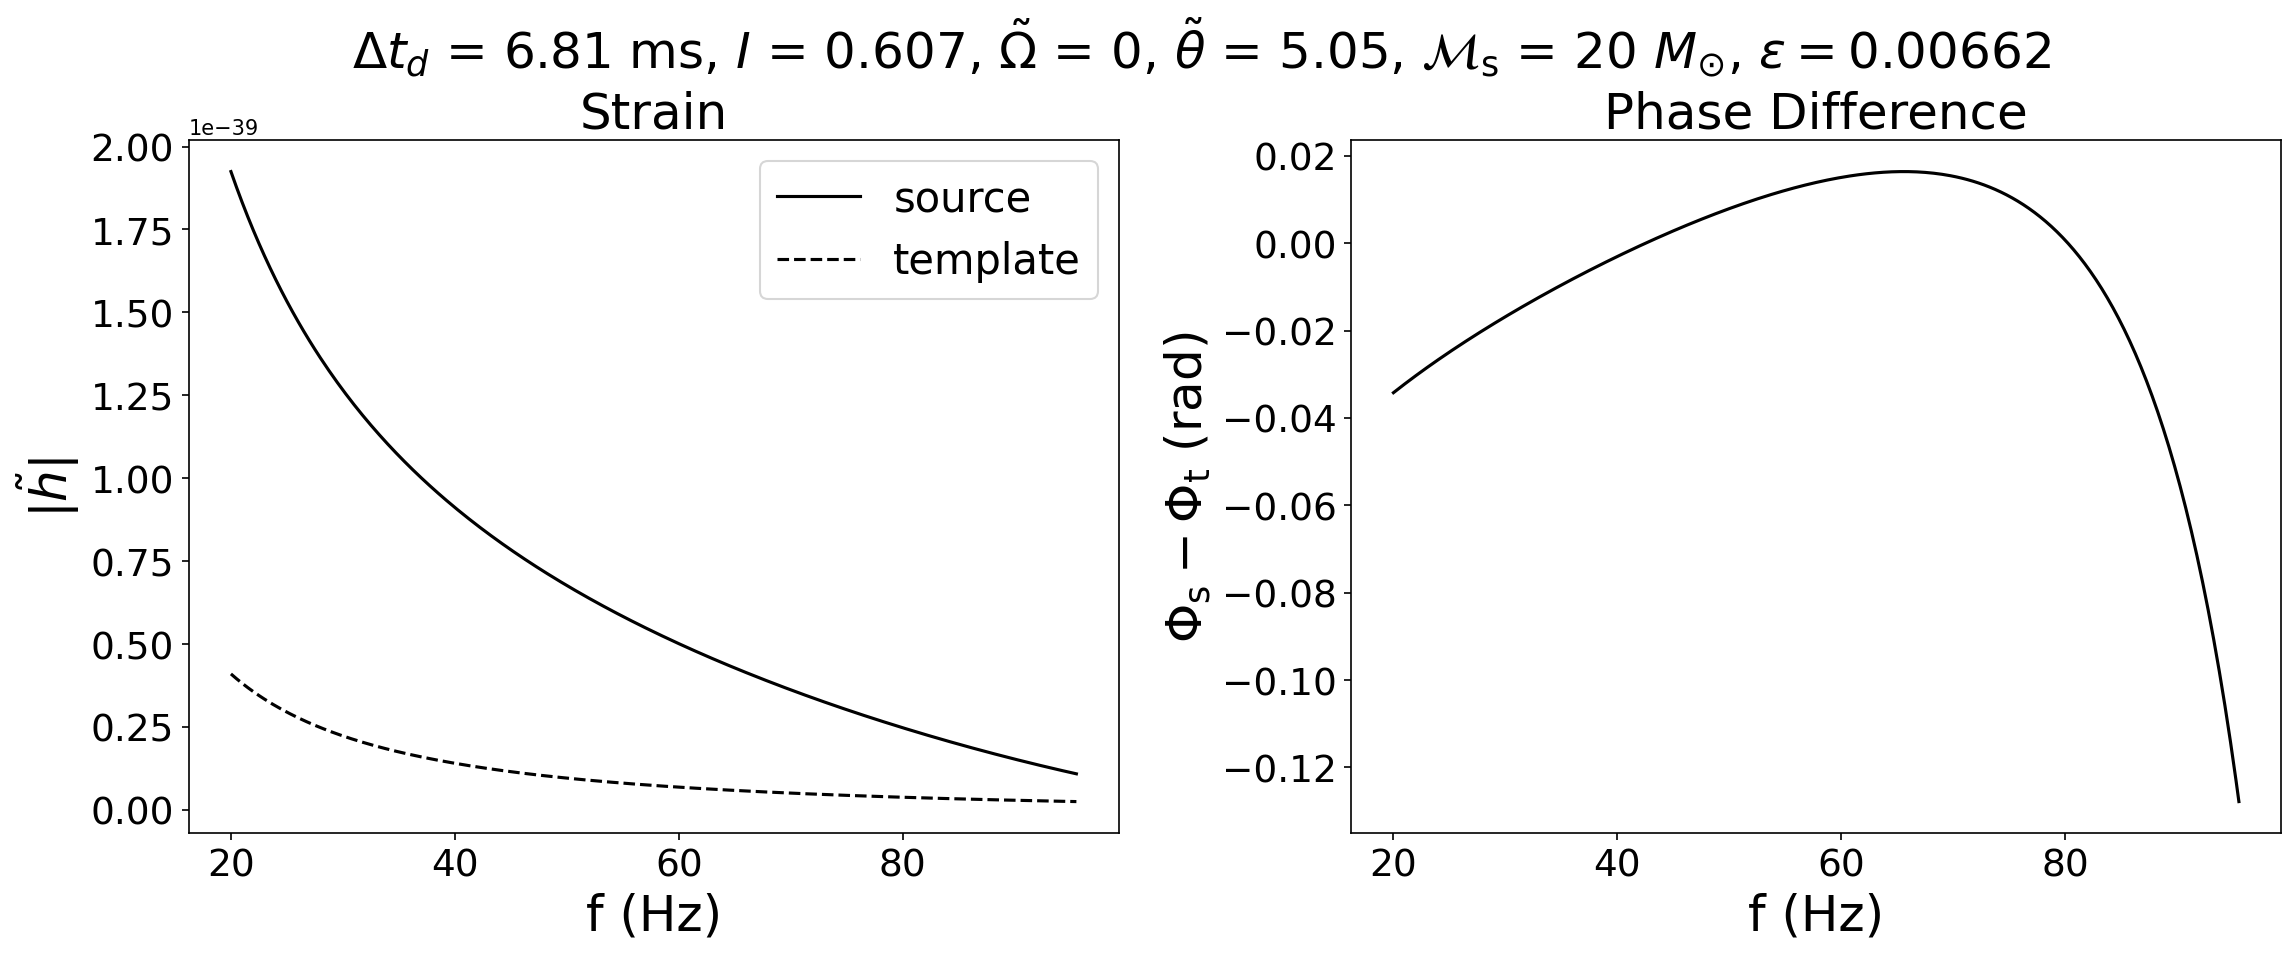

idx = 1.47405e-08, phi = -5.49066e-09, both should be ~0 if get_updated_mismatch_results is True


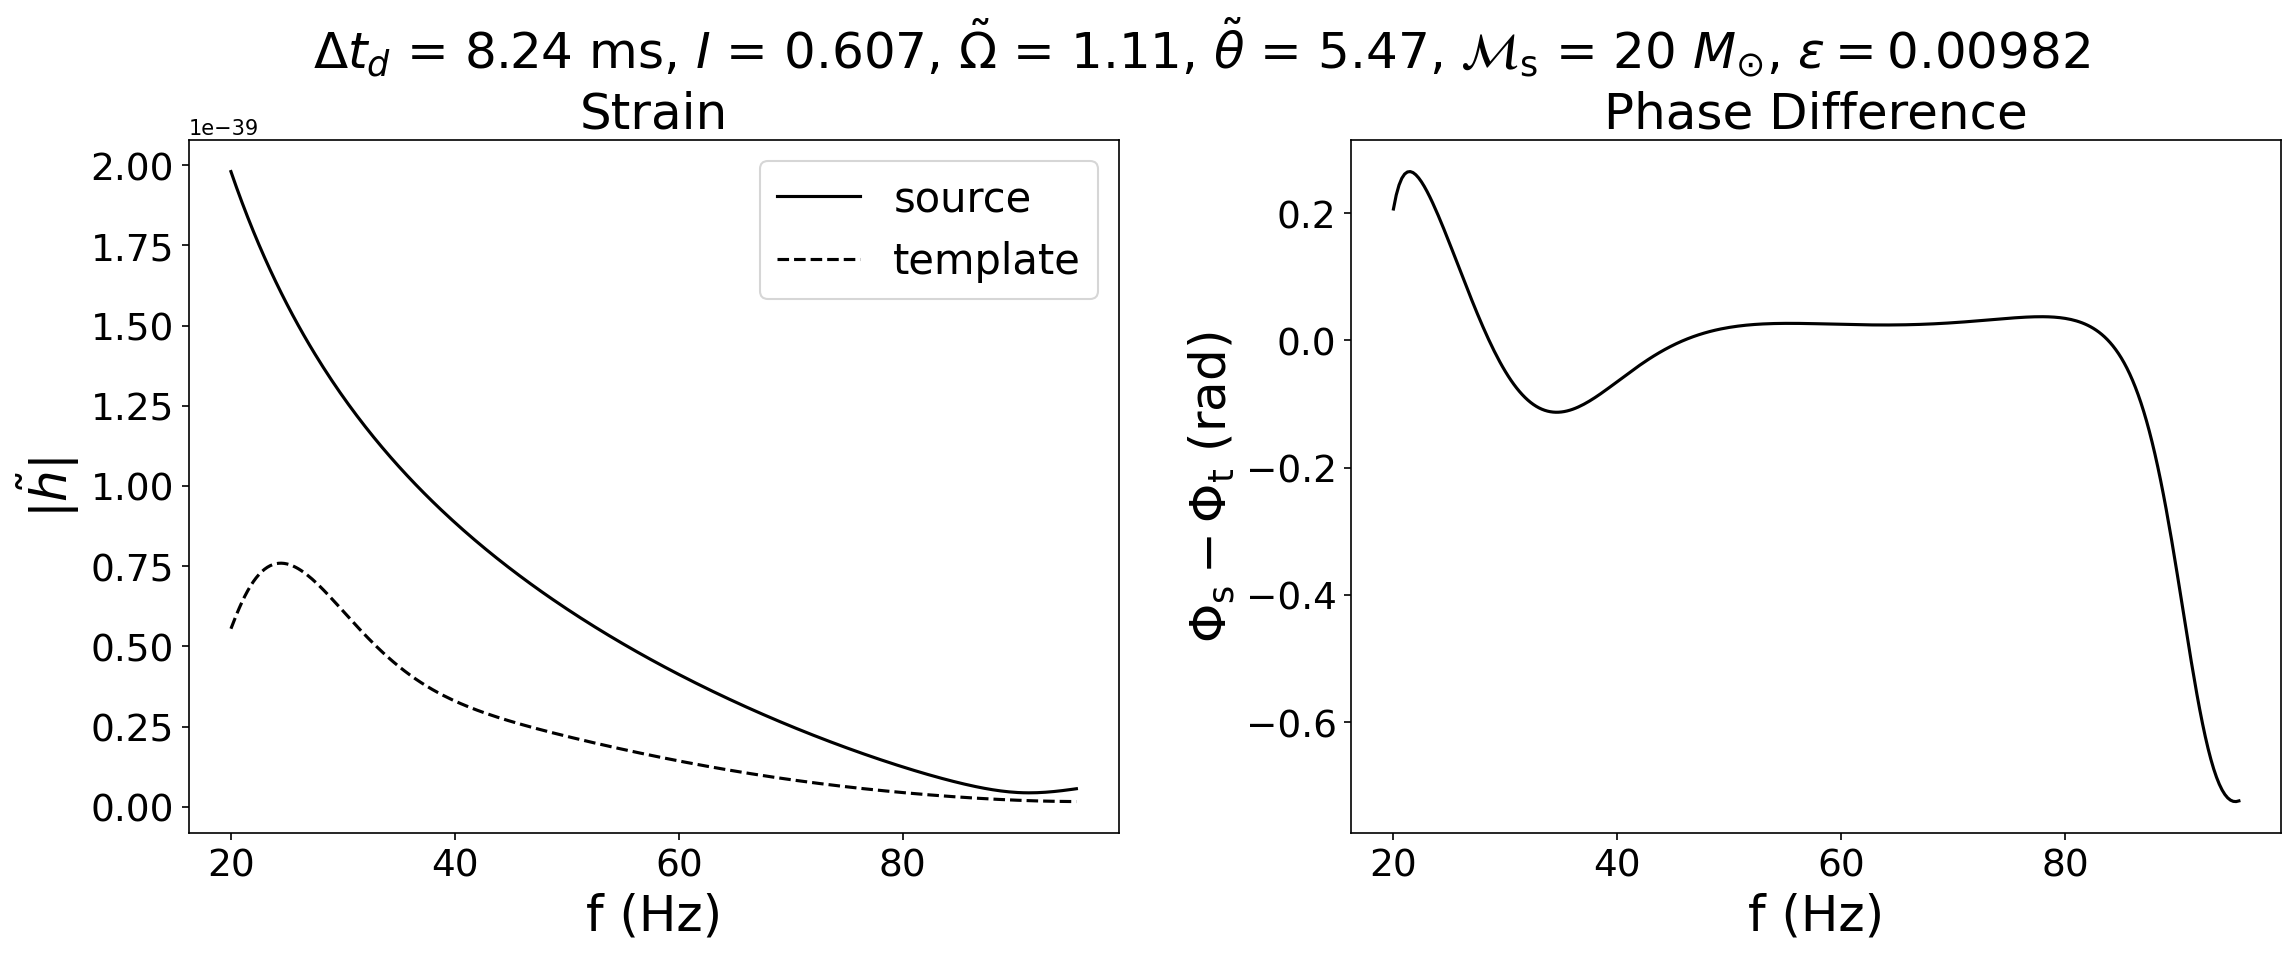

idx = -9.38672e-09, phi = 7.92471e-09, both should be ~0 if get_updated_mismatch_results is True


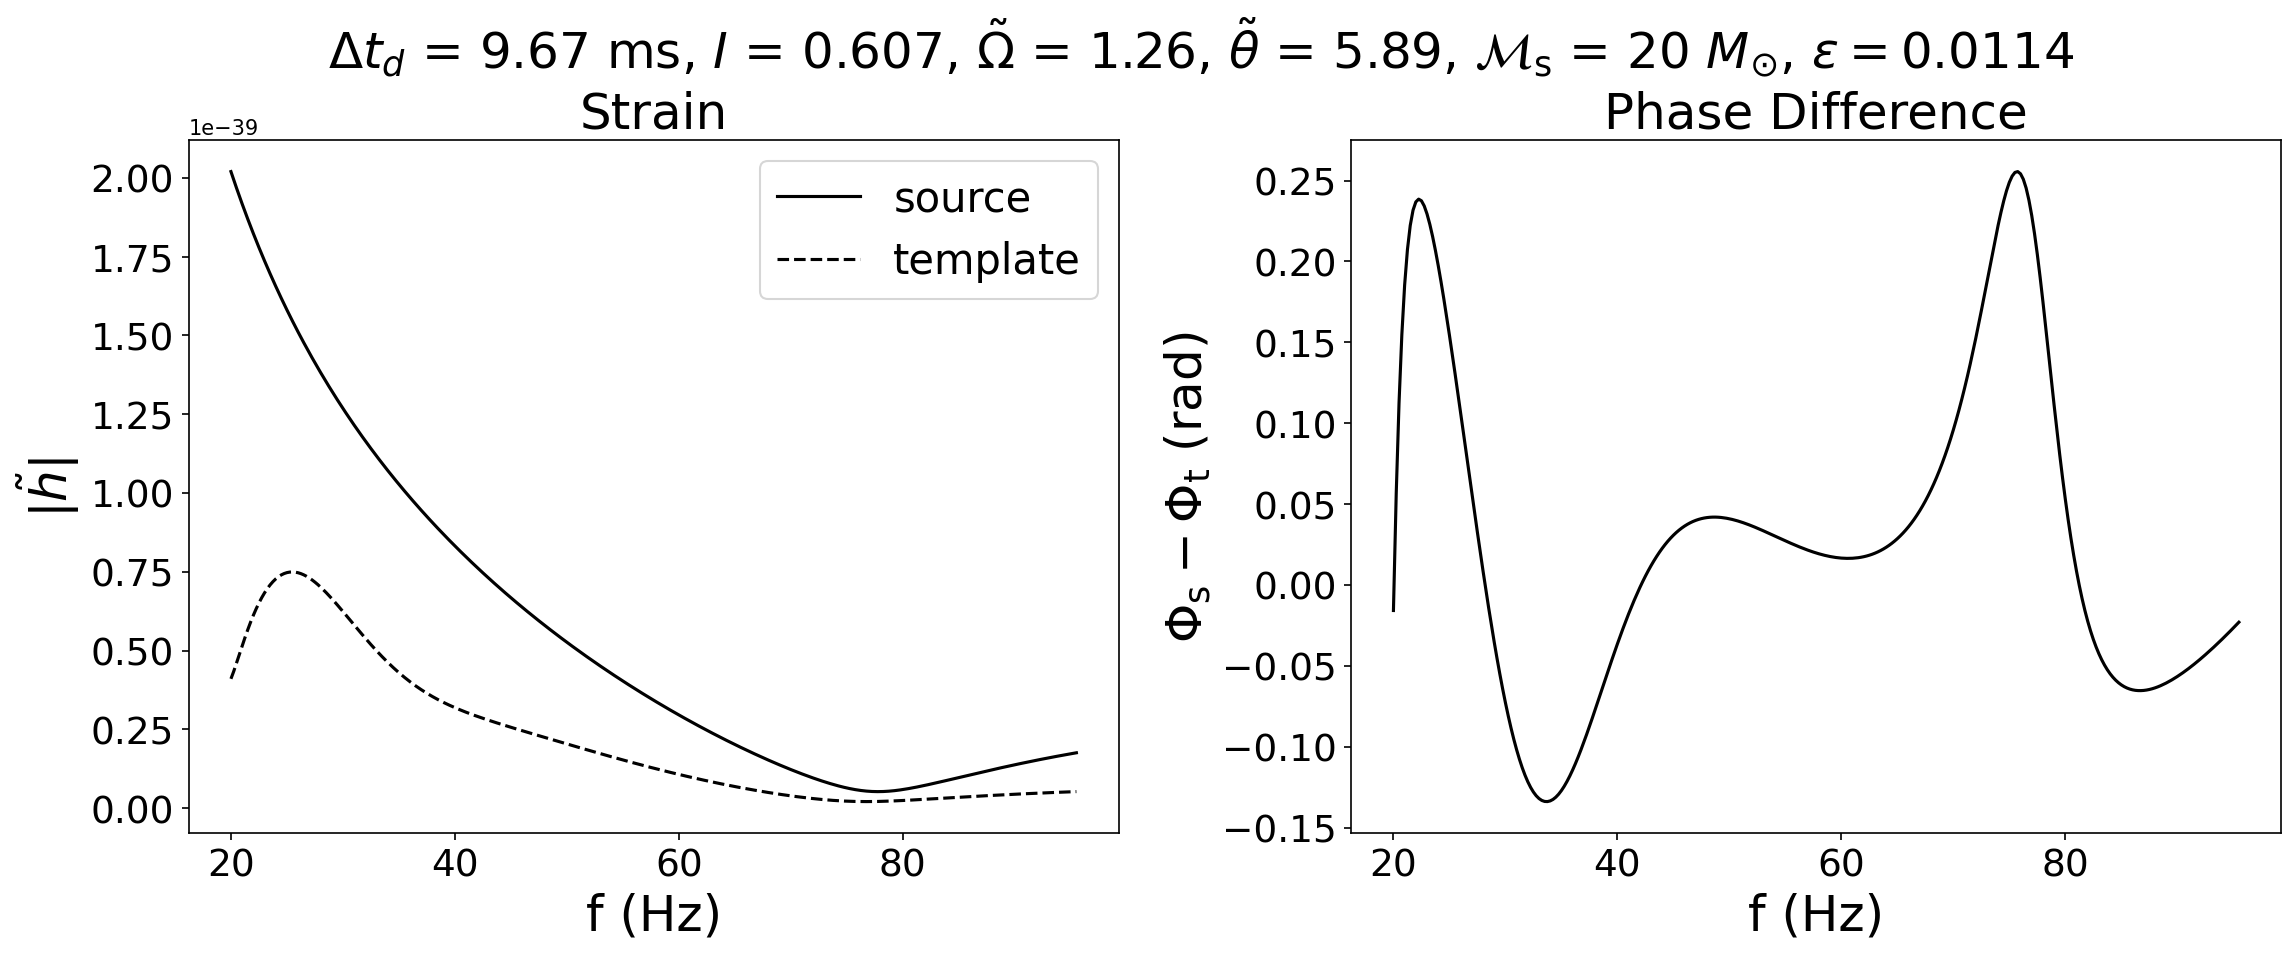

idx = -3.09089e-09, phi = 1.76909e-08, both should be ~0 if get_updated_mismatch_results is True


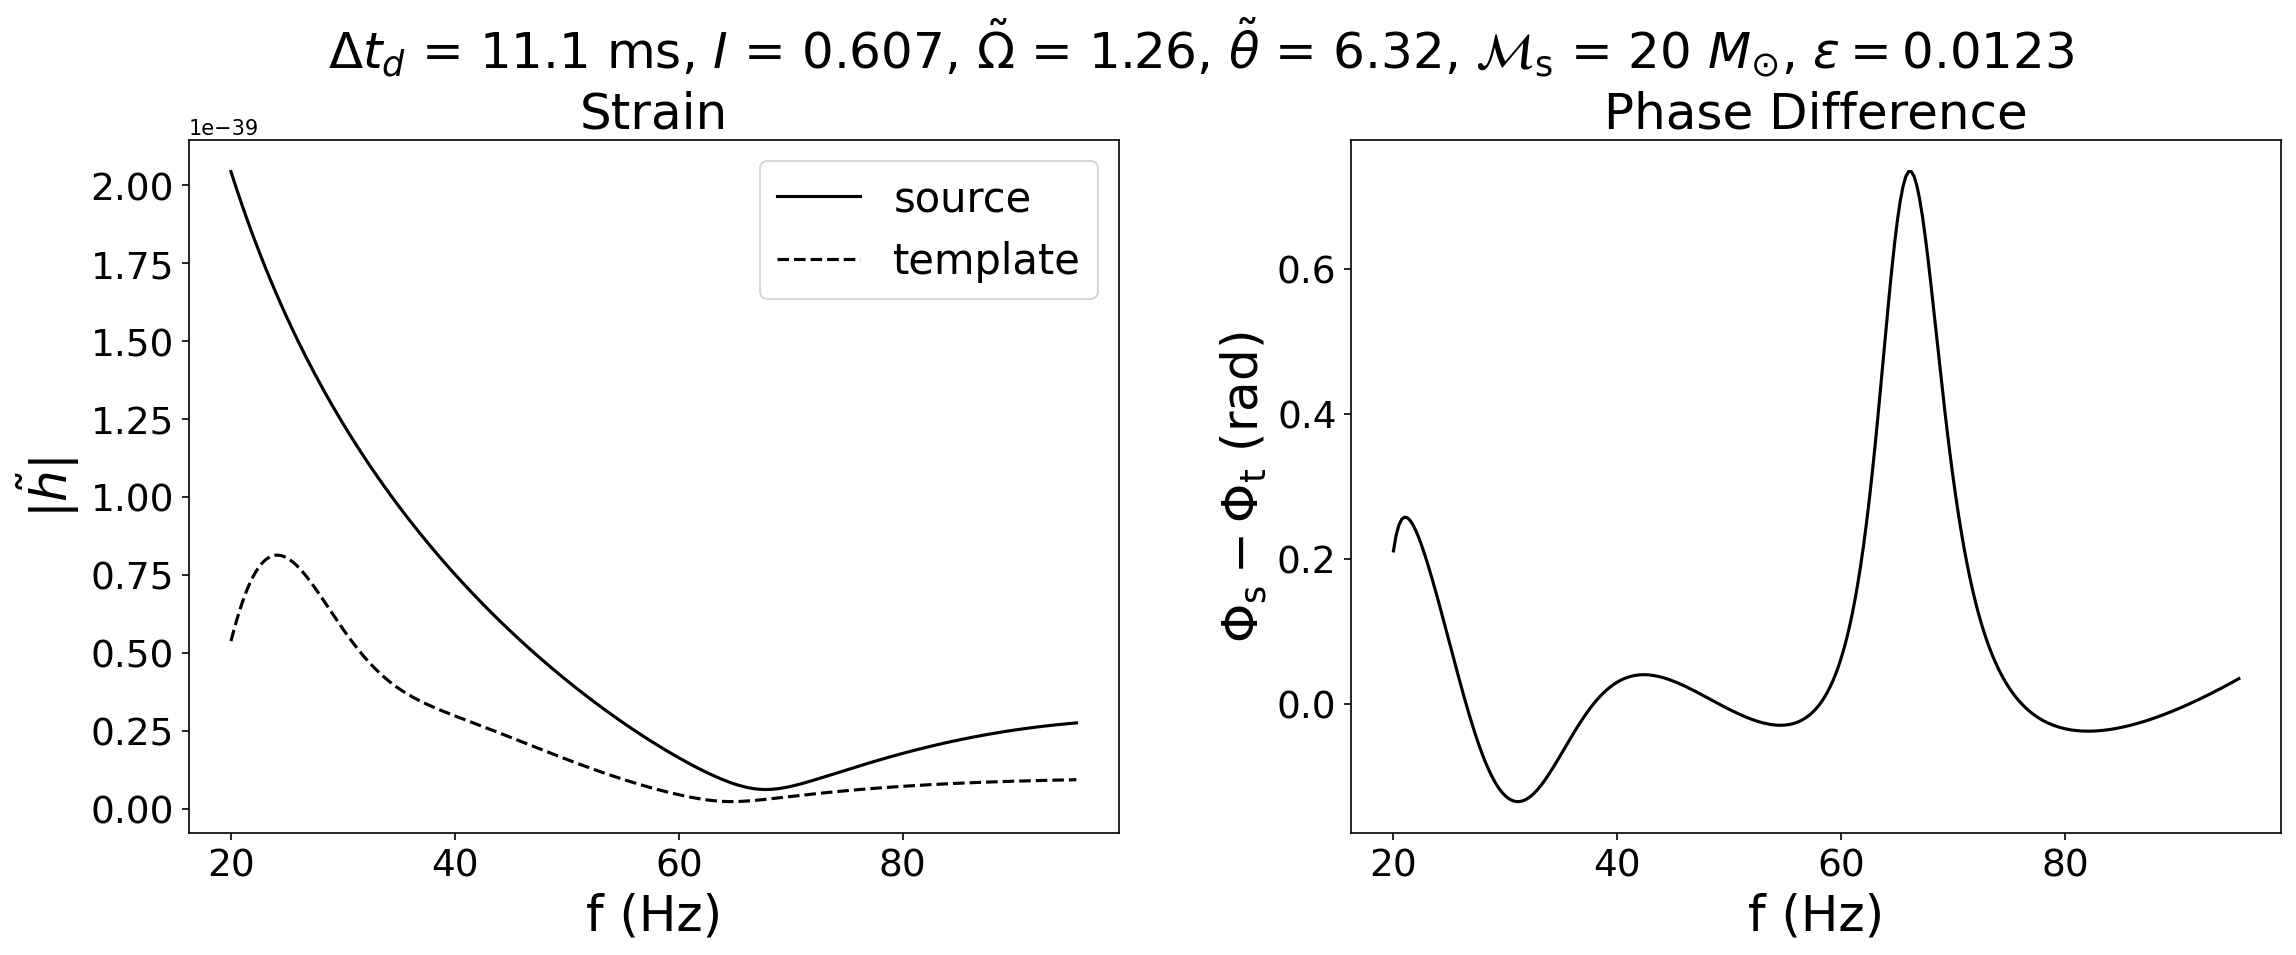

idx = -7.45377e-09, phi = 4.21967e-08, both should be ~0 if get_updated_mismatch_results is True


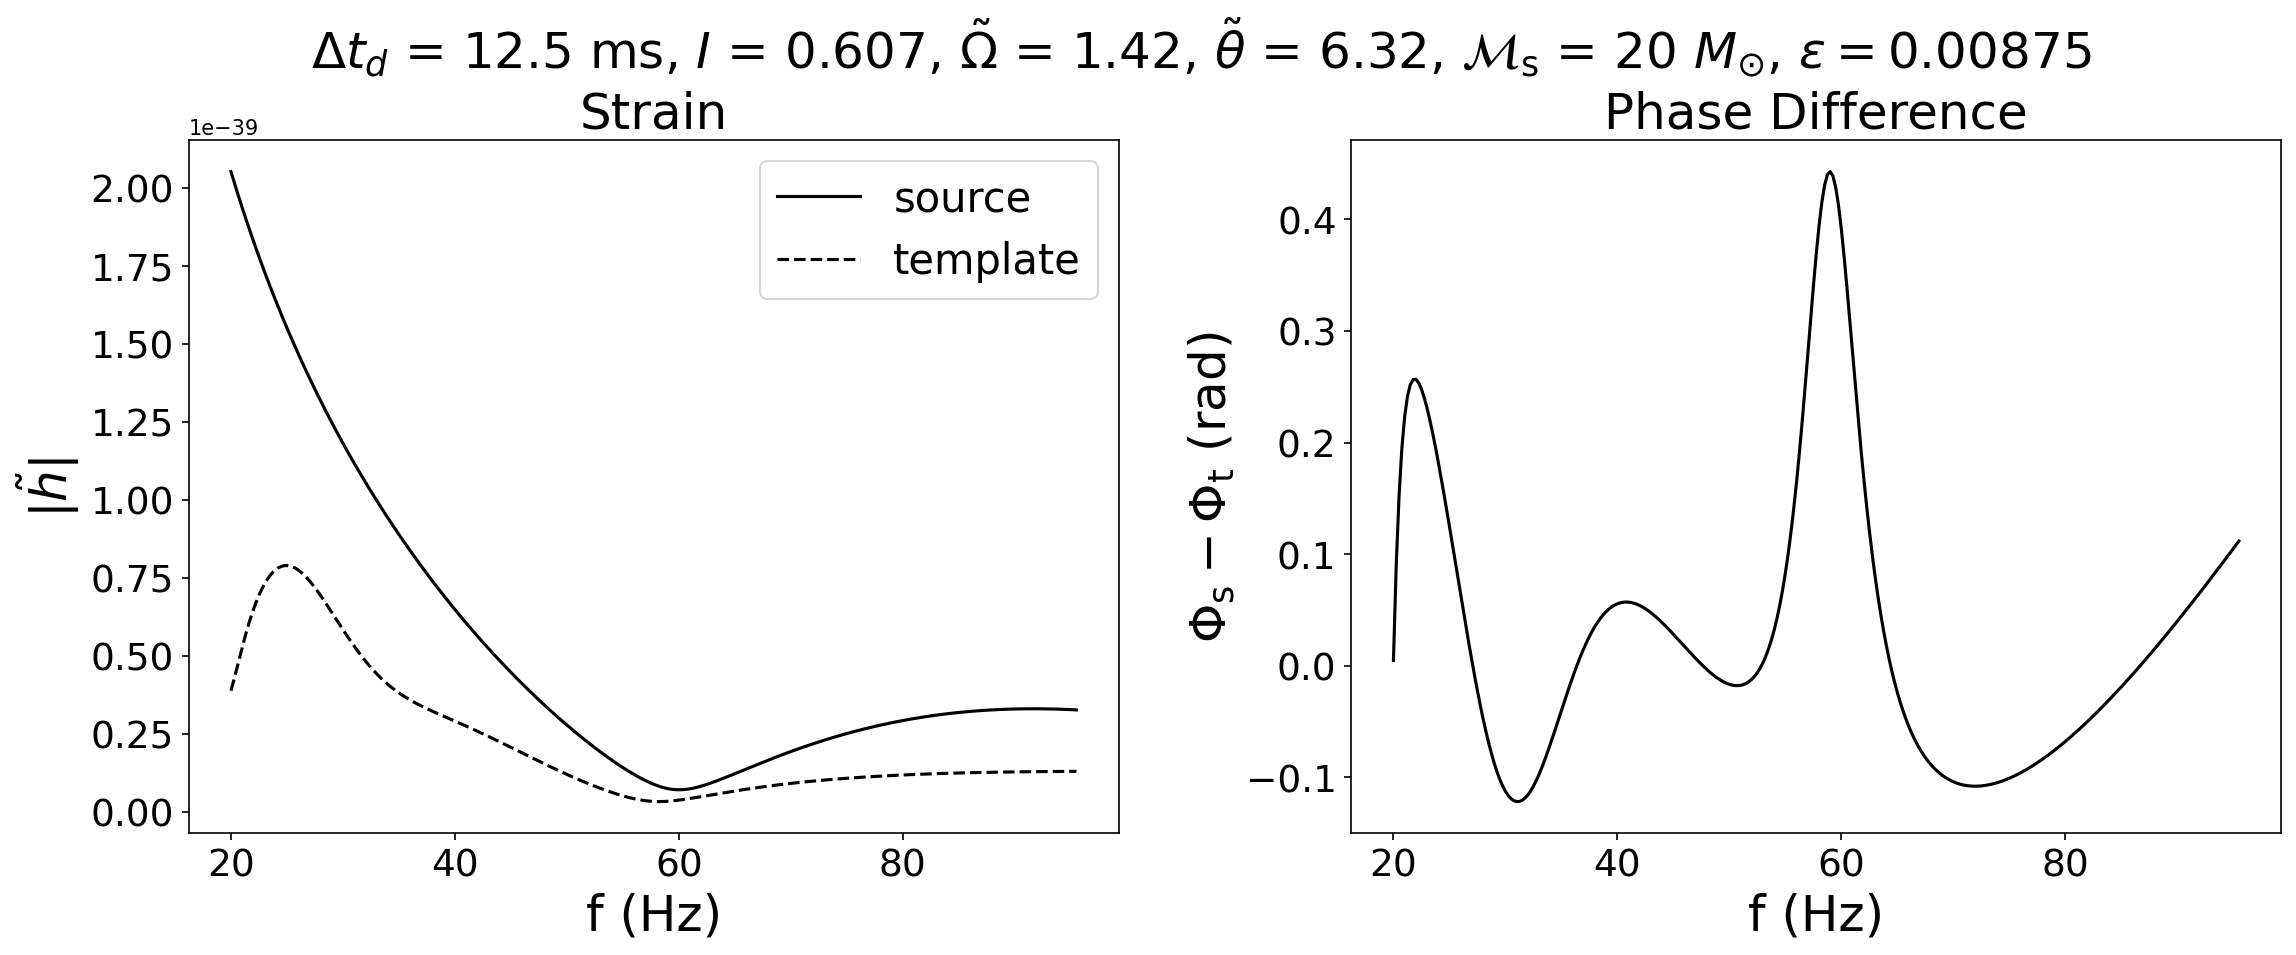

idx = -1.95909e-09, phi = 3.21276e-09, both should be ~0 if get_updated_mismatch_results is True


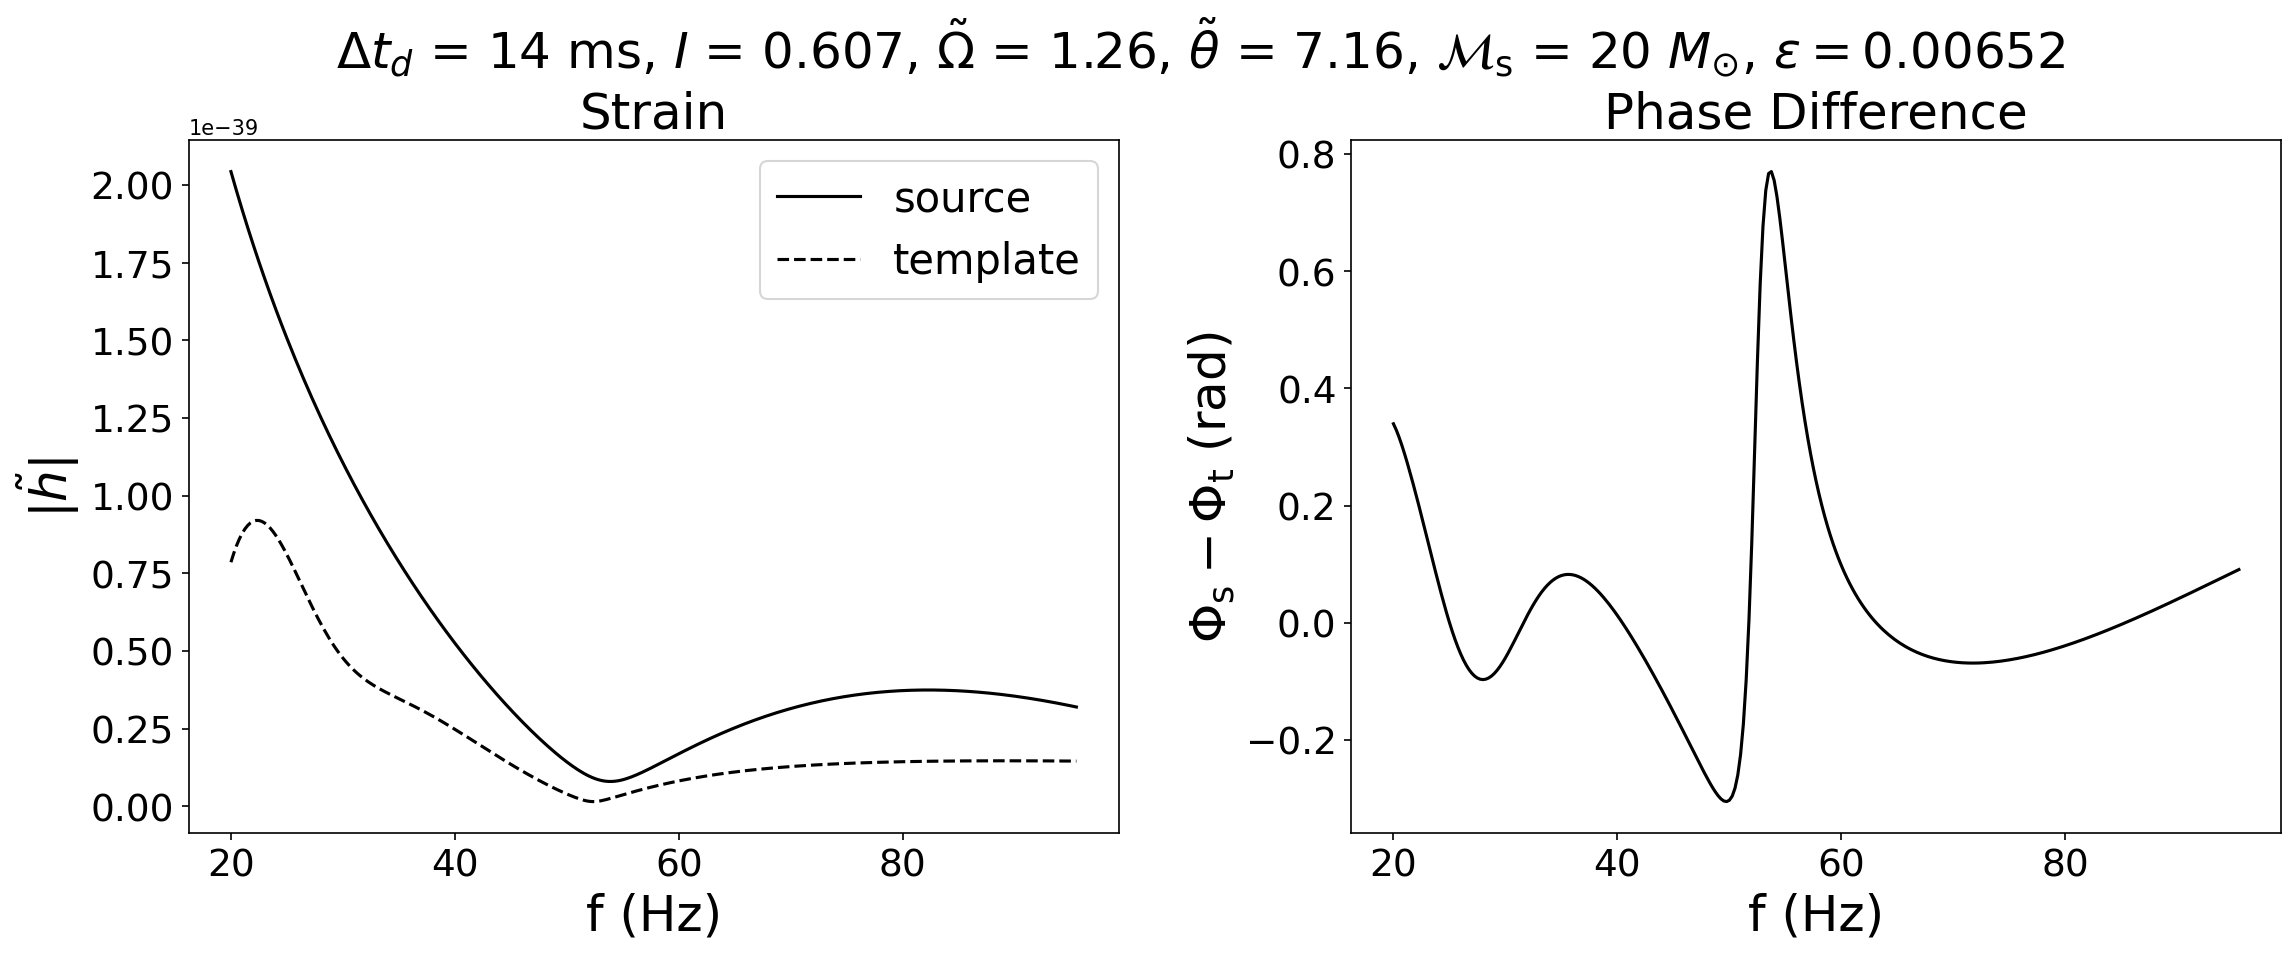

idx = -1.40903e-08, phi = 5.50417e-08, both should be ~0 if get_updated_mismatch_results is True


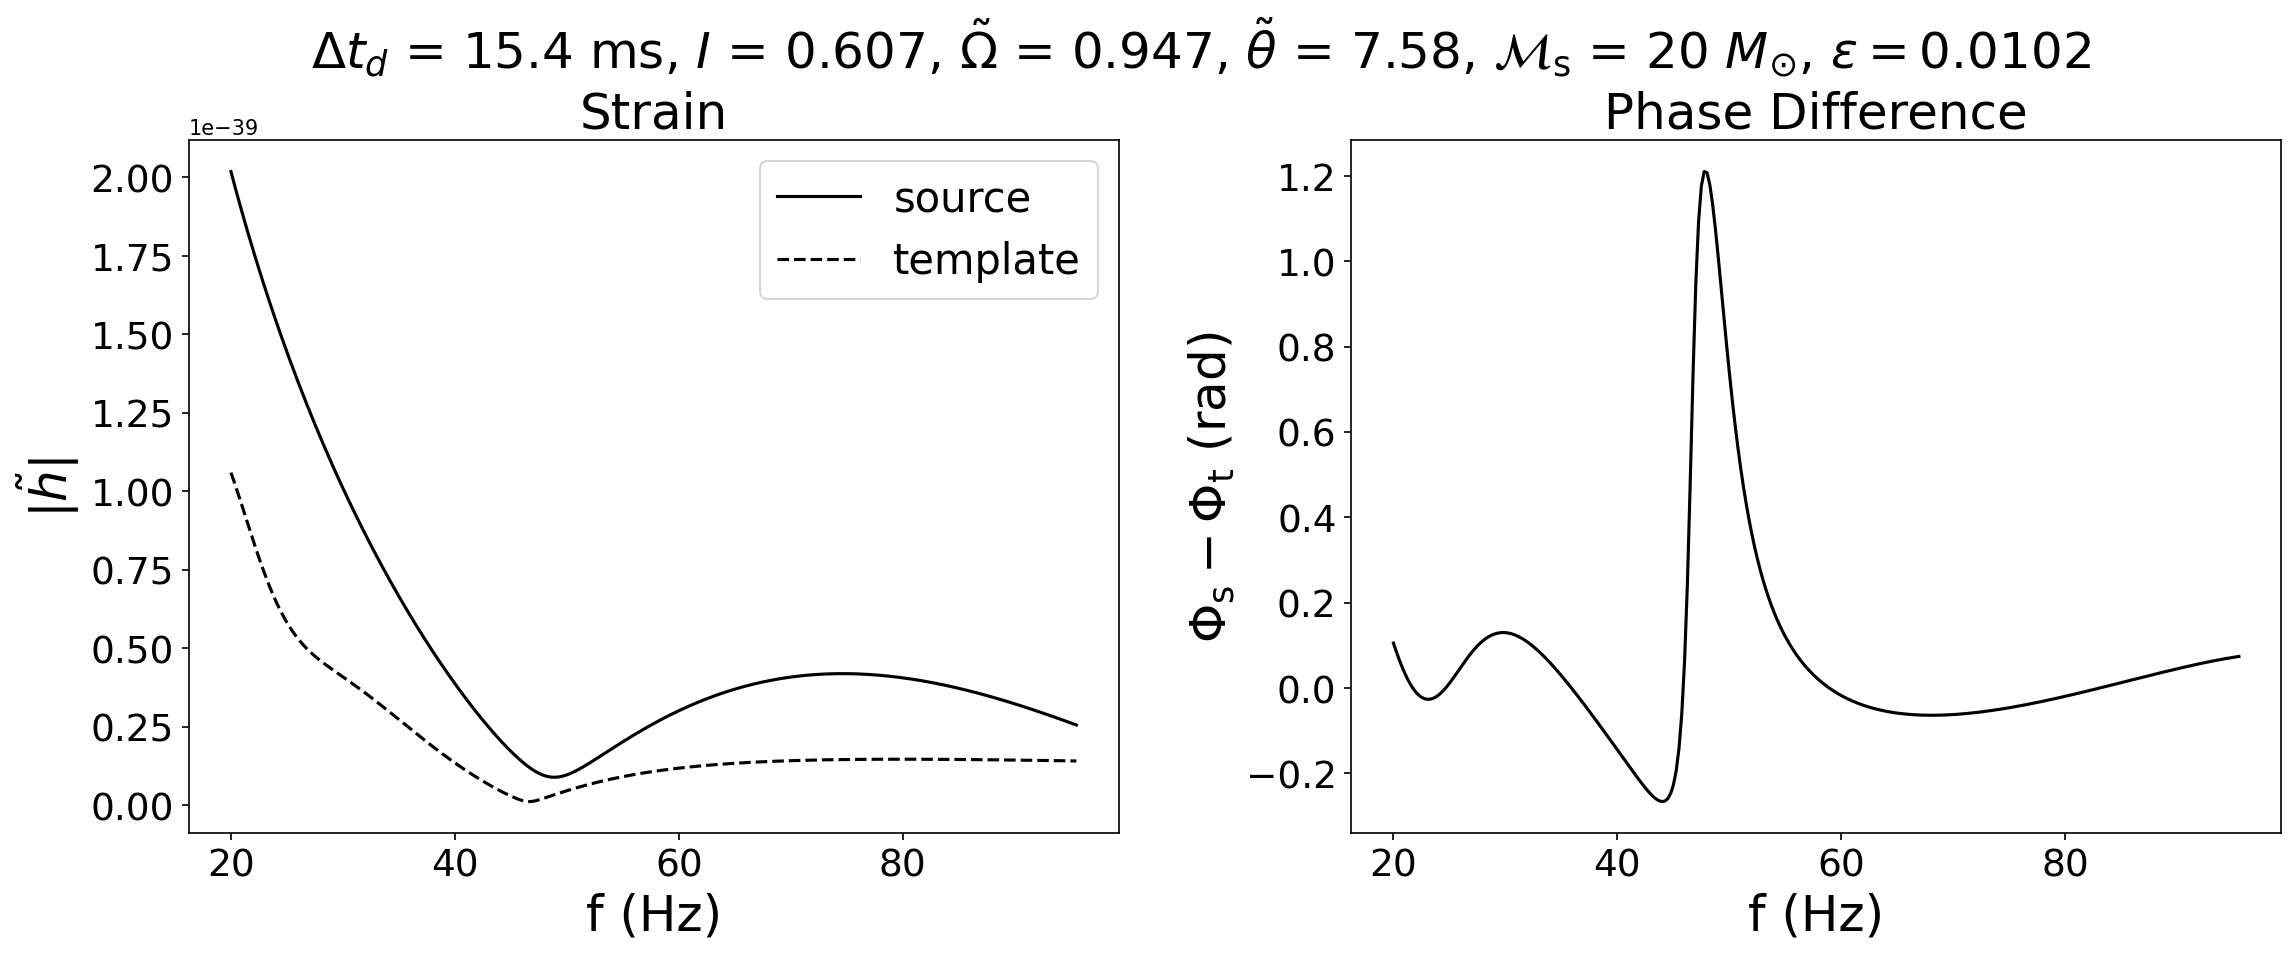

idx = 2.17989e-08, phi = -4.63113e-08, both should be ~0 if get_updated_mismatch_results is True


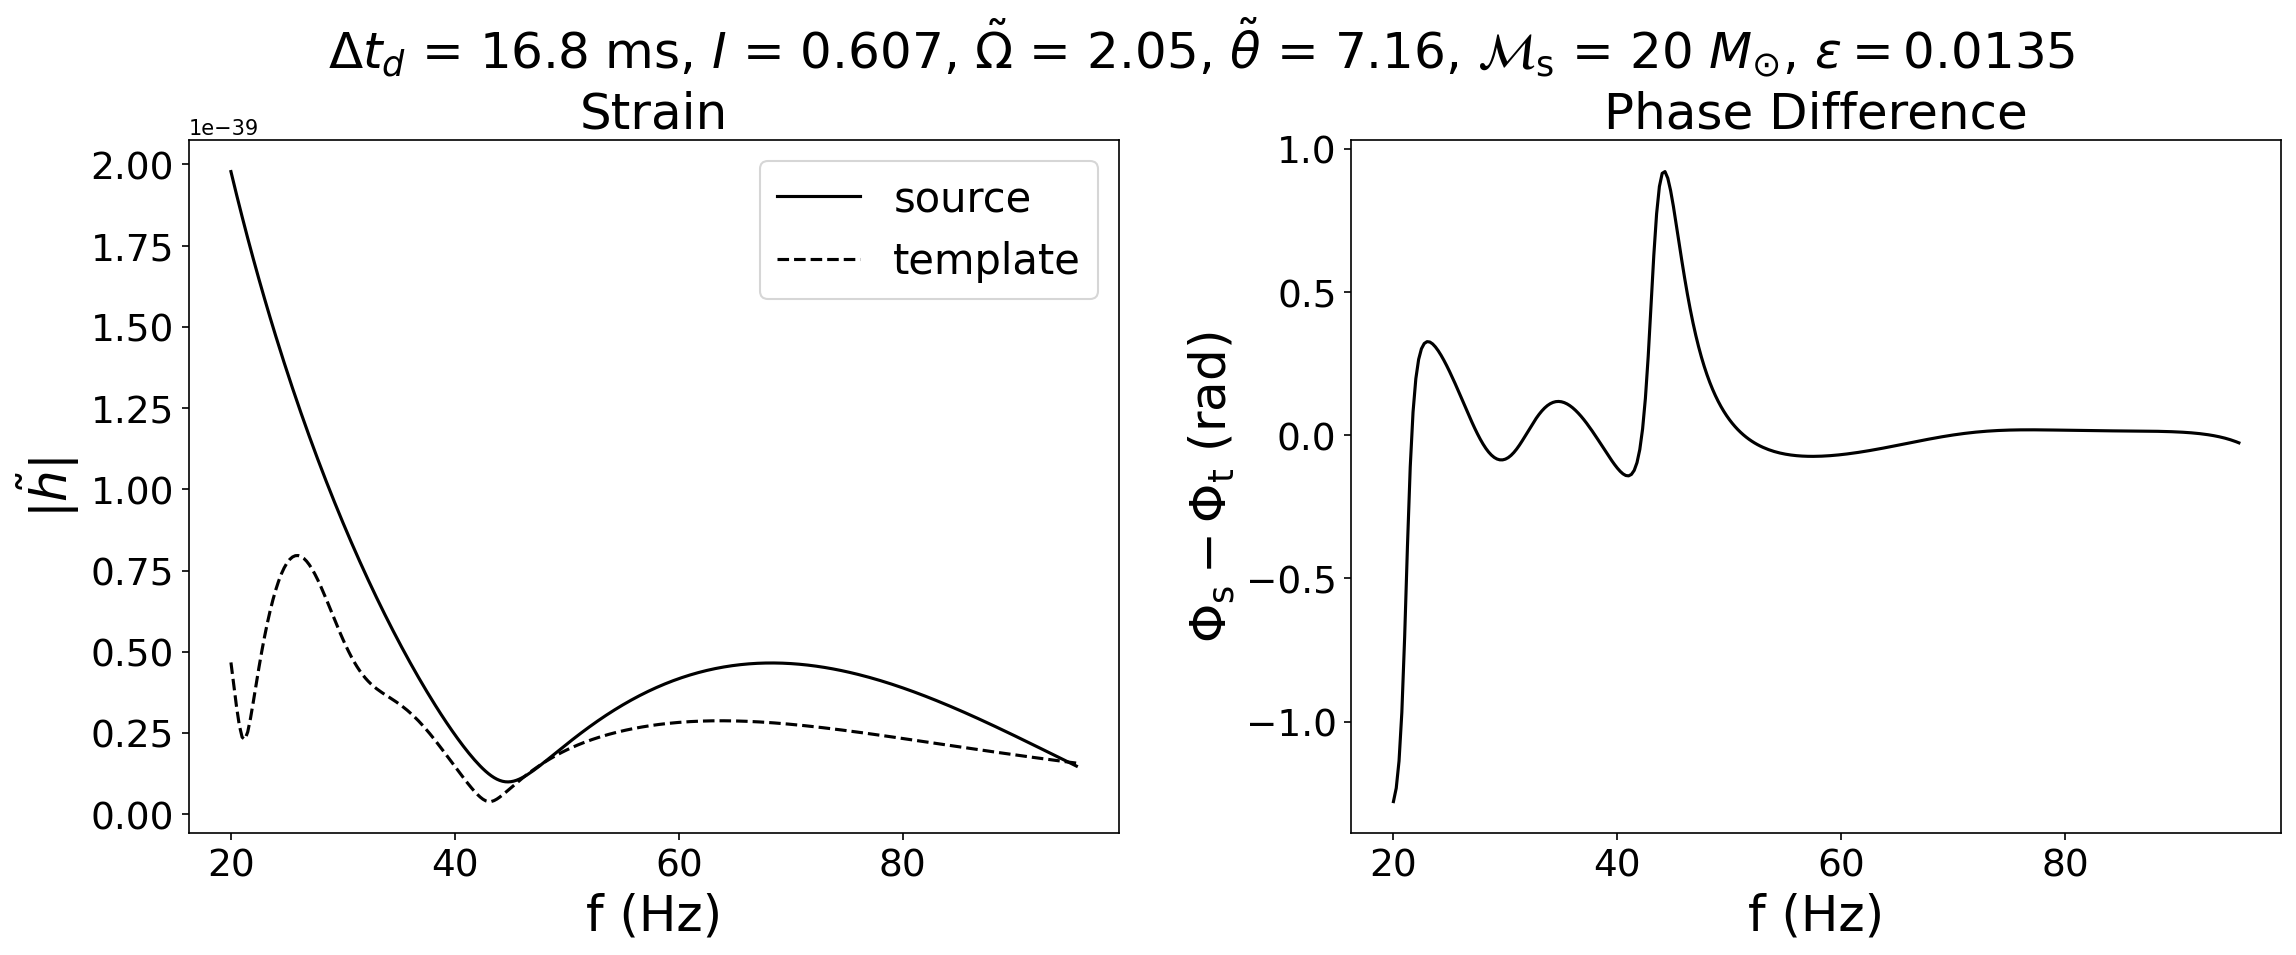

idx = 3.7995e-09, phi = 1.92596e-08, both should be ~0 if get_updated_mismatch_results is True


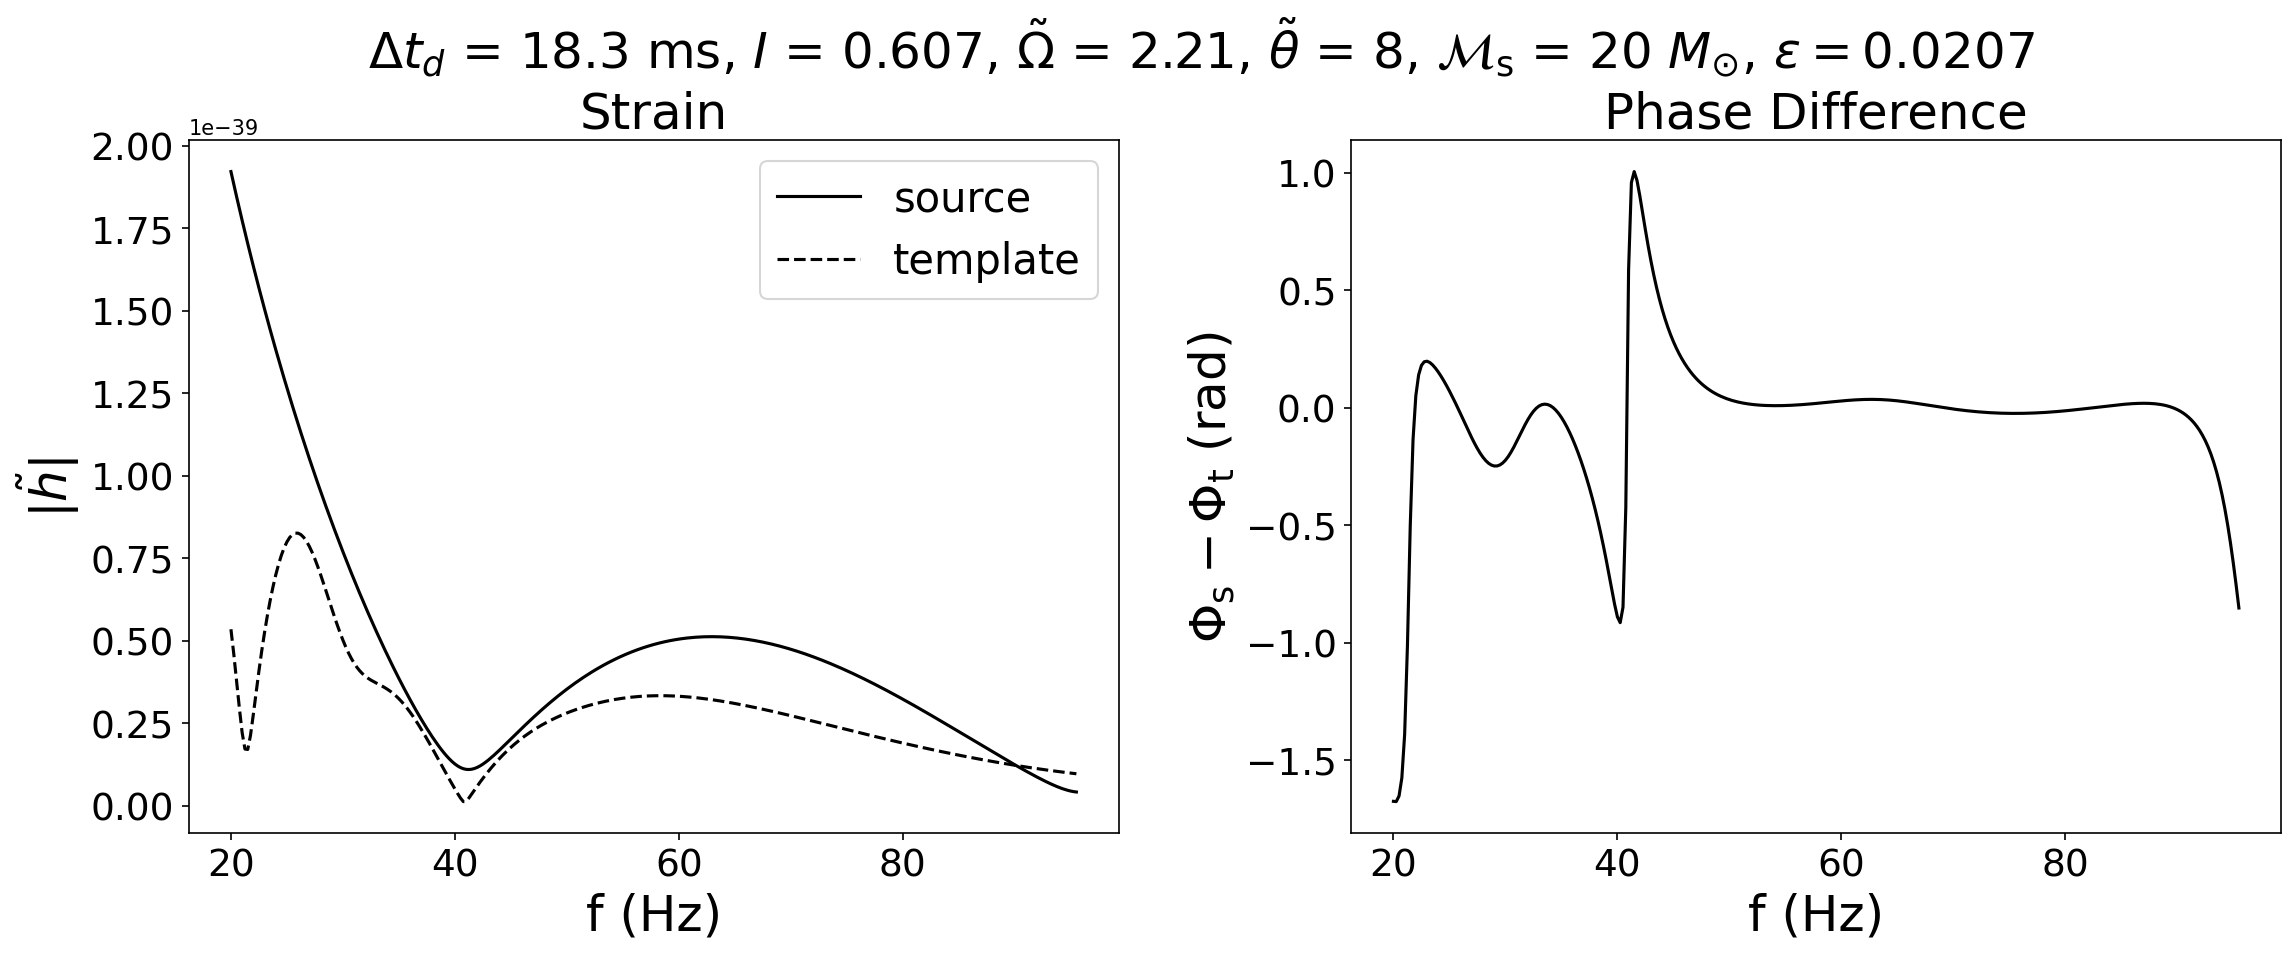

idx = -1.35783e-08, phi = 2.57646e-08, both should be ~0 if get_updated_mismatch_results is True


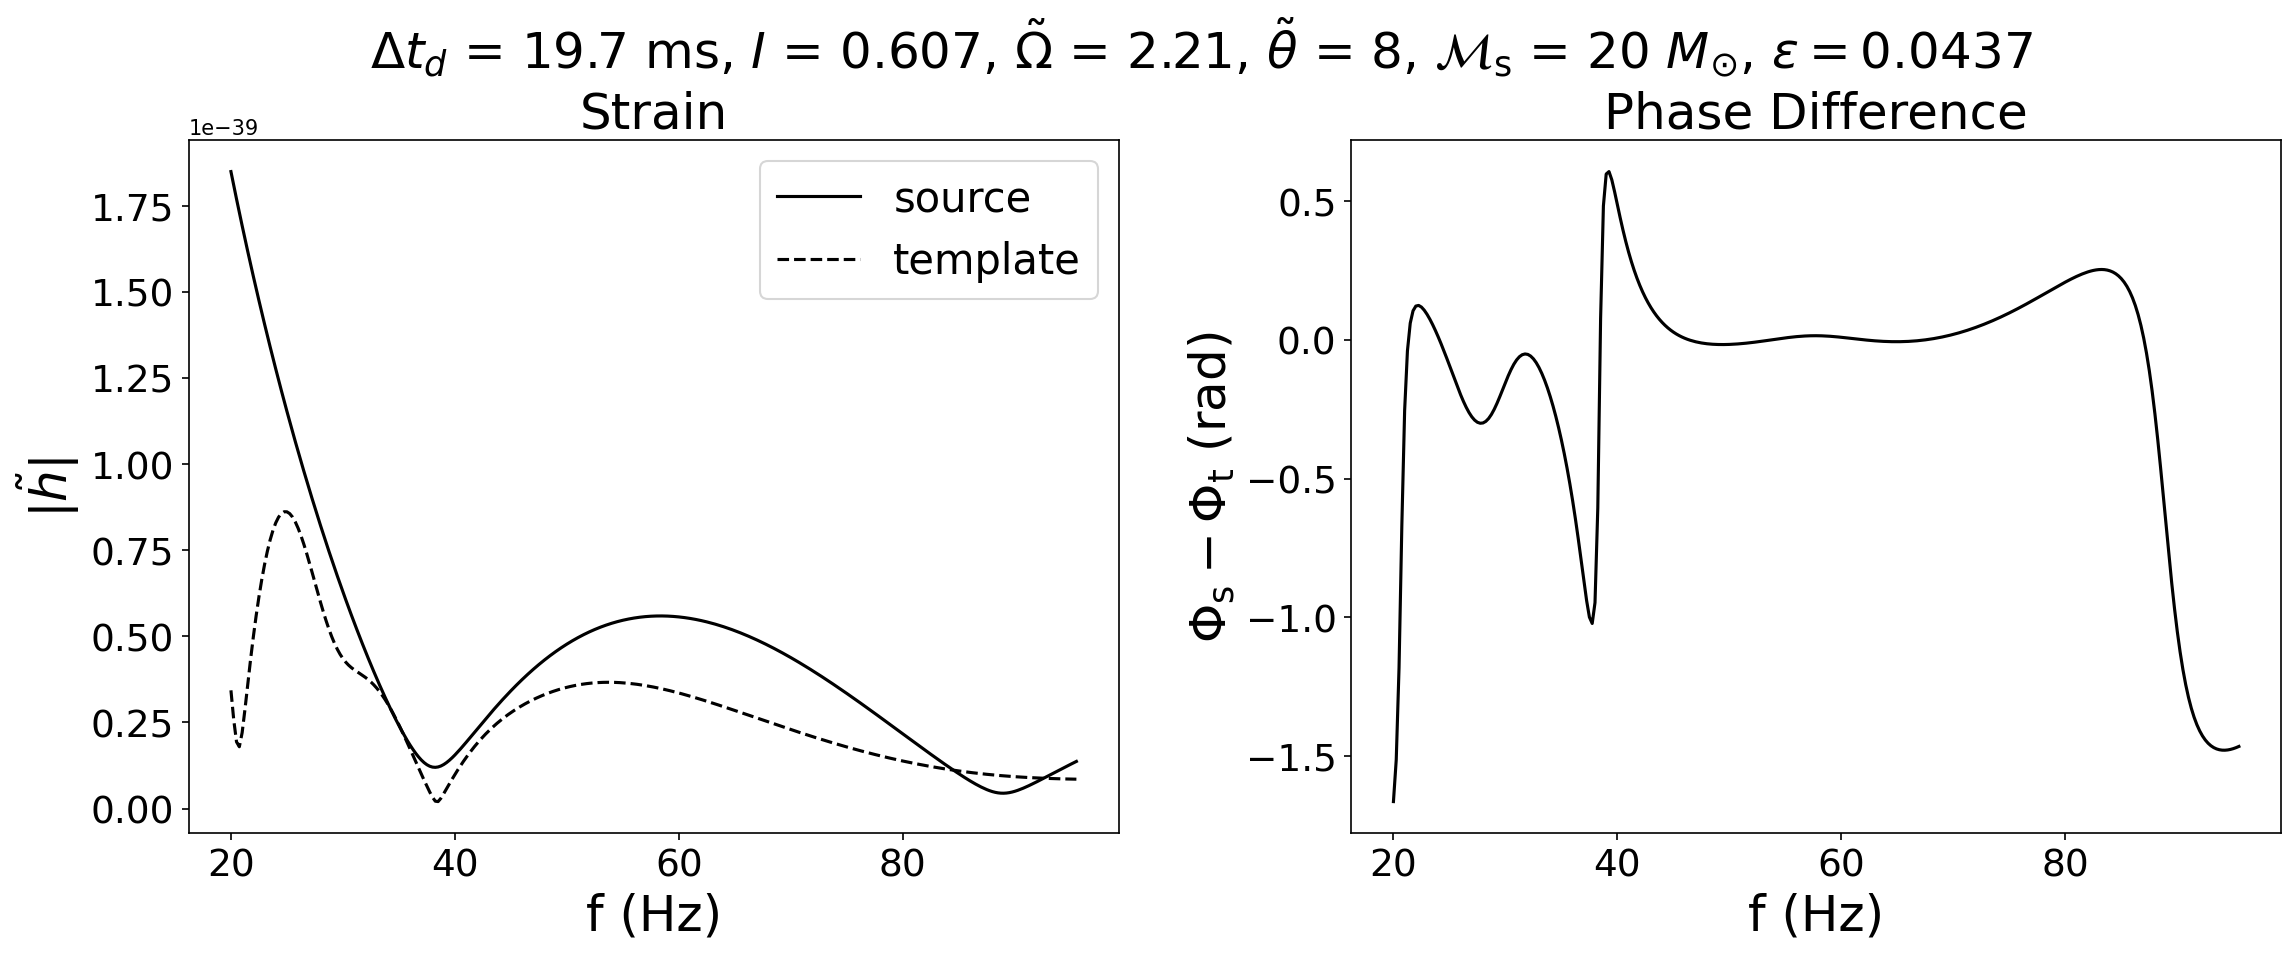

idx = 2.36862e-08, phi = 2.32791e-08, both should be ~0 if get_updated_mismatch_results is True


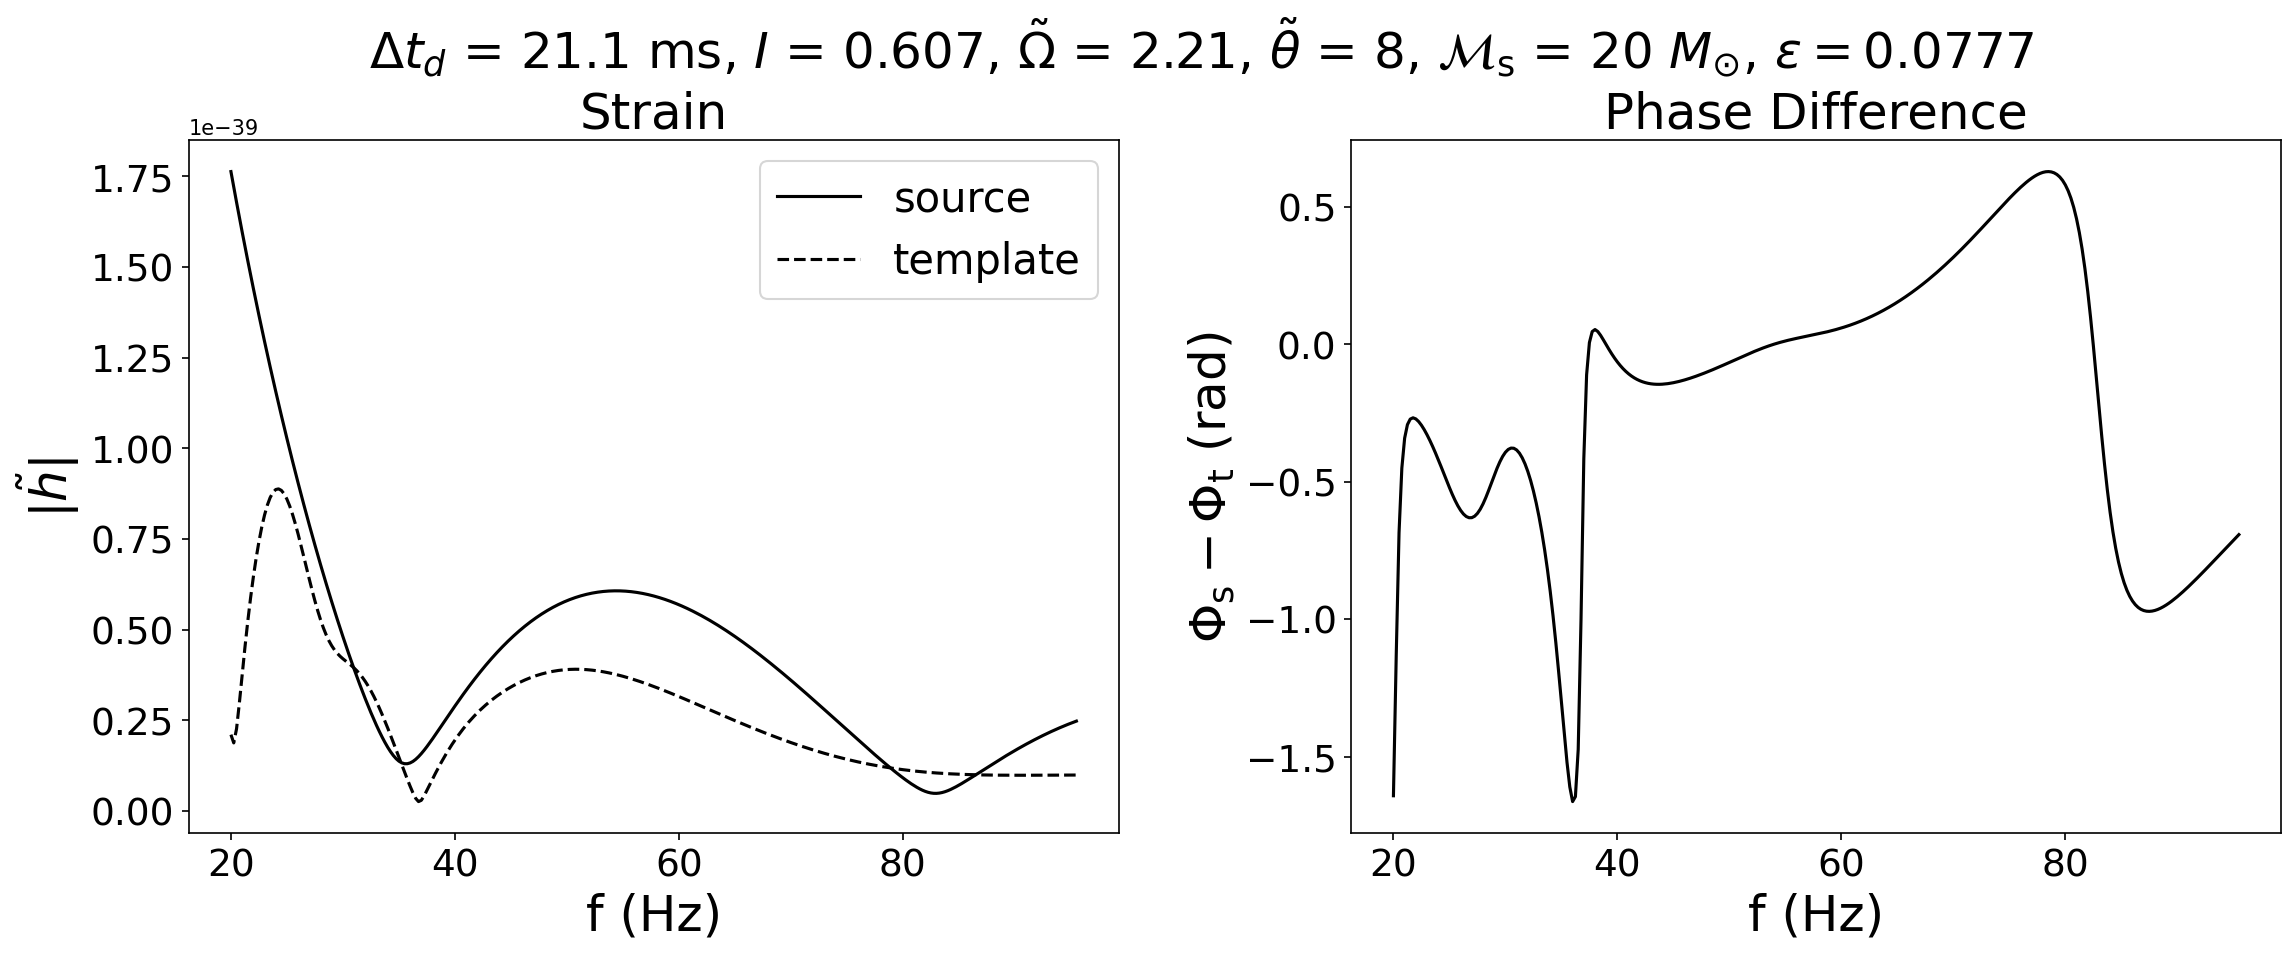

idx = -2.30361e-08, phi = 5.80595e-09, both should be ~0 if get_updated_mismatch_results is True


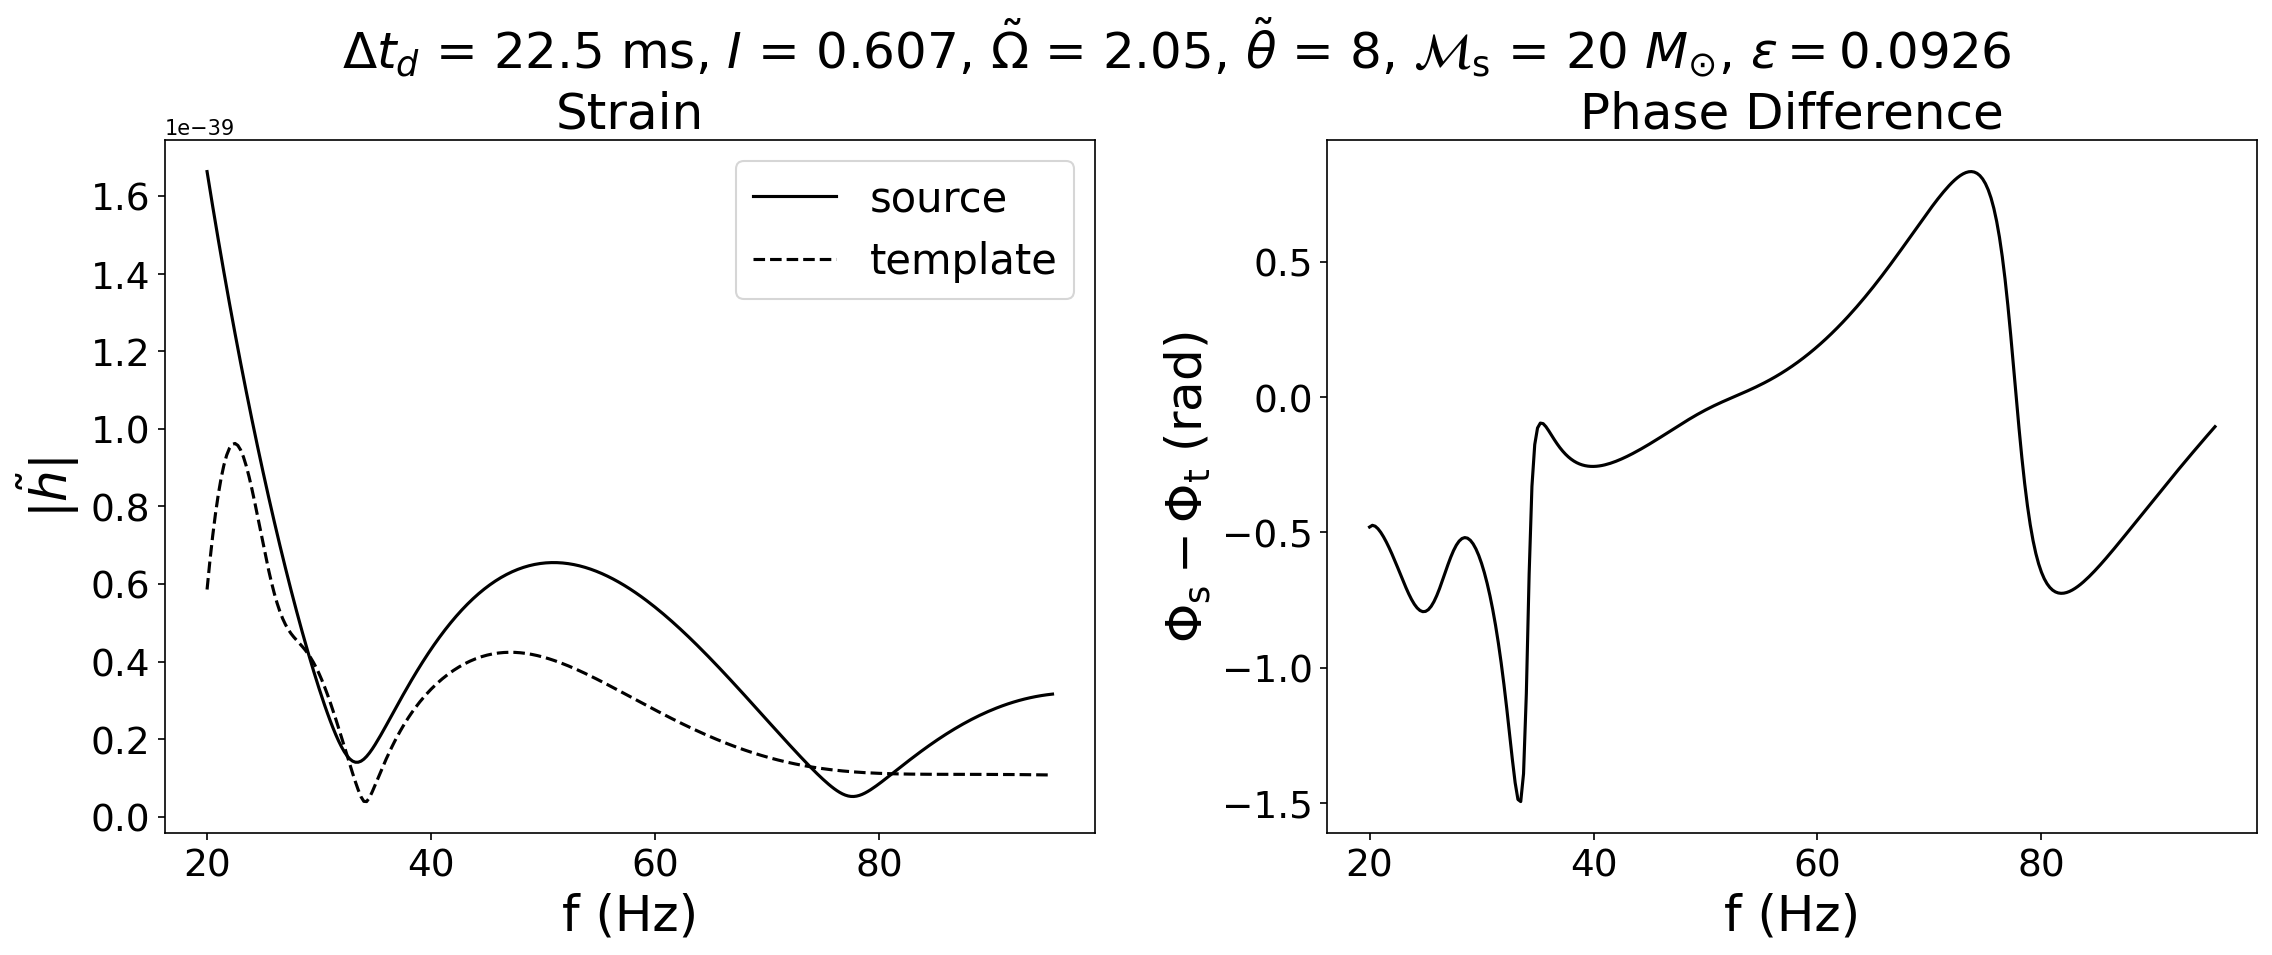

idx = 1.1378e-08, phi = -2.11034e-08, both should be ~0 if get_updated_mismatch_results is True


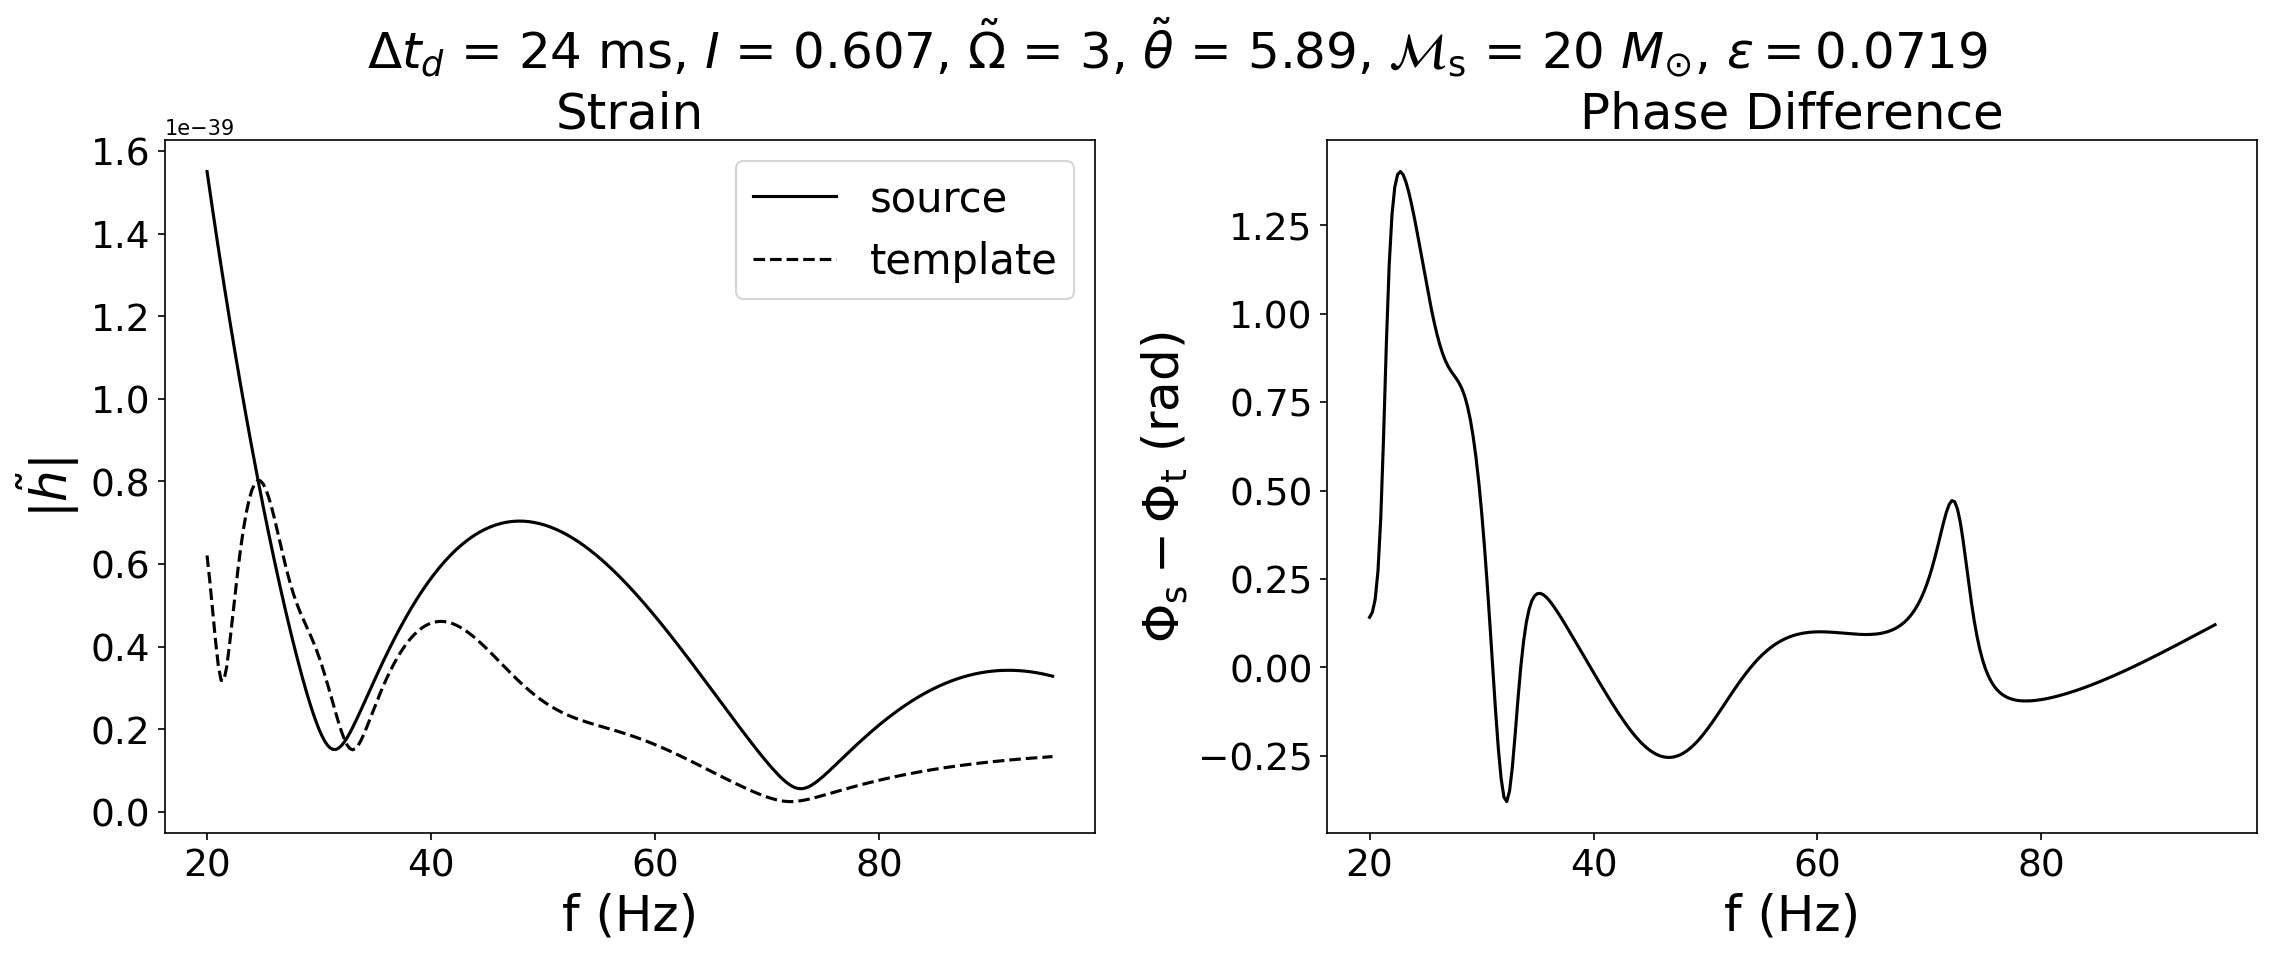

idx = -1.87352e-09, phi = -3.24494e-09, both should be ~0 if get_updated_mismatch_results is True


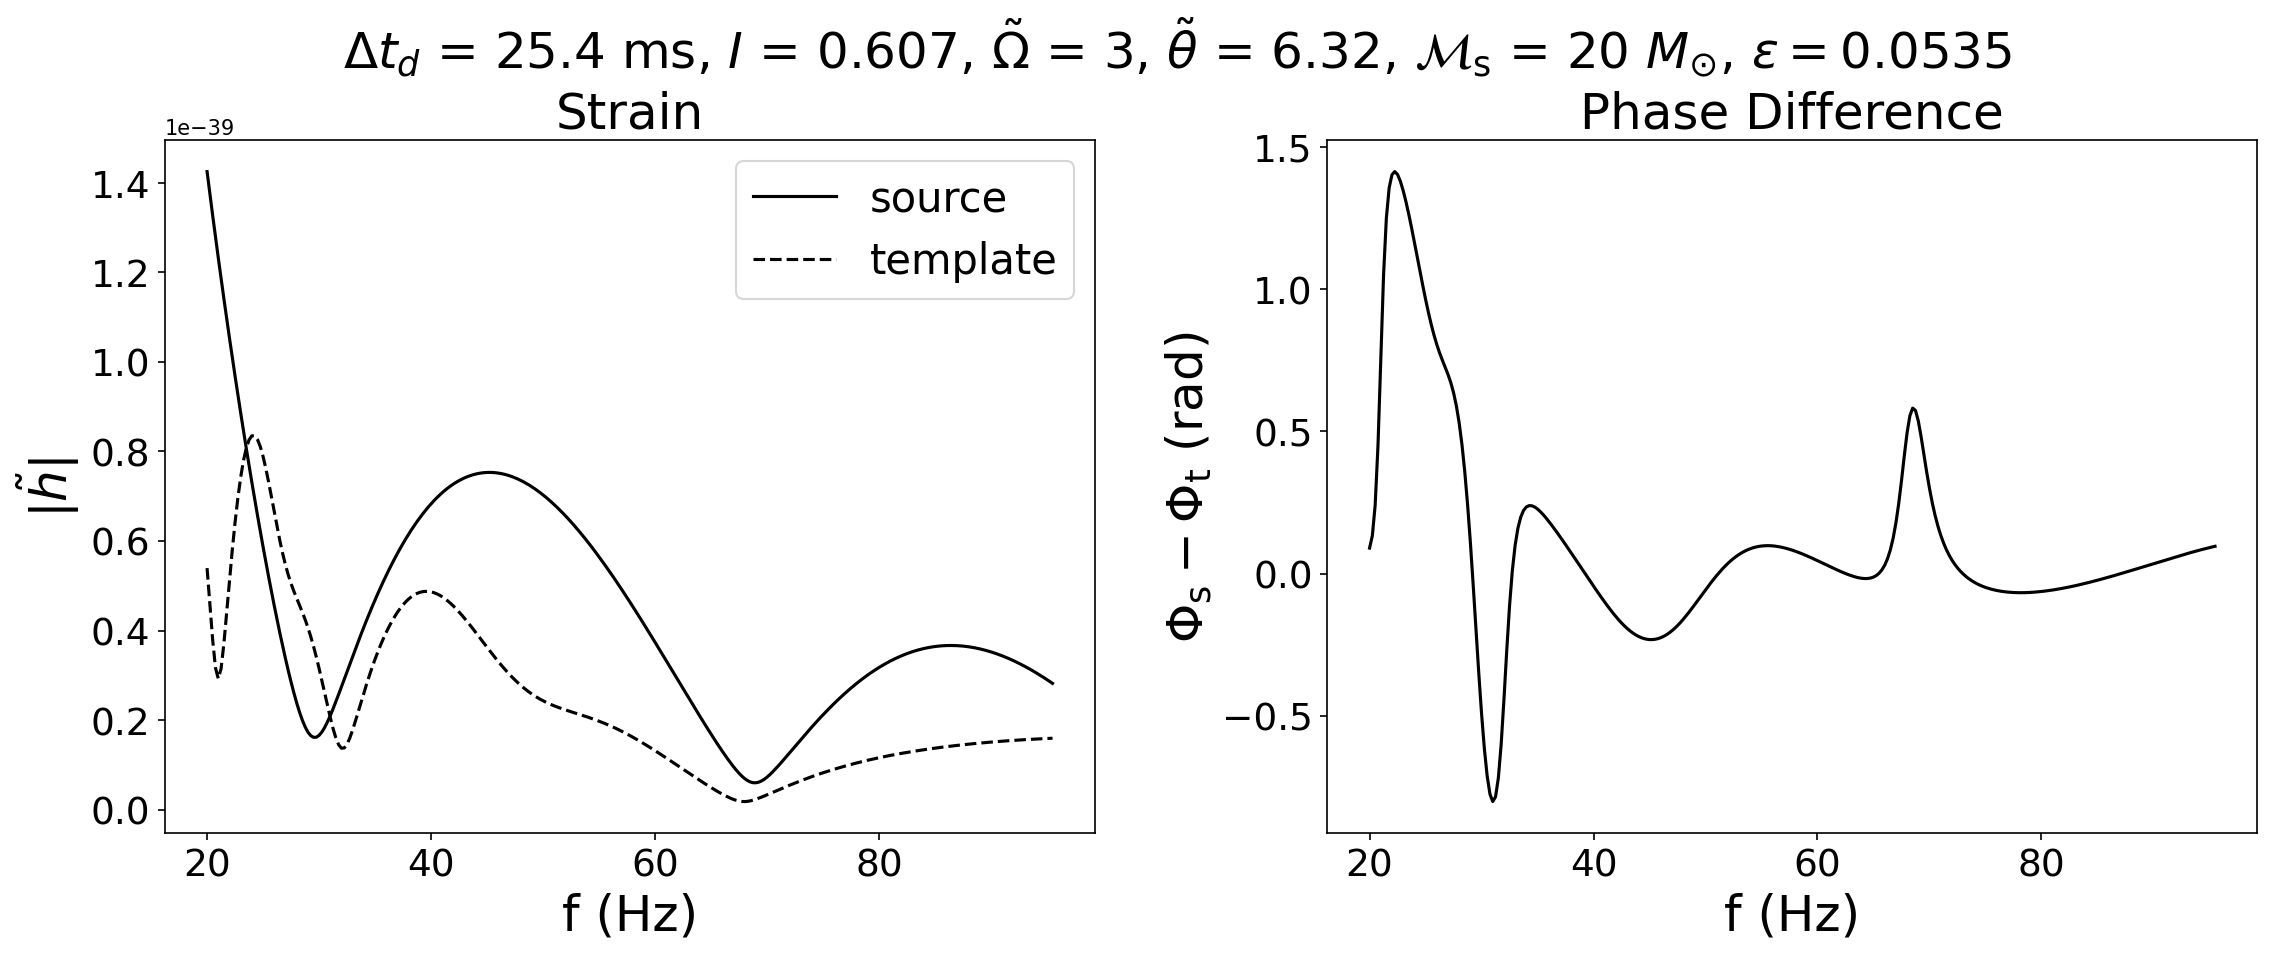

idx = 1.54766e-08, phi = -3.04758e-09, both should be ~0 if get_updated_mismatch_results is True


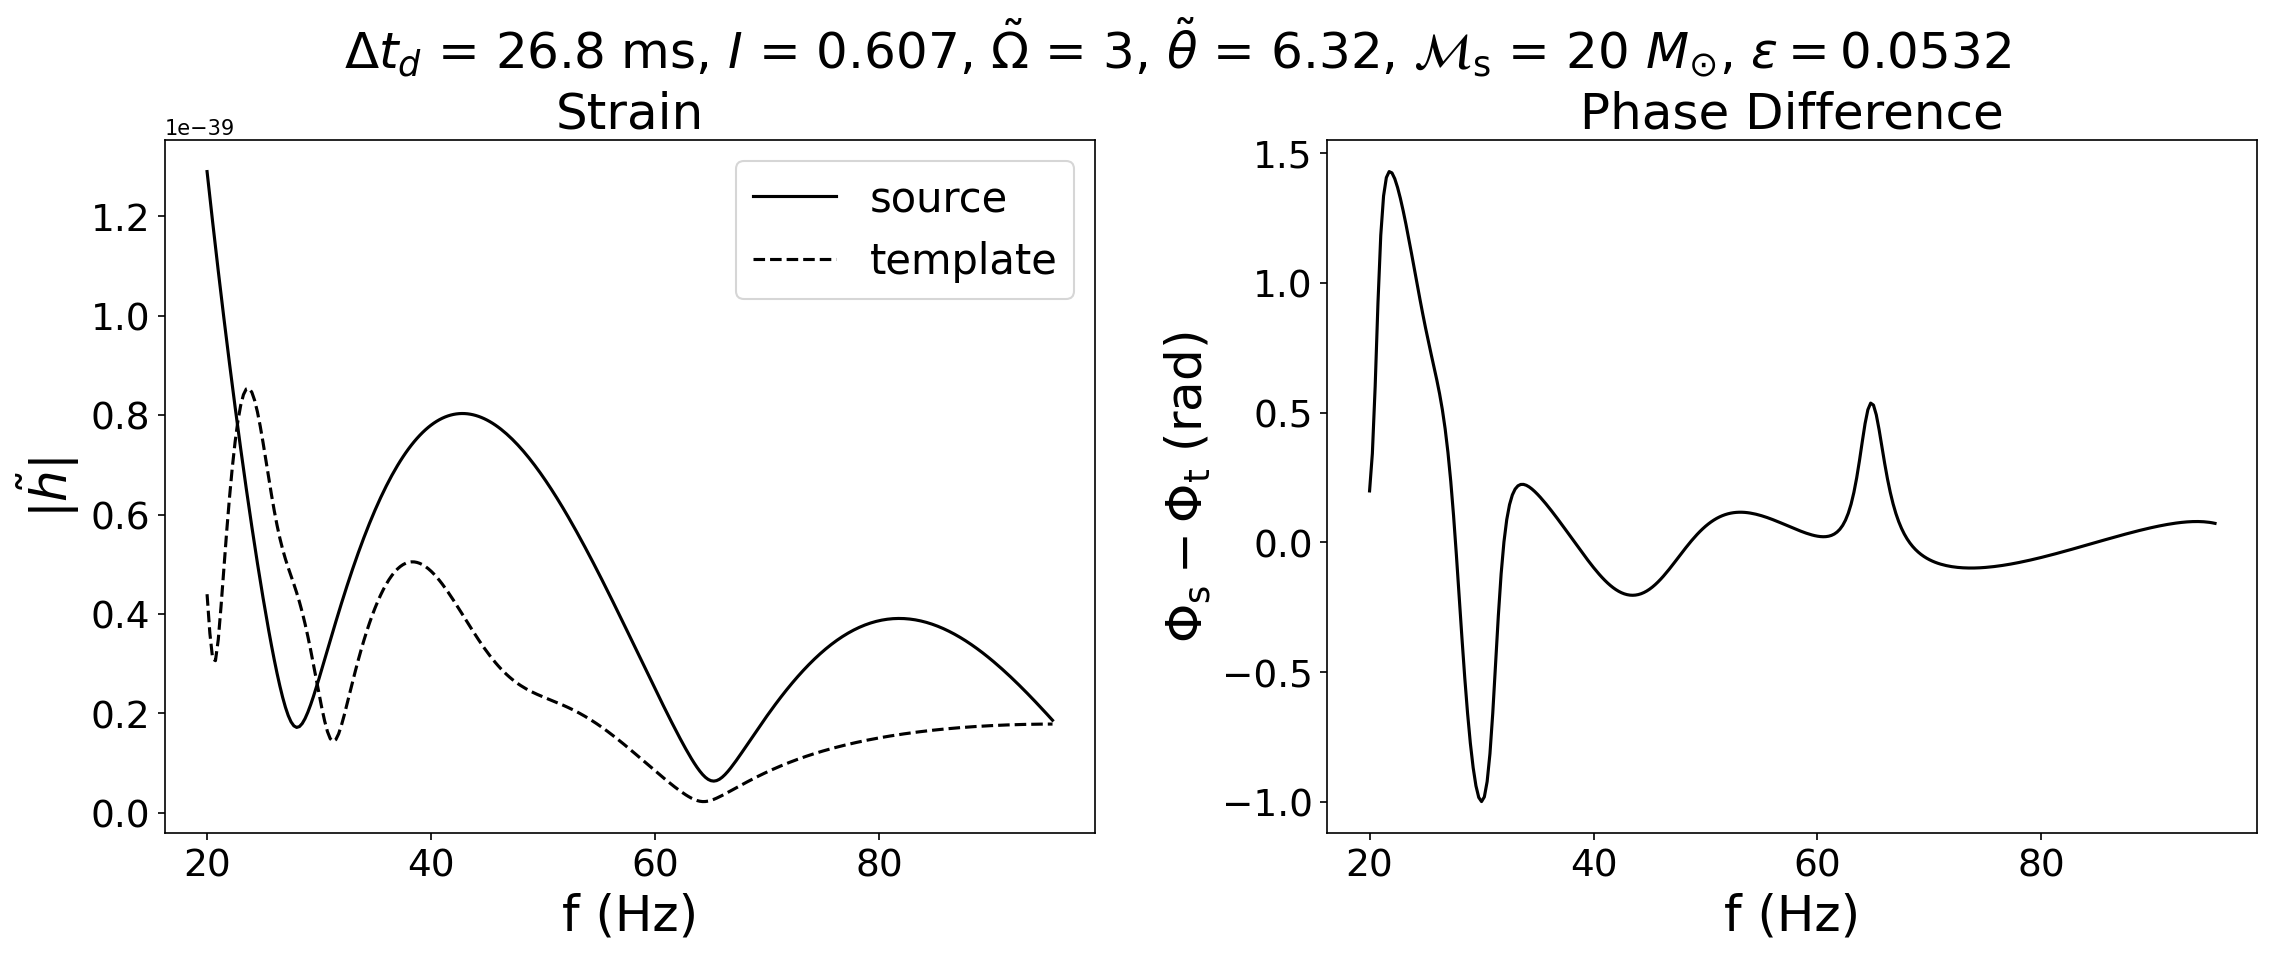

idx = 7.68365e-09, phi = -1.5534e-11, both should be ~0 if get_updated_mismatch_results is True


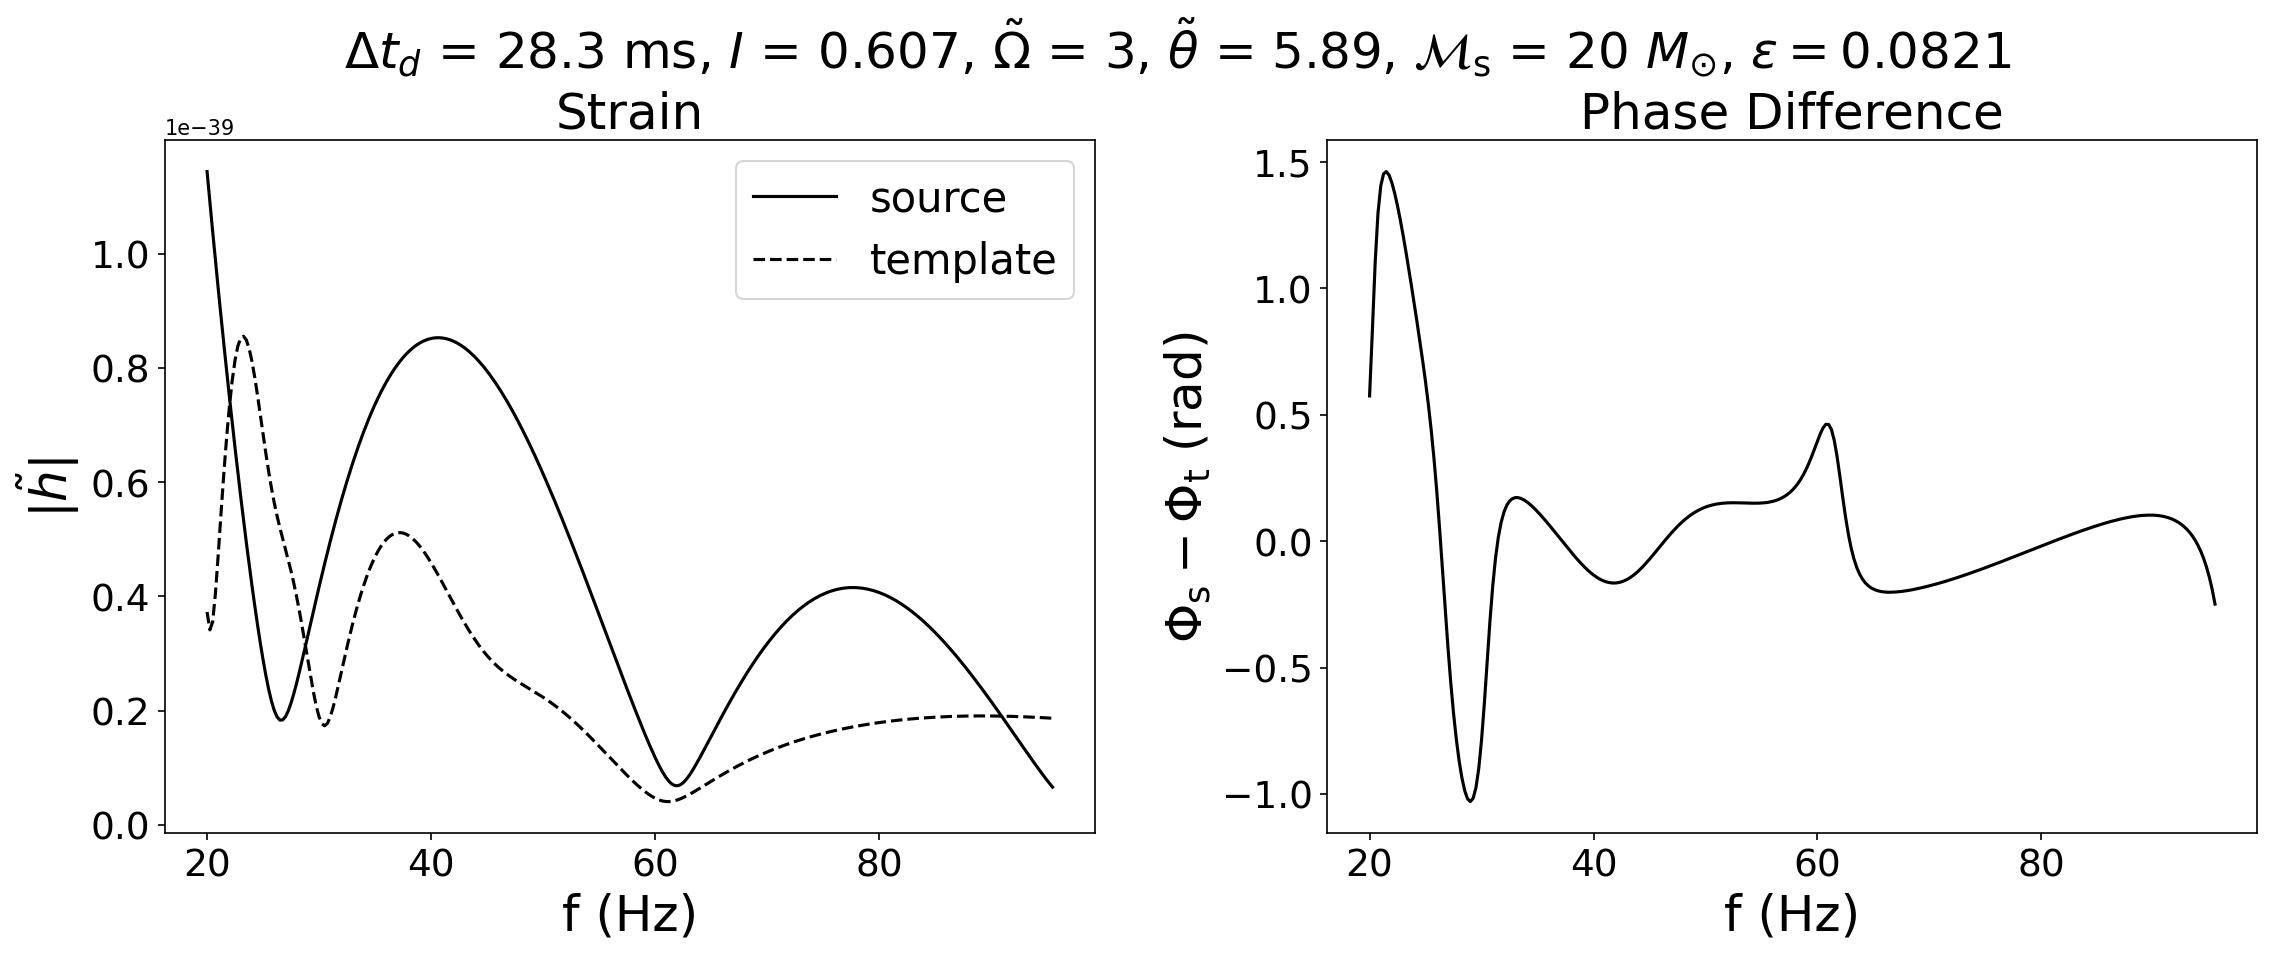

idx = -3.07173e-08, phi = 2.14423e-08, both should be ~0 if get_updated_mismatch_results is True


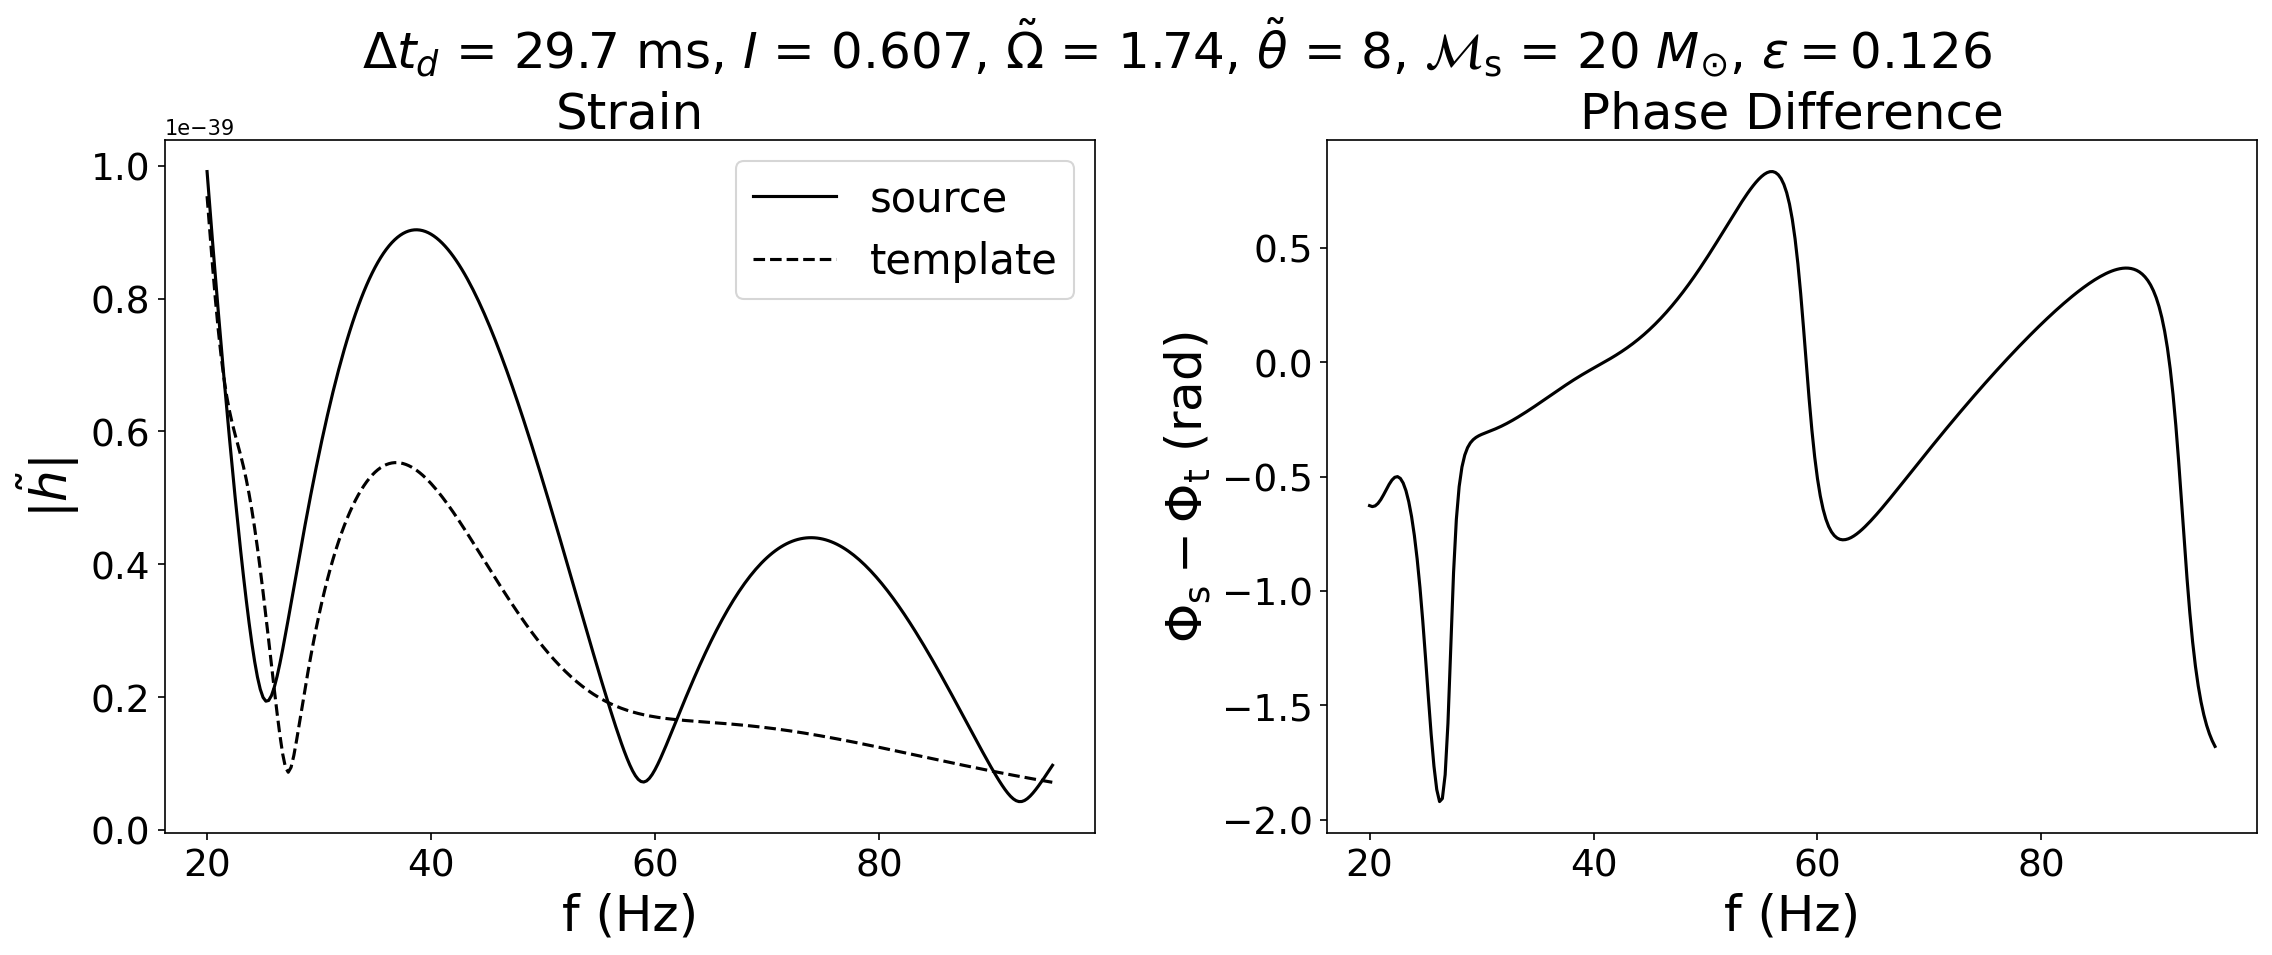

idx = -1.0699e-10, phi = 5.97055e-09, both should be ~0 if get_updated_mismatch_results is True


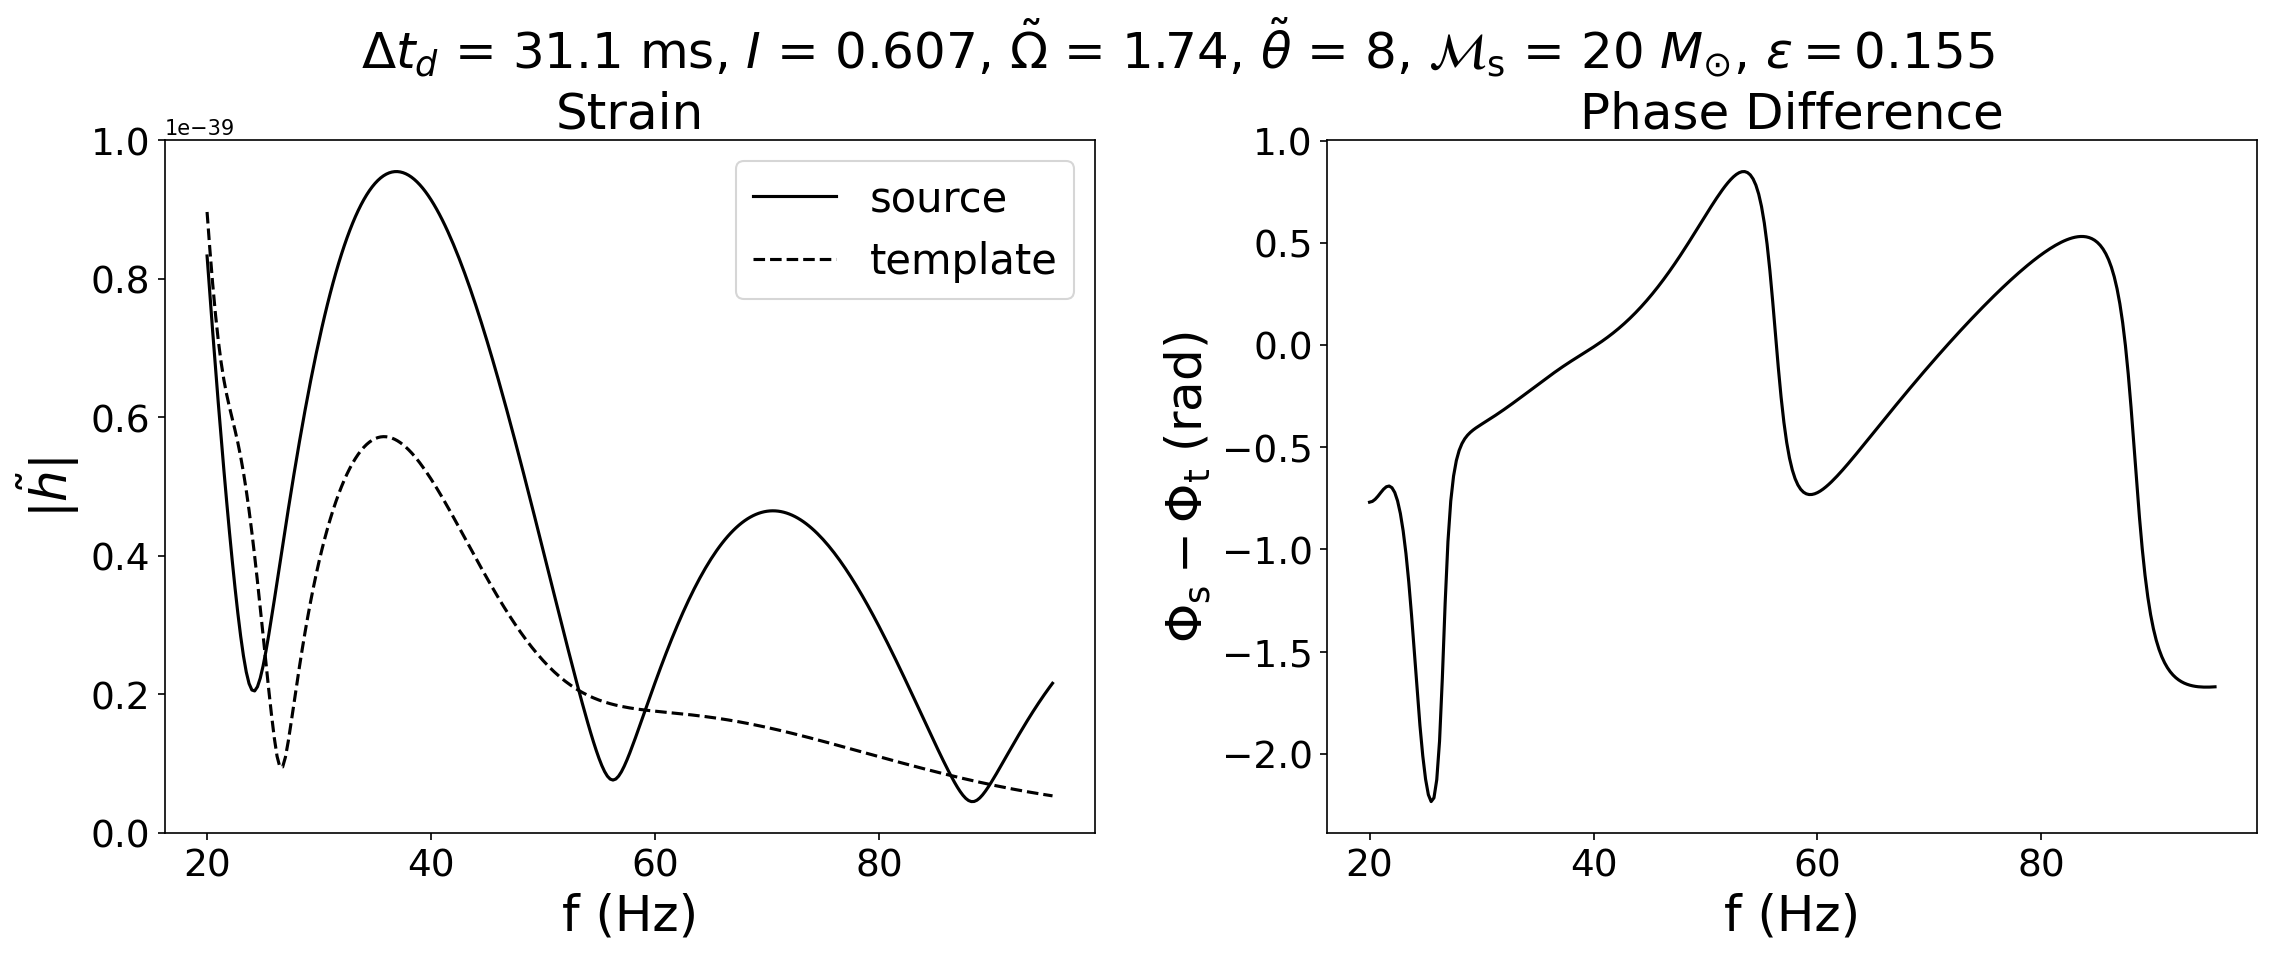

idx = 1.76888e-08, phi = -1.65512e-08, both should be ~0 if get_updated_mismatch_results is True


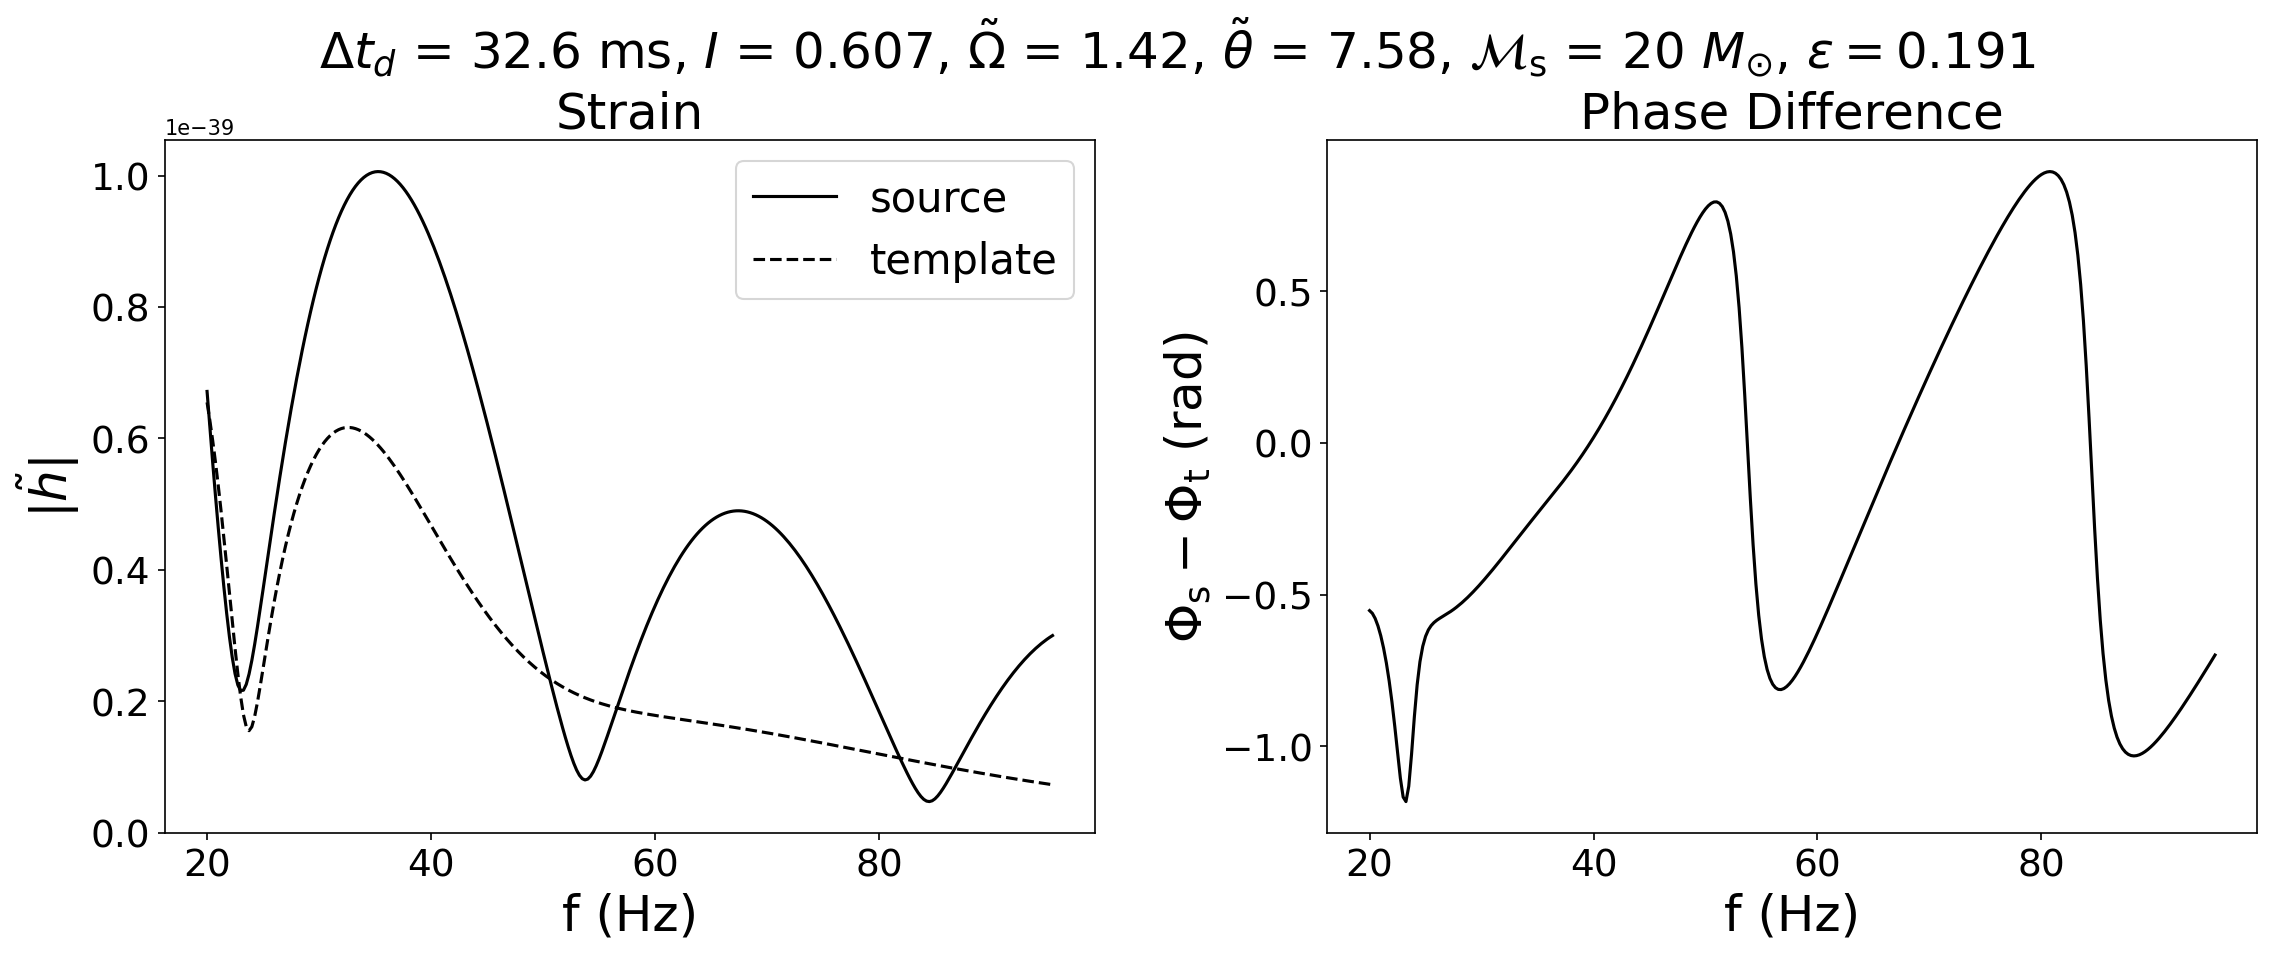

idx = -6.48524e-09, phi = 1.15518e-08, both should be ~0 if get_updated_mismatch_results is True


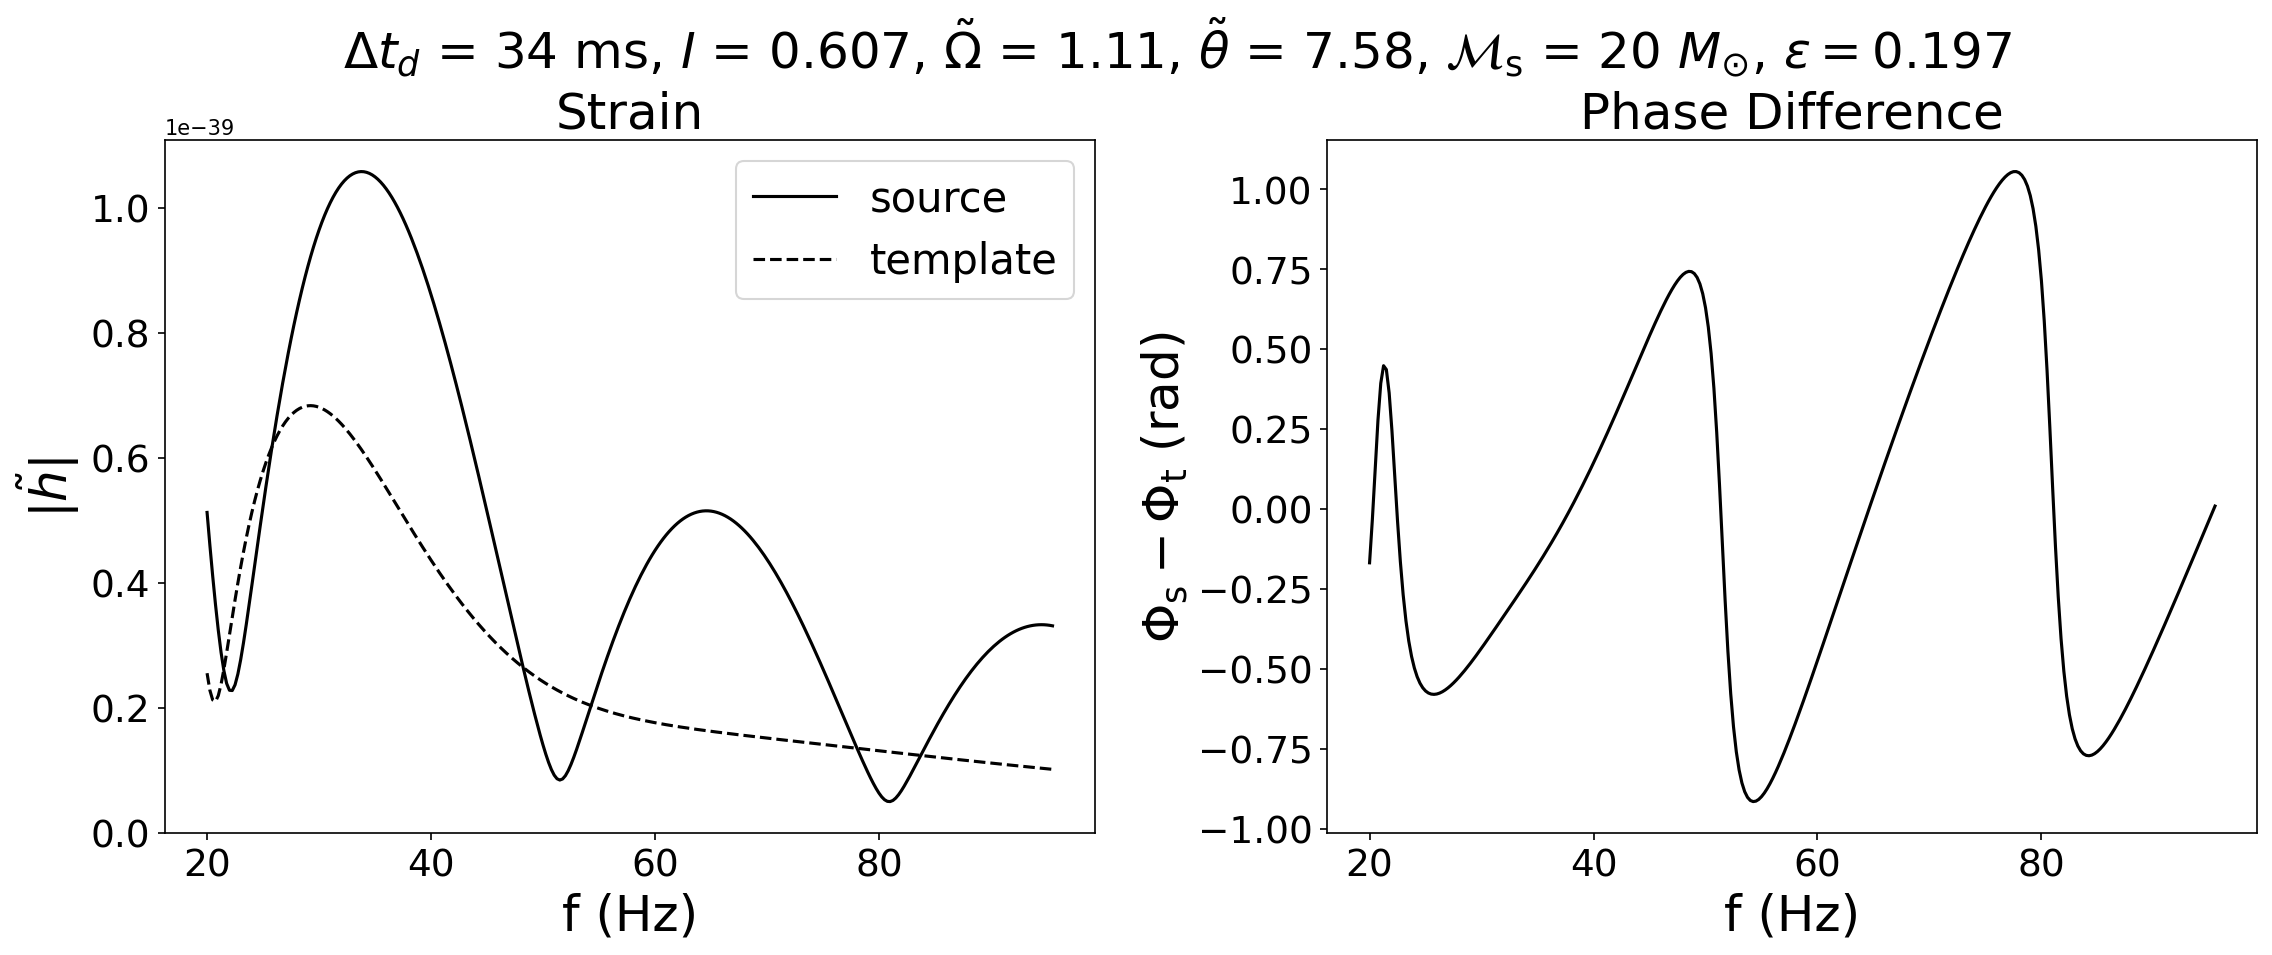

idx = -3.26076e-09, phi = -1.4963e-08, both should be ~0 if get_updated_mismatch_results is True


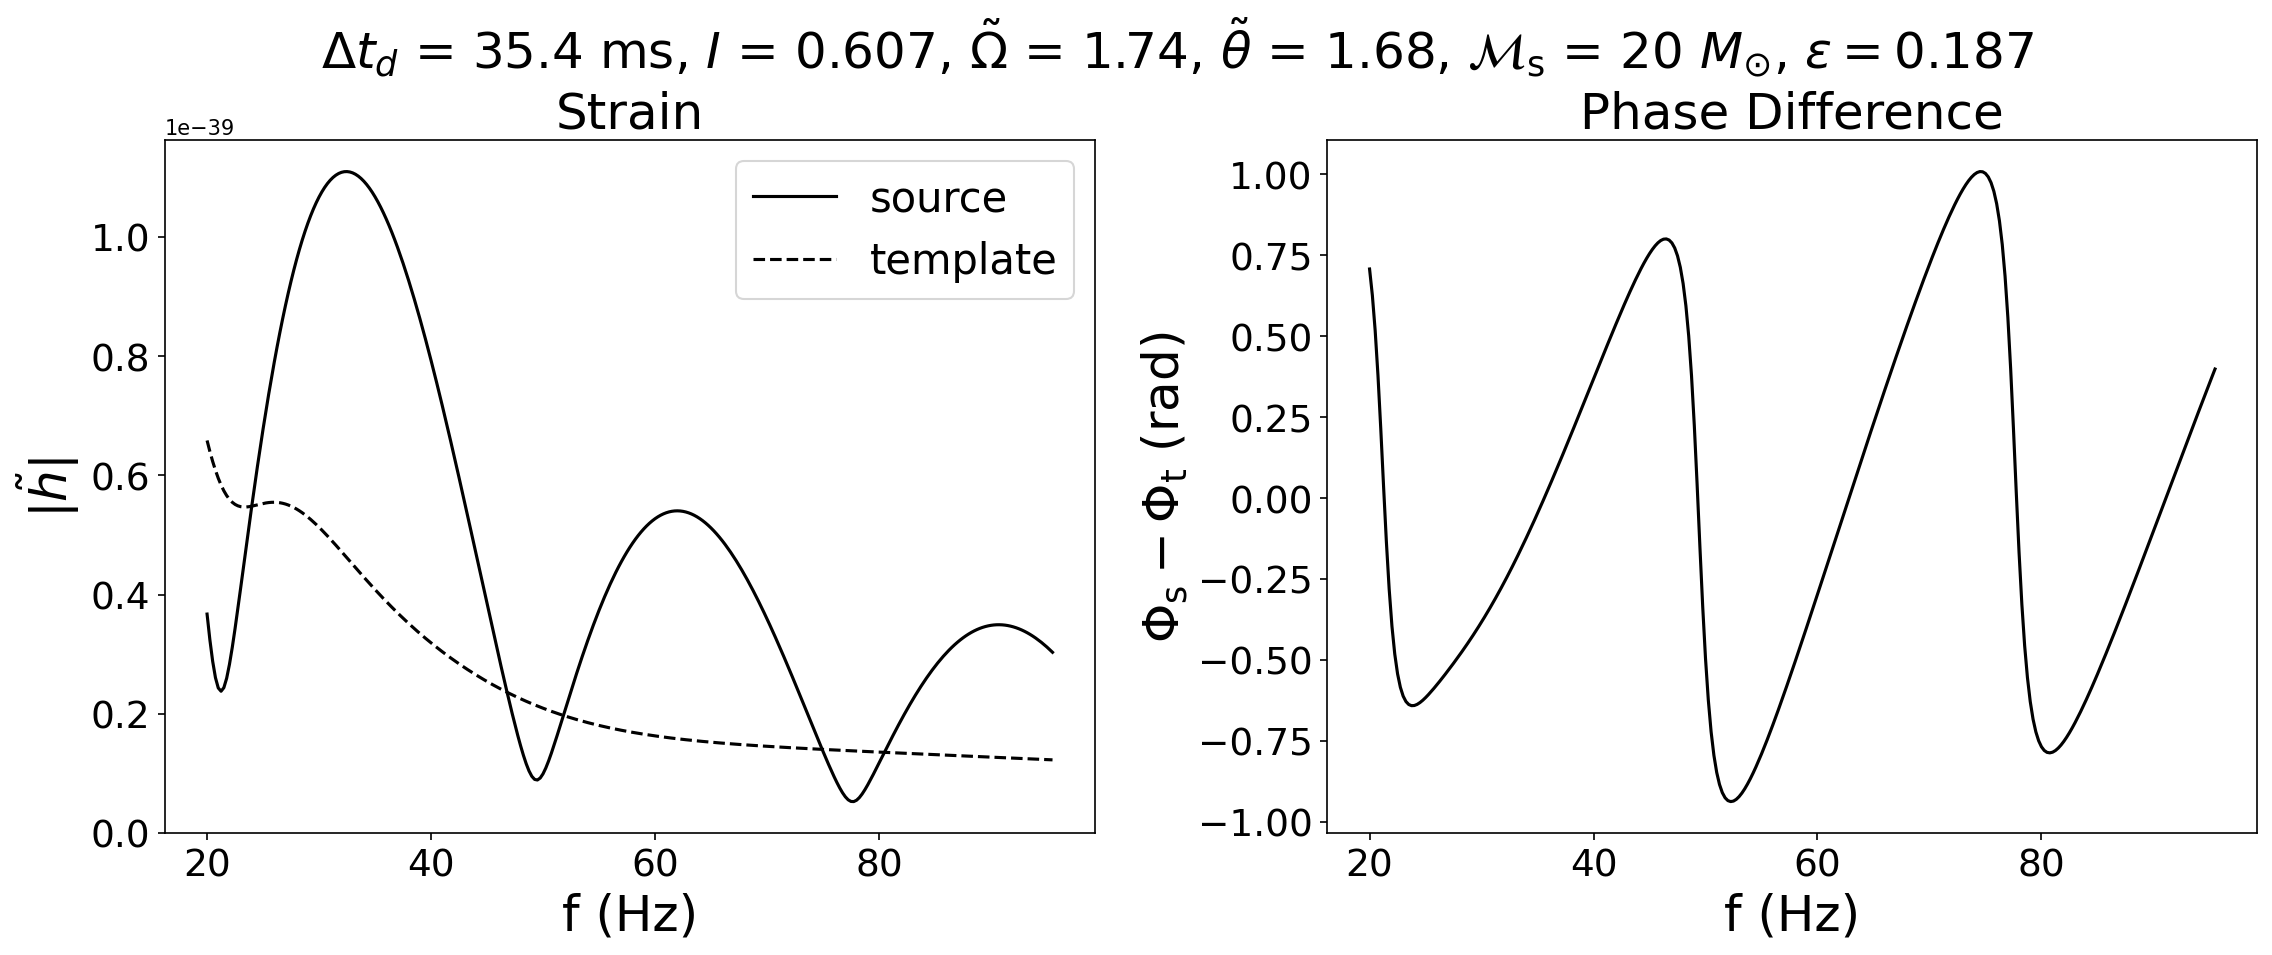

idx = -3.93275e-09, phi = -9.86118e-13, both should be ~0 if get_updated_mismatch_results is True


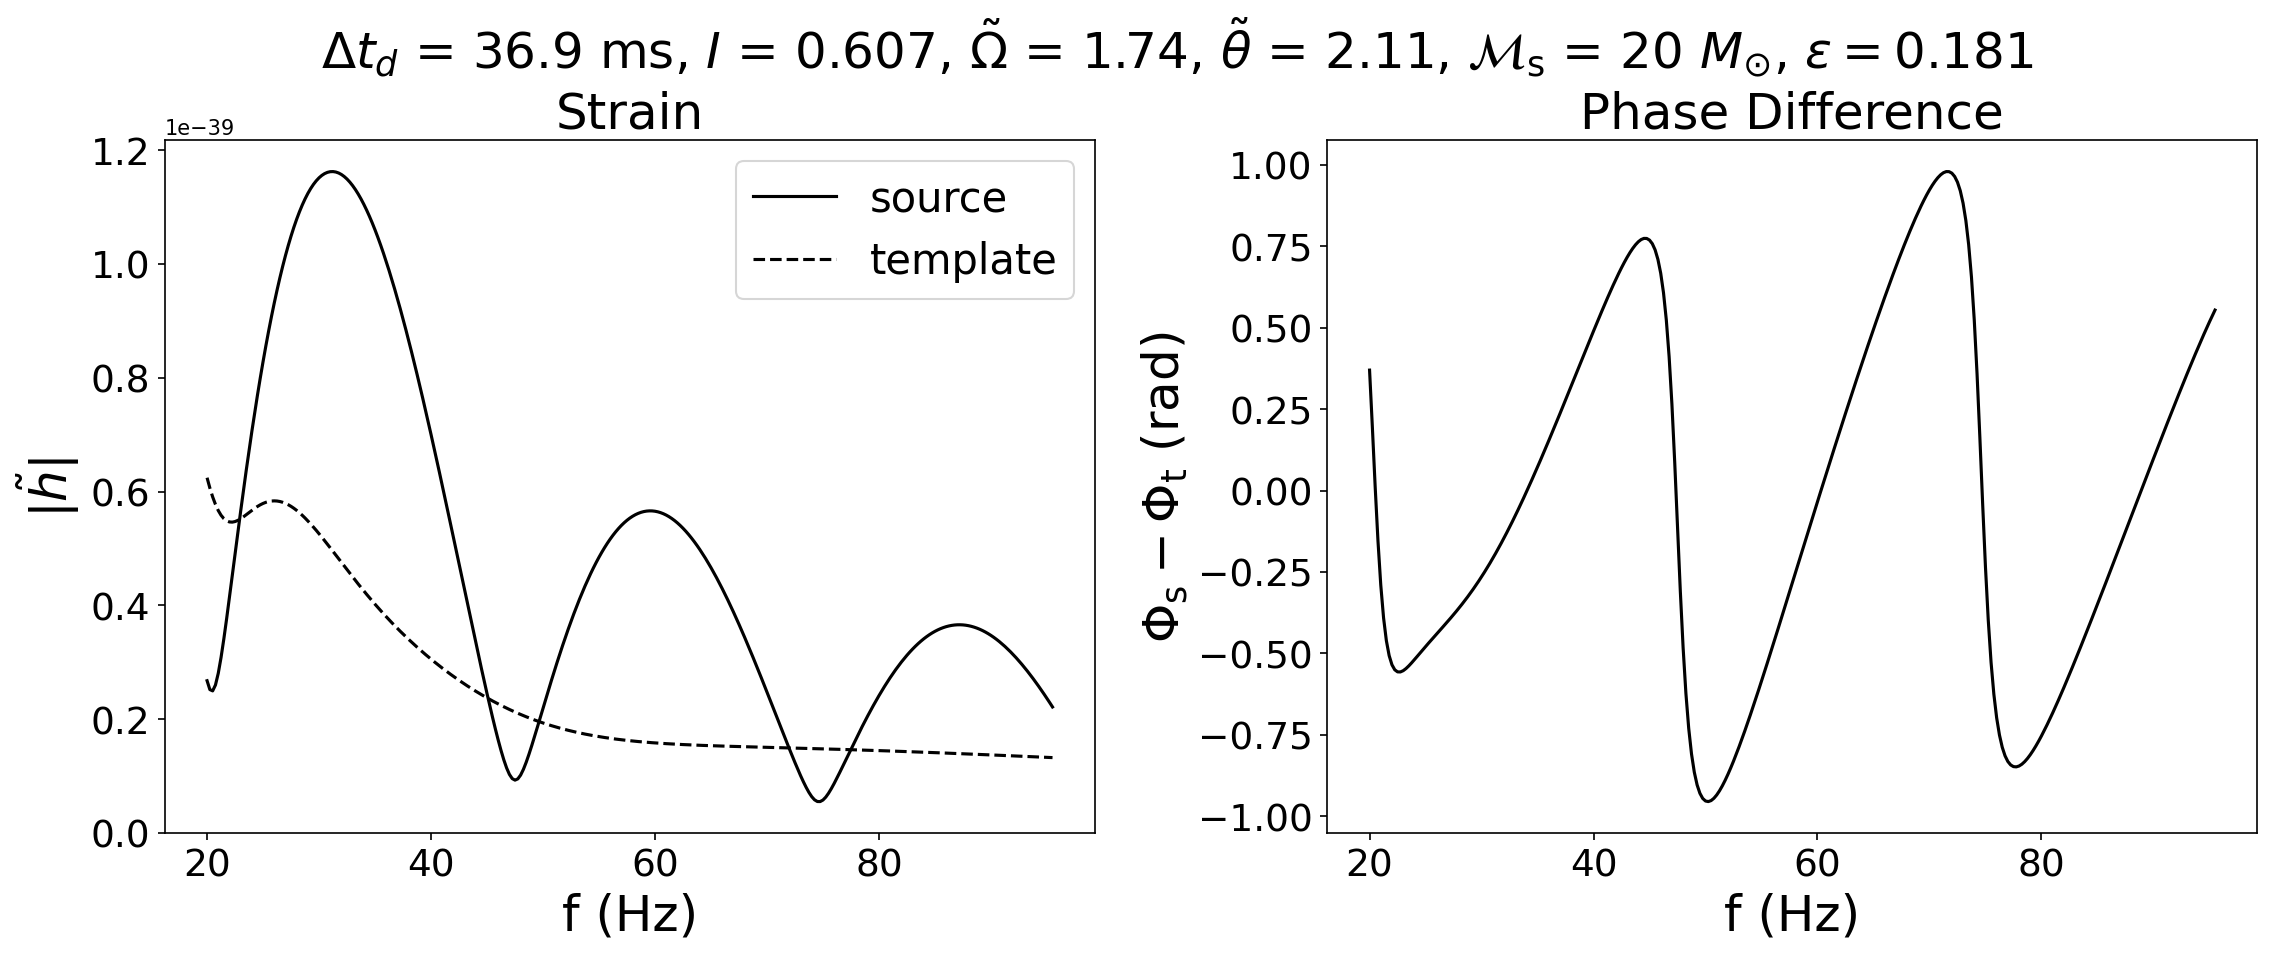

idx = -2.22575e-09, phi = 3.1859e-08, both should be ~0 if get_updated_mismatch_results is True


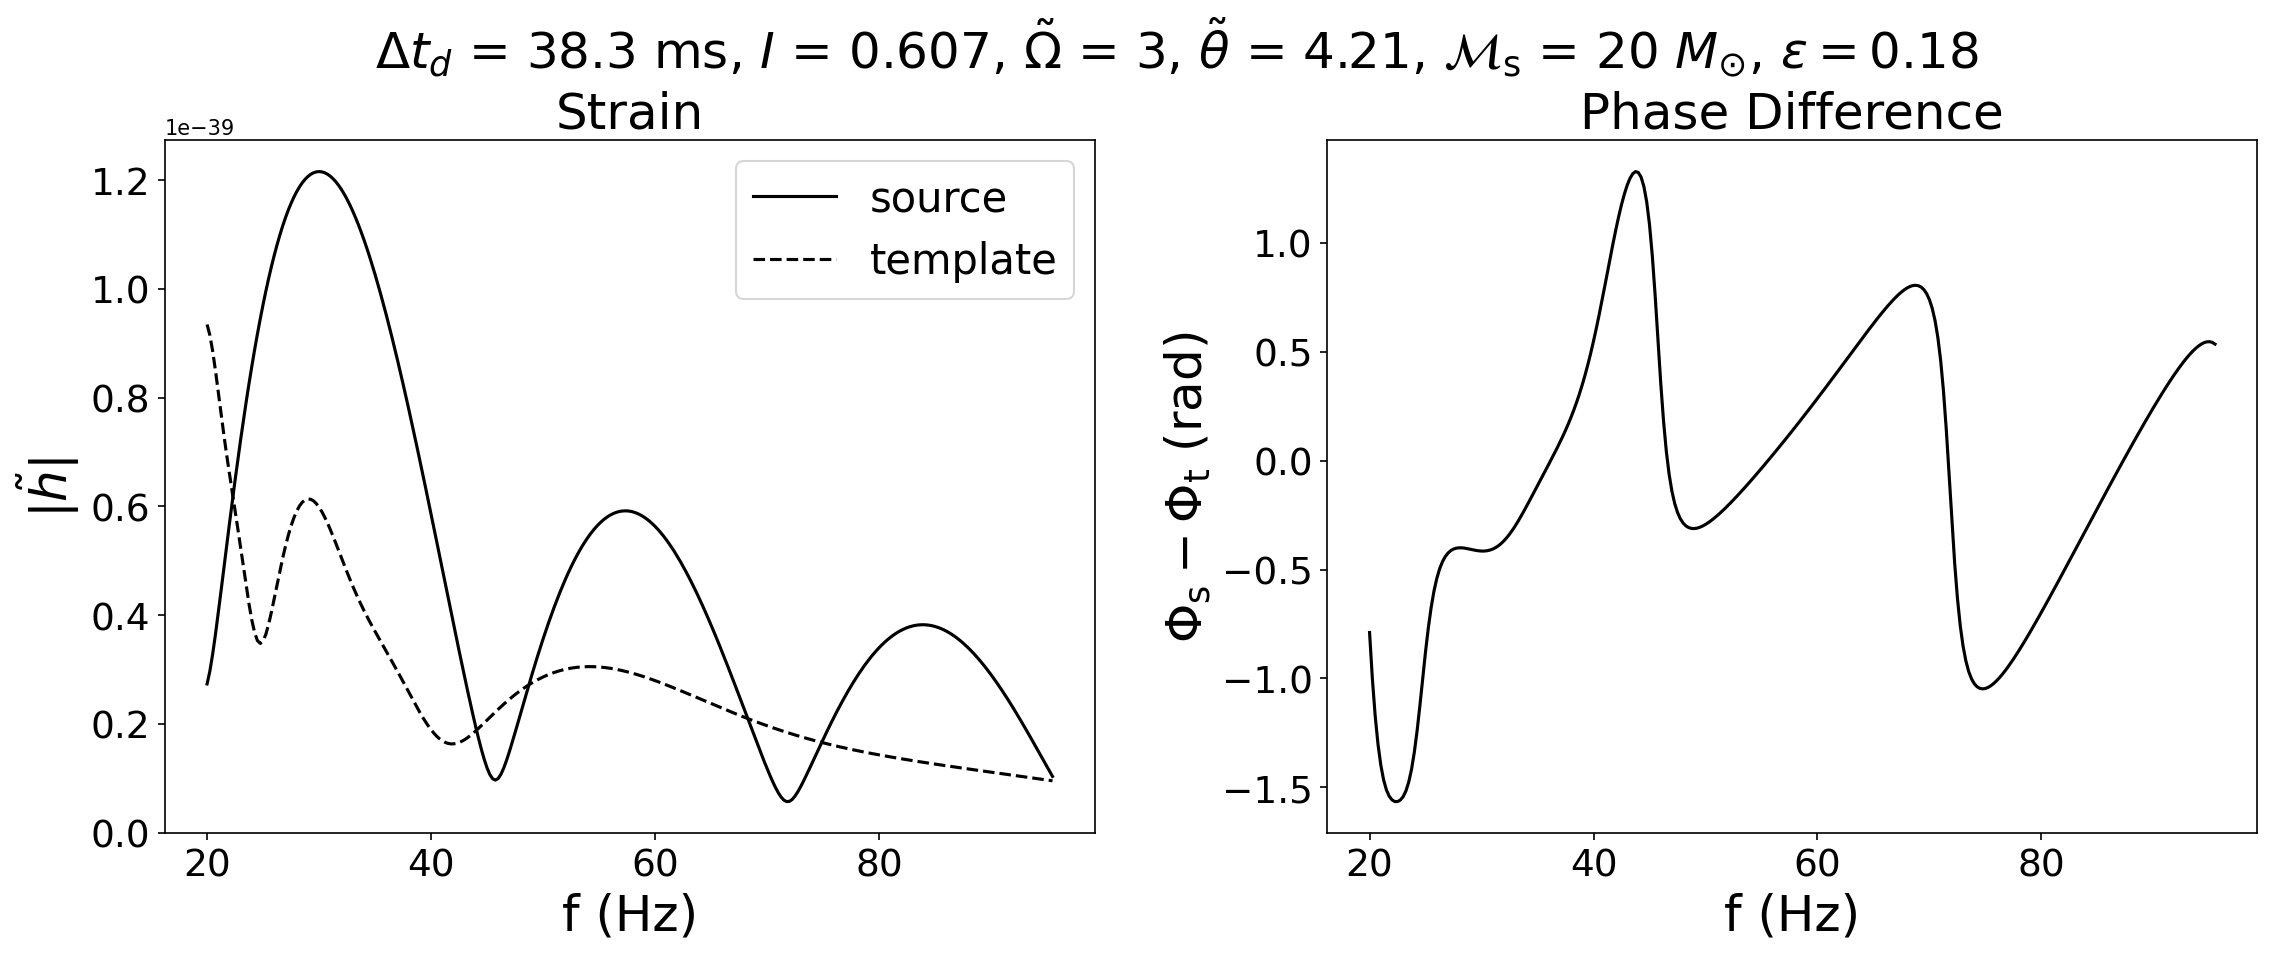

idx = 1.63683e-08, phi = -1.02626e-08, both should be ~0 if get_updated_mismatch_results is True


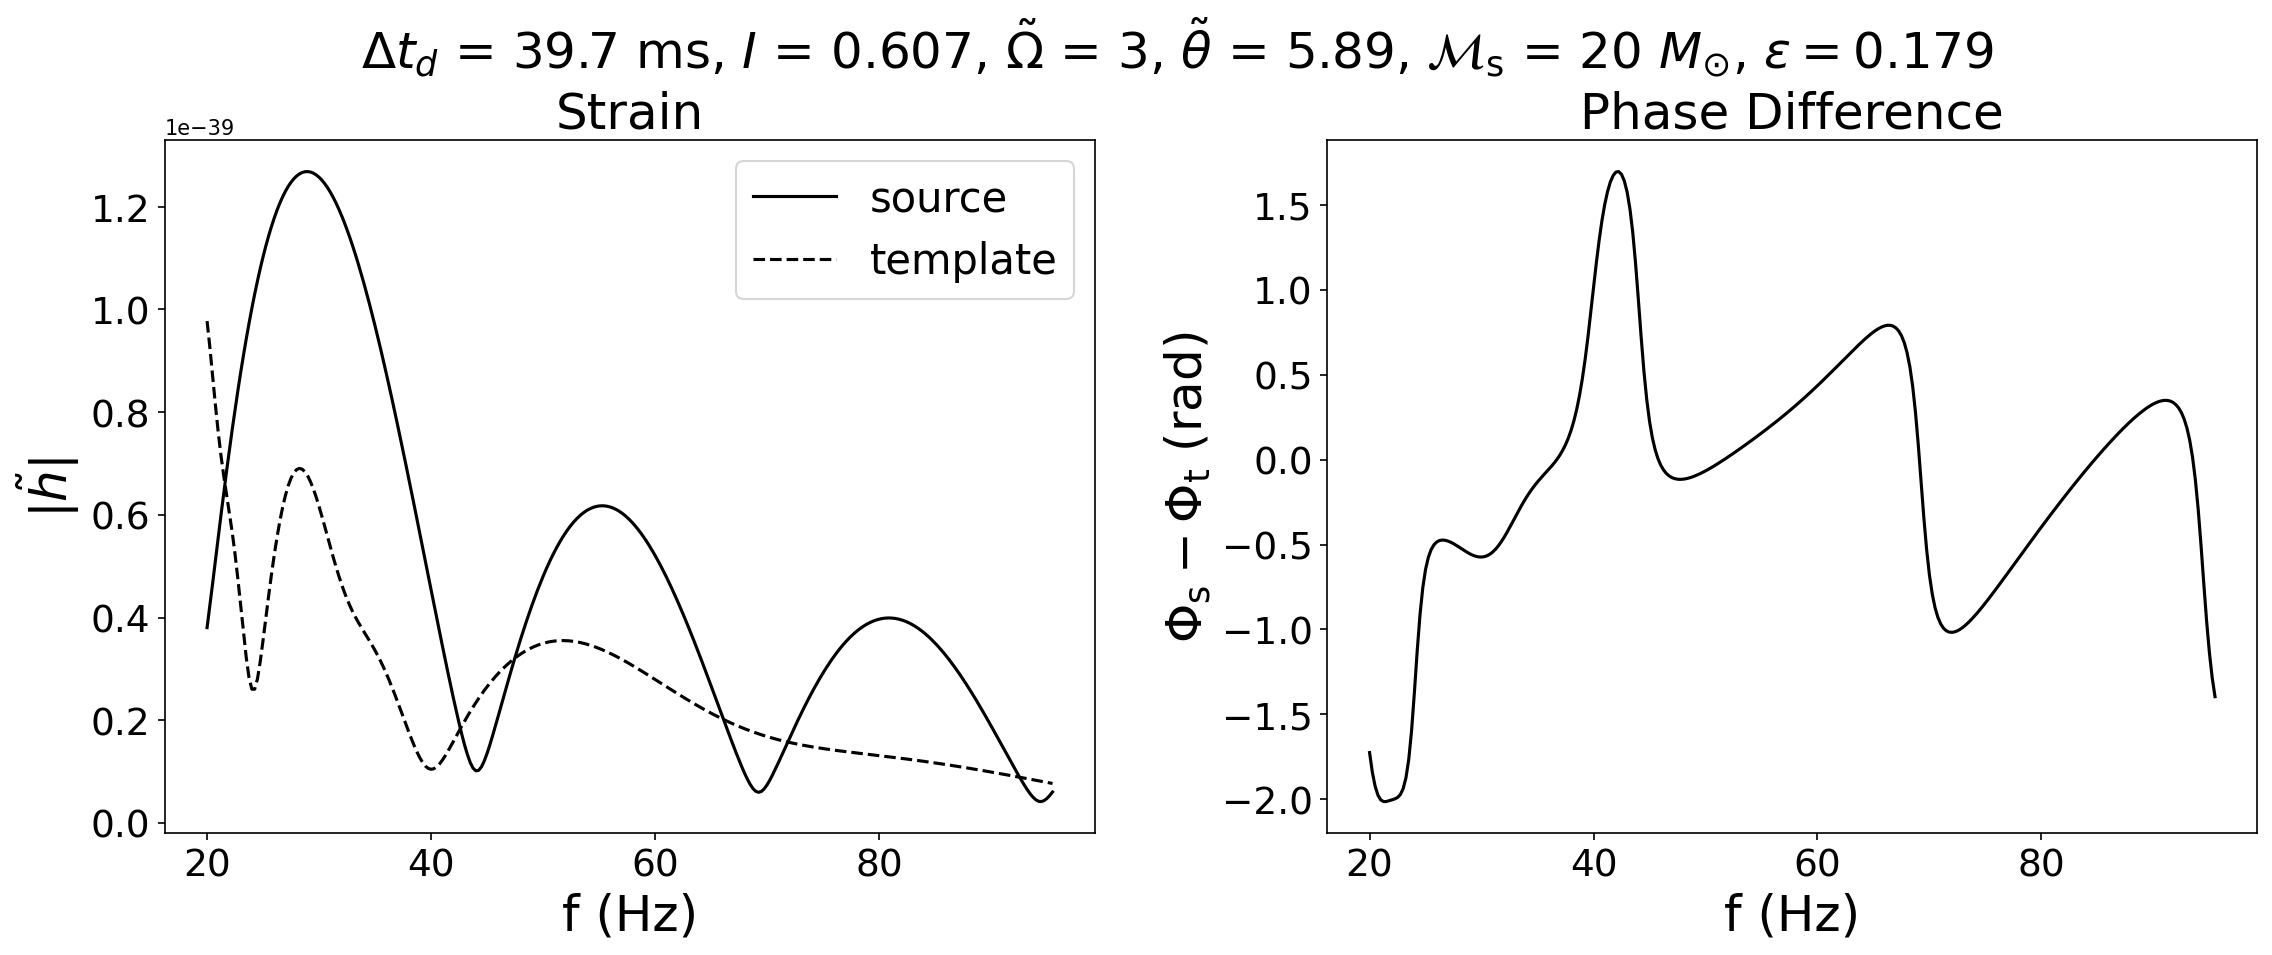

idx = 3.63099e-09, phi = 1.68588e-08, both should be ~0 if get_updated_mismatch_results is True


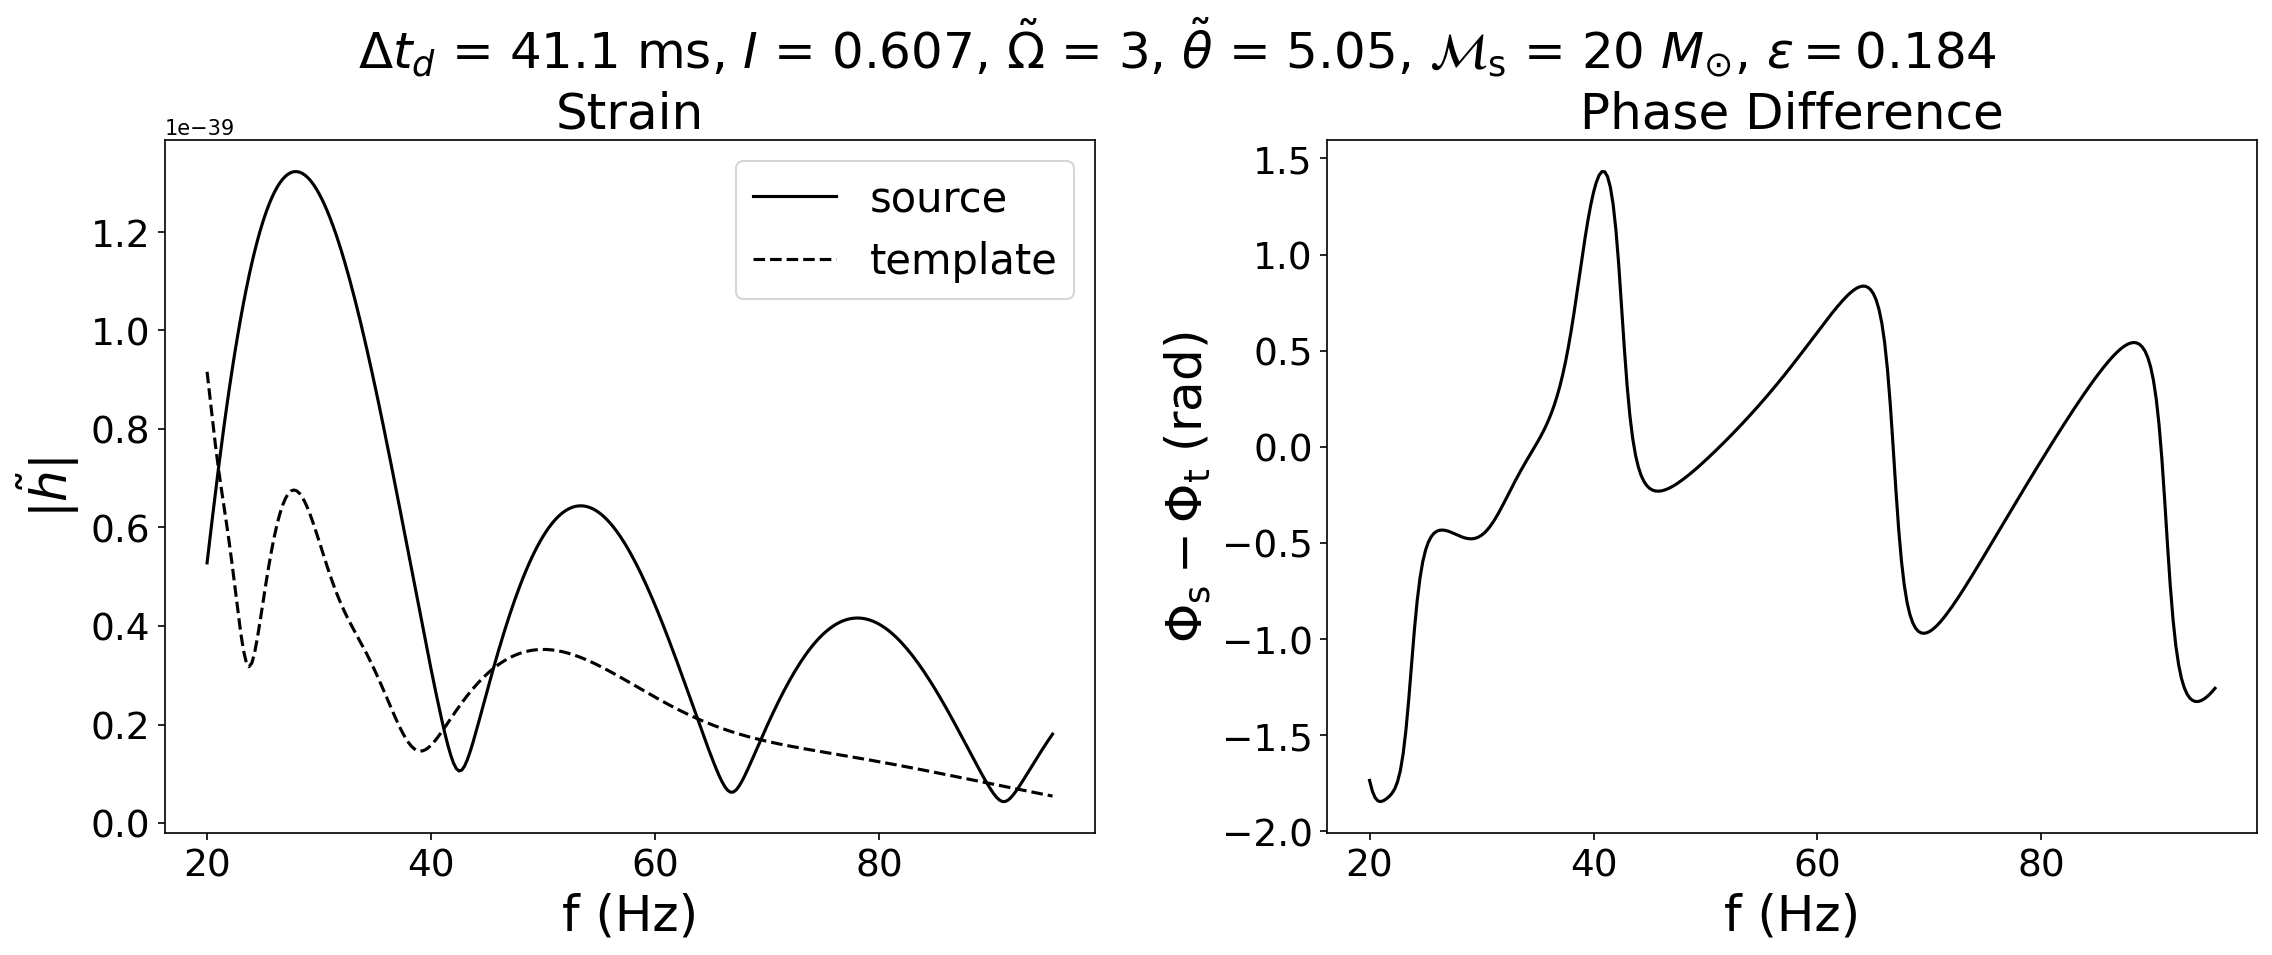

idx = -2.09195e-08, phi = 1.58973e-08, both should be ~0 if get_updated_mismatch_results is True


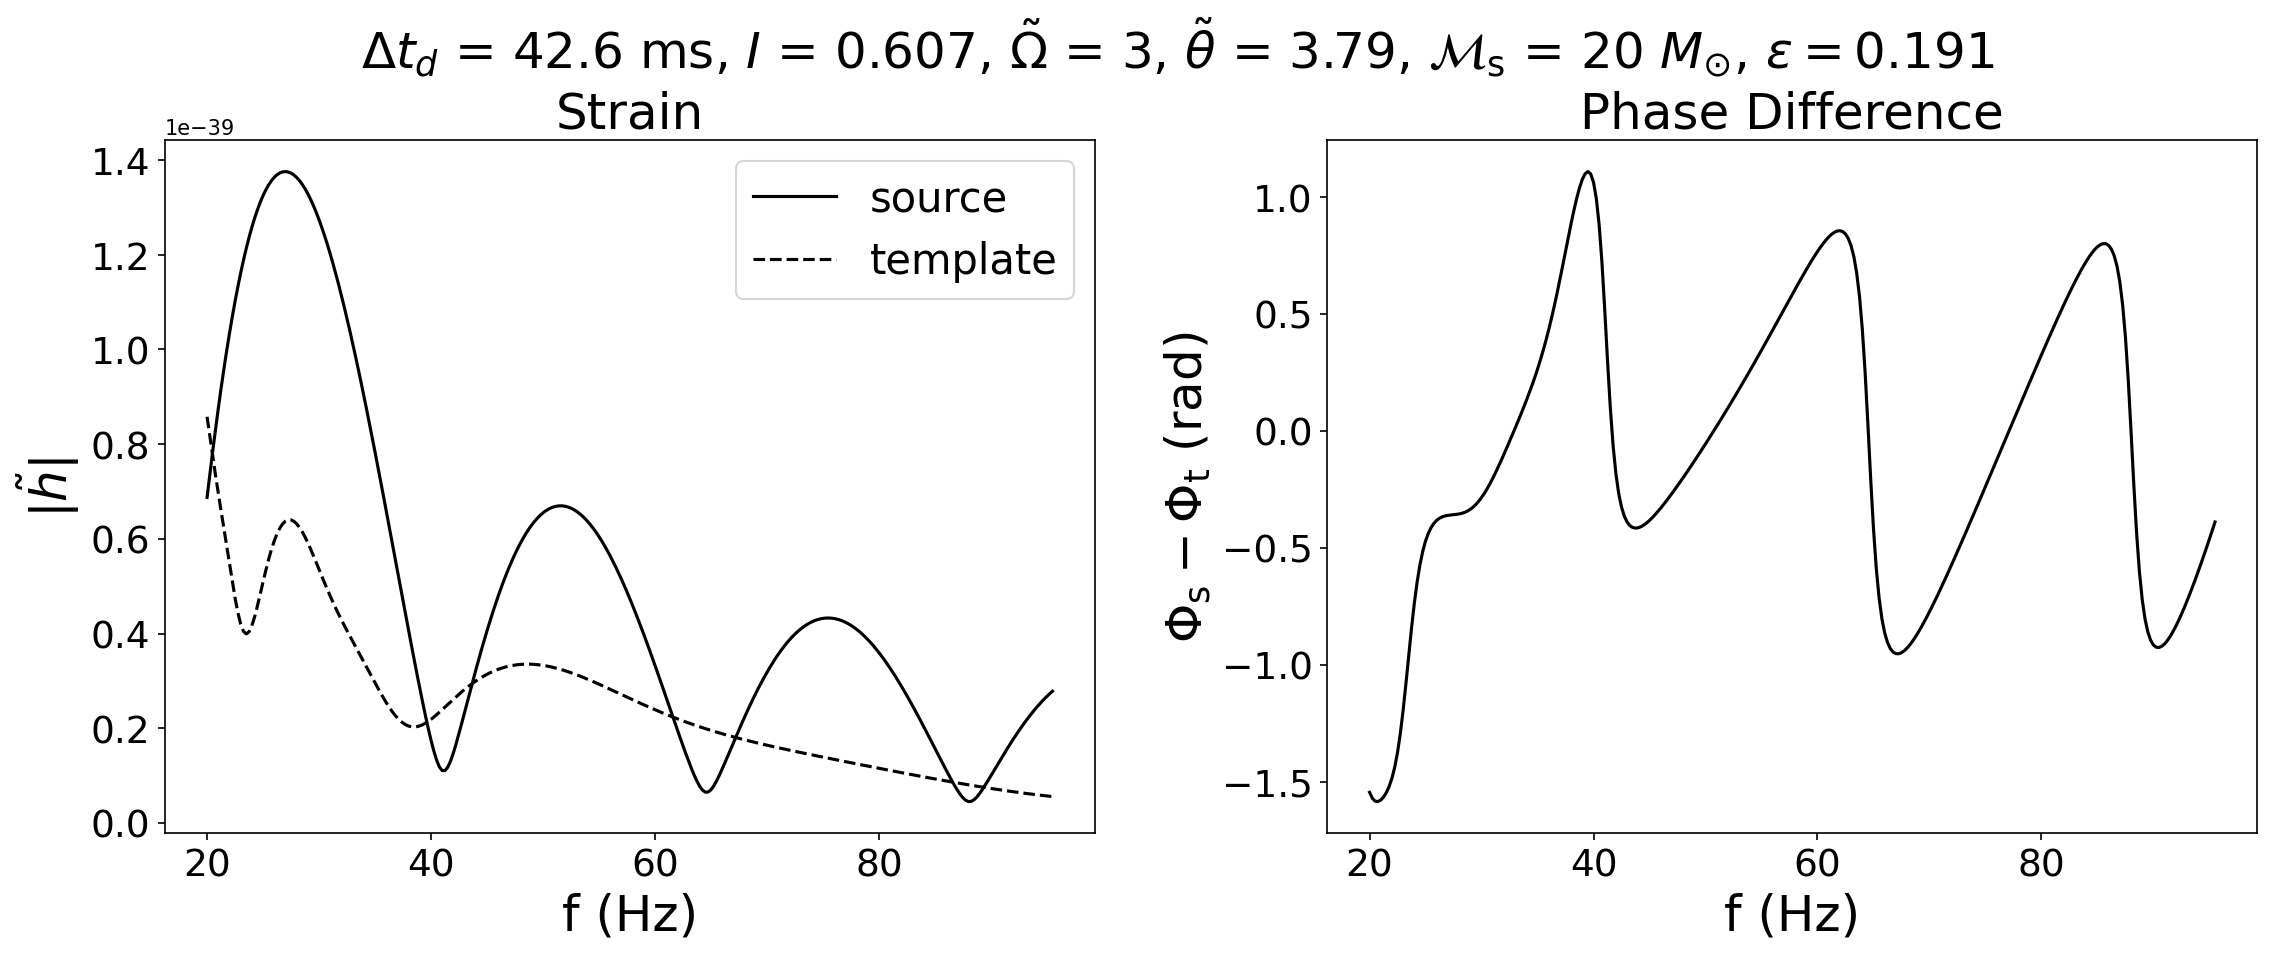

idx = 5.11862e-09, phi = 1.38851e-08, both should be ~0 if get_updated_mismatch_results is True


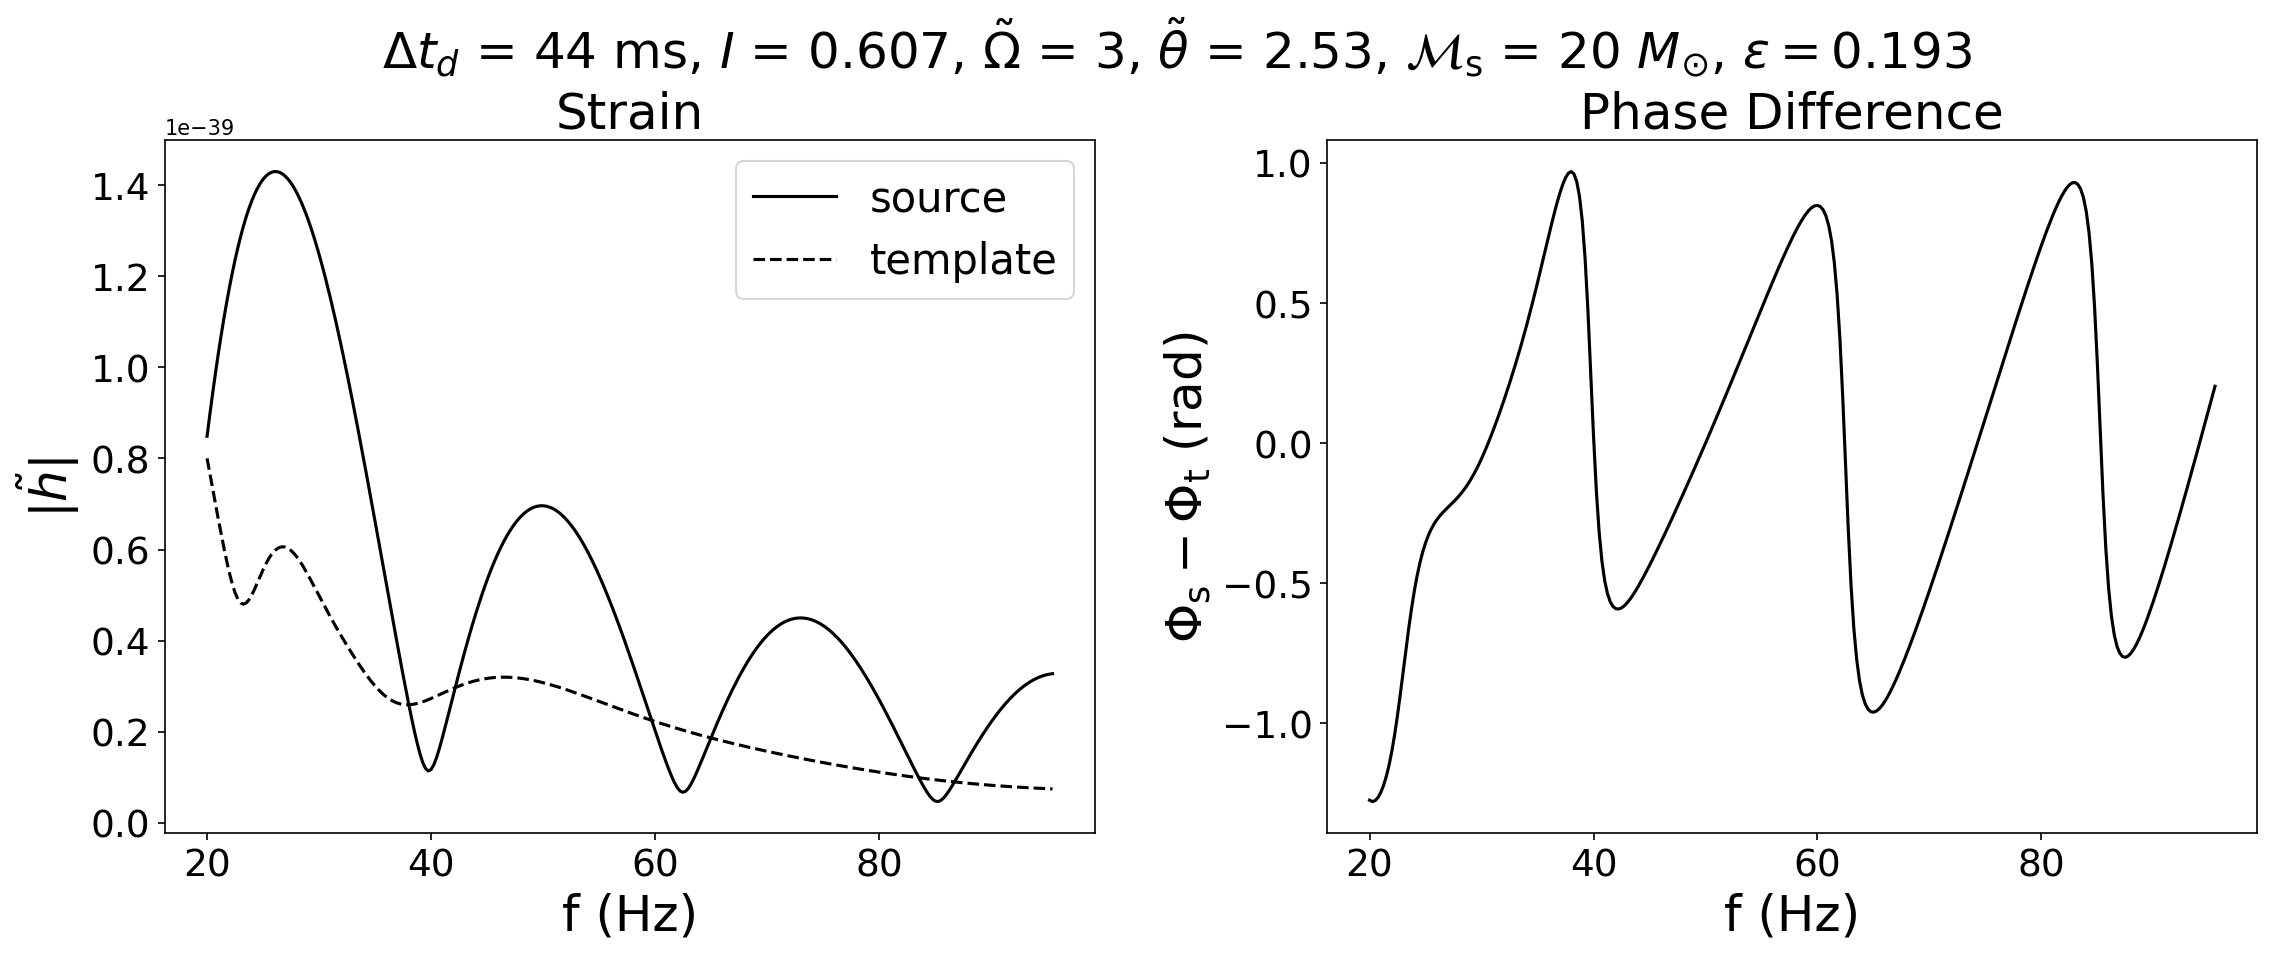

idx = 5.07546e-09, phi = -1.57615e-08, both should be ~0 if get_updated_mismatch_results is True


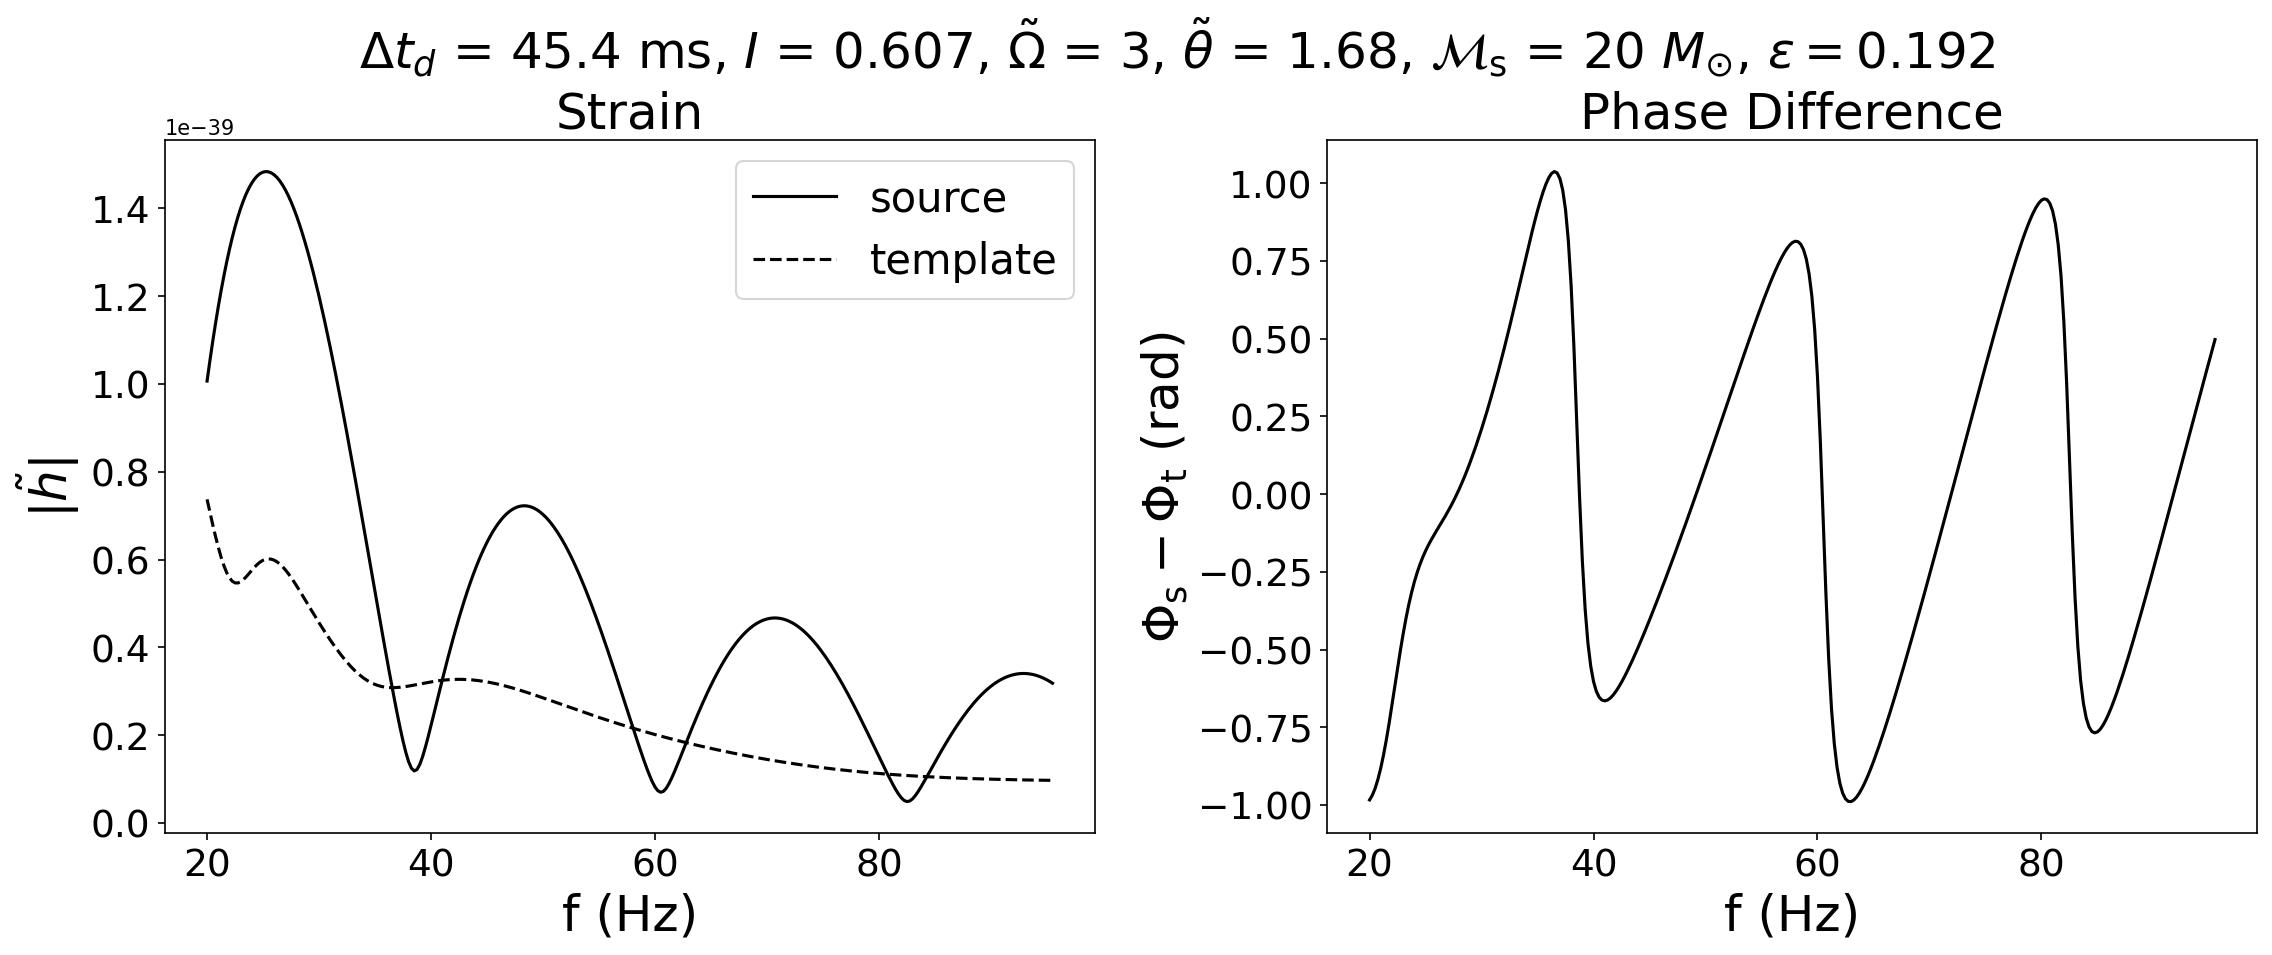

In [19]:
lens_params, RP_params, NP_params = set_to_params(
    lens_params_1, RP_params_1, NP_params_1
)

MLz_arr = np.linspace(400, 4600, 30)
Deltatd_ep_min_arr = np.array([mismatch_Deltatd_dict[Delta_td]["ep_min"] for Delta_td in Delta_td_arr])

for i in range(len(MLz_arr)):
    lens_params, RP_params = set_to_params(lens_params_1, RP_params_1)
    lens_params["MLz"] = MLz_arr[i] * solar_mass
    RP_params["omega_tilde"] = mismatch_Deltatd_dict[Delta_td_arr[i]]["ep_min_omega_tilde"]
    RP_params["theta_tilde"] = mismatch_Deltatd_dict[Delta_td_arr[i]]["ep_min_theta_tilde"]
    RP_params["gamma_P"] = mismatch_Deltatd_dict[Delta_td_arr[i]]["ep_min_gammaP"]

    plot_waveform_comparison(RP_params, lens_params, get_updated_mismatch_results=True)
    plt.show()